# pre

## import & setting

In [34]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import scipy
import pandas as pd
import scipy.io as sio
import pickle
import sys
sys.path.append('/home/yzy/bioSIMS/code/analysis')
from utils_220 import *
sc.set_figure_params(dpi=500, color_map='viridis',dpi_save=500,transparent=True)
sc.settings.verbosity = 2
%matplotlib inline
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


## functions

In [4]:
def get_adj_matters(key_matters,matter_list):
    key_matters = np.array(key_matters).astype('float')
    matter_list = np.array(matter_list).astype('float')
    adjested_key_matters = []
    for k in key_matters:
        m_diff = np.abs(matter_list-k)
        min_diff_idx = np.argmin(m_diff)
        min_diff_m = matter_list[min_diff_idx]
        adjested_key_matters.append(min_diff_m)
    adjested_key_matters = np.array(adjested_key_matters)
    return adjested_key_matters

In [5]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [6]:
def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]



In [7]:
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4


    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



In [8]:
def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

In [28]:
def show_images(images, cols = 1, titles = None,cmps='jet'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
#         print(cols)
#         cmp = cmps[n]
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        
    
        plt.imshow(image,cmap=cmps)
        plt.xticks([])
        plt.yticks([])
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

import matplotlib.pyplot as plt
# uh_pred = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(rep_embed)
# pred_y = np.ones(shape=(np.max(cell_idx)))
# pred_y = KMeans(3).fit_predict(sim_mat_bak)
# pred_y = SIMLR(sim_mat_bak,-8)
# pred_y = SpectralClustering(4,affinity='precomputed').fit_predict(sim_mat_order_bak)
# pred_y = AgglomerativeClustering(4,affinity='precomputed',linkage='complete').fit_predict(1/(input_sim_mat+1))
def plot_label_image(pred_y,cmp,save=None,mask=None):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
                
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=(5,5))
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='pdf',bbox_inches='tight')

#     for i in range(num_cells):
#         cur_idx = i + 1
#         cur_ind = cell_pos[cell_idx==cur_idx][0]
#     #     print(ind2ij(cur_ind,256,0))
#     #     print(ind2ij(cur_ind,256,1))

#         plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

   
    plt.show()
    
    
    
    
def plot_label_image(pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False,ifshow=True):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    to_labeling_pred_y_min = to_labeling_pred_y.min()
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
#     unique_cls_mask = [unique_cls[m] for m in mask]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
#             print(type(cluster_cmp))
#             print(to_mask,cluster_cmp)
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=figsize)
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')

    if anno:
        num_cells = pred_y.shape[0]
        for i in range(num_cells):
            cur_idx = i + 1
            cur_ind = cell_pos[cell_idx==cur_idx][0]
        #     print(ind2ij(cur_ind,256,0))
        #     print(ind2ij(cur_ind,256,1))
            if to_labeling_pred_y[i]-to_labeling_pred_y_min in mask:
                plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

    if ifshow:
        plt.show()

# experiment

## de novo SEAM

### load SIMS data

In [13]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'

# data = 'SPE1'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_718.mat'




# data='191125_gastric_div15_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_269.mat'


# data='20190115_liverfiber1_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_198.mat'
# data='liver_hoechst_blood_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_114.mat'
# data = '20190303_liverfiber_fix'
# data = '20190308_liver_P1LF2_2'

# data = 'P3_low_1_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_621.mat'
# data = 'P3_high_2_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_238.mat'

# data='liver-xwh-2-1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='SPE1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='20190103_lung3_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_164.mat'

# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'


# data='P4_low0_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_793.mat'


# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data='rat0_low0_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_699.mat'


# data='20190117_liverfiber2_pos_gaussian_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data = 'P5LC_POS1_HIGH0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_196.mat'

# data='mouse0_liver0_neg0_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_224.mat'

# data='mouse0_lung0_neg0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_225.mat'


# data='mouse0_lung0_pos0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_193.mat'


# data='mouse0_liver0_neg1_high0_5_None_ada'
# data='mouse0_liver0_neg1_high0_None_ada'
# # # # data='mouse0_liver0_neg1_high0_5_None_auto'
# data='mouse0_liver0_neg1_high0_div15_gaussian_ada'
# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'

# data = 'PCs/mouse0_liver0_neg0_low_PC0_div20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_659.mat'
 
# data = 'mouse0_liver0_neg2_high0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'



# data = 'mouse0_liver0_neg2_high0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'


# data='mouse0_kidney0_neg0_high0_20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_221.mat'

# data='mouse0_liver0_pos1_high1_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_200.mat'

# data='mouse0_liver0_neg1_low0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_691.mat'

data = 'P6_neg0_low0_None_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_231.mat'


# data = 'P6_neg1_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'



matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']
num_cells = np.max(cell_idx)
matter_list = pickle.load(open(matter_list_filename,'rb'))
matter_list = np.array(matter_list)

### normalize SIMS data

In [8]:
key_matters = [
#     Hepa
    70.34,98.38,84.34,111.4,56.3,82.34,116.37,140.44,153.43,54.31,
    
#     Hepa87+
    58.29,99.39,71.33,59.3,113.43,85.37,73.33,83.35,57.28,59.3,69.31,86.35,87.36,101.4,
    
#     Fib
    100.34,68.33,75.32,91.34,107.36,
    
#     nuclei
    63.25,79.27,181.39,134.45,159.39,90.35,197.38,103.34,66.3,64.3,128.36,199.4,106.37,78.31,261.42,65.3,
    
# Kupf/Endo
    60.28,61.28,76.31,77.31,
    
#     Immune cells
]

In [ ]:
HEG_87 = [87.36,59.31,69.32,71.34,101.41,221.56]
mark_list = [284,260,275,267,310,335,373,378,383,382,380,377,365,340,322,309,212,224,139,341,535,51,
303,232,212,188,213,200,346,634,535,693,691,442,25,28,2,233,234,298,278,302,428,450]

scale_ratio = 1.35
HEG_87_idx = [np.where(matter_list==m)[0][0] for m in HEG_87]
train_x_tmp = train_x.copy()
for i in range(train_x.shape[0]):
    cur_cell_idx = cell_idx[i]-1
    if cur_cell_idx in mark_list:
        train_x_tmp[i,HEG_87_idx] = train_x_tmp[i,HEG_87_idx]*scale_ratio

In [9]:
train_x_tmp = train_x.copy()

In [10]:
train_x_median = (train_x_tmp+1)/(np.percentile(train_x_tmp,50,axis=1,keepdims=True)+1)
train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)
train_x_total = np.log(train_x_total+1)
# train_x_A = (train_x+1)/(train_x[:,matter_list==134.06]+1)
sum_profile_list_median = []
sum_profile_list_total = []

max_profile_list_median = []
max_profile_list = []
mean_profile_list_median = []
max_profile_list_total = []
mean_profile_list_total = []
mean_profile_list=[]
# mean_profile_list_A=[]
# max_profile_list_A = []
for i in range(num_cells):
        mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list_median.append(np.max(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list.append(np.max(train_x[cell_idx==i+1,:],axis=0))
#         mean_profile_list_A.append(np.mean(train_x_A[cell_idx==i+1,:],axis=0))
#         max_profile_list_A.append(np.max(train_x_A[cell_idx==i+1,:],axis=0))
        
        sum_profile_list_median.append(np.sum(train_x_median[cell_idx==i+1,:],axis=0))
        mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
        mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
        max_profile_list_total.append(np.max(train_x_total[cell_idx==i+1,:],axis=0))
        sum_profile_list_total.append(np.sum(train_x_total[cell_idx==i+1,:],axis=0))
        
mean_profile_list_median = np.array(mean_profile_list_median)
max_profile_list_median = np.array(max_profile_list_median)
mean_profile_list_total = np.array(mean_profile_list_total)
max_profile_list_total = np.array(max_profile_list_total)
sum_profile_list_median = np.array(sum_profile_list_median)
sum_profile_list_total = np.array(sum_profile_list_total)
mean_profile_list = np.array(mean_profile_list)
max_profile_list = np.array(max_profile_list)
# mean_profile_list_A = np.array(mean_profile_list_A)
# max_profile_list_A = np.array(max_profile_list_A)

### run SIMS-ID

In [13]:


SIMS_id_t_list = [5,10,15,20,25,30,35,40,50]



# HEG_list = matter_list
# HEG_list = key_matters
HEG_list = get_adj_matters(key_matters,matter_list)


HEG_col_idx = [list(matter_list).index(HEG) for HEG in HEG_list]

netwidths=[128,128,128]

error_threshold=0
train_x_HEG = train_x_tmp[:,HEG_col_idx]
train_x_preprocess = train_x_HEG
# train_x_preprocess = (train_x_HEG+1)/(train_x_HEG[:,matter_list==133.92]+1)

train_x_preprocess = (train_x_HEG)/np.sum(train_x_HEG,axis=1,keepdims=True)
# train_x_preprocess = (train_x_HEG+1)/(np.percentile(train_x_HEG,50,axis=1,keepdims=True)+1)




# train_x_preprocess = MinMaxScaler().fit_transform(train_x_preprocess)
# train_x_preprocess = np.log(train_x_preprocess+1)

# train_x_preprocess = train_x_preprocess-train_x_preprocess.mean(axis=0)
# U, s, V = np.linalg.svd(train_x_preprocess, full_matrices=False)
# train_x_preprocess = np.dot(U, np.diag(s))[:,:50]

# noise_matrix = np.random.rand(train_x_preprocess.shape[0],train_x_preprocess.shape[1])
# noise_matrix = np.ones_like(train_x_preprocess)
# train_x_preprocess = np.hstack([train_x_preprocess,noise_matrix])


rep_list = get_distil_rep(train_x_preprocess,cell_idx,num_cells,SIMS_id_t_list, verbose=False,epochs=200,netwidths=netwidths,low_dim=netwidths[2],error_threshold=error_threshold)


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
6913/6913 [==============================] - 1s 181us/step - loss: 6.4675 - softmax_loss: 6.4649 - center_loss: 4.3675
Epoch 2/200
6913/6913 [==============================] - 1s 101us/step - loss: 6.2917 - softmax_loss: 6.3015 - center_loss: 6.8324
Epoch 3/200
6913/6913 [==============================] - 1s 100us/step - loss: 6.1516 - softmax_loss: 6.1533 - center_loss: 7.1347
Epoch 4/200
6913/6913 [==============================] - 1s 100us/step - loss: 6.0189 - softmax_loss: 6.0233 - center_loss: 12.7374
Epoch 5/200
6913/6913 [==============================] - 1s 106us/step - loss: 5.8822 - softmax_loss: 5.8781 - center_loss: 23.1640
Epoch 6/200
6913/6913 [==============================] - 1s 122us/step - loss: 5.7898 - softmax_loss: 5.7944 - center_loss: 31.5878
Epoch 7/200
6913/6913 [==============================] - 1s 125us/step - loss: 5.7562 - softmax_loss: 5.7524 - center_loss: 36.8816
Epoch 8/200
6913/6913 [==============================] - 1s 96us/step - loss: 5

### run SIMLR

In [40]:
# rep = rep_list[0]
# rep = rep_list[0]
# from sklearn.manifold import tsne
# #PCA预处理
# rep_preprocess = np.log(rep+1)
# rep_preprocess = rep_preprocess-rep_preprocess.mean(axis=0)
# U, s, V = np.linalg.svd(rep_preprocess, full_matrices=False)
# rep_preprocess = np.dot(U, np.diag(s))[:,:50]
#PCA预处理
# rep_preprocess = rep

# rep_preprocess = rep_list[0][:,0][:,None]

# rep_embed = umap.UMAP(n_neighbors=30,min_dist=0).fit_transform(rep_preprocess)
# rep_embed = fast_tsne(rep_preprocess,perplexity=20)

# input_sim = sim_mat_order
# input_dist = 1/(1+input_sim)

# input_dist = (sim_mat+np.transpose(sim_mat))/2
# input_dist = squareform(pdist(rep_list[4]))
# input_dist = input_sim_mat
import SIMLR
input_rep = rep_list[0]
# input_rep = SIMLR.helper.fast_pca(input_rep,500)
# input_rep = mean_profile_list_median

input_dist = squareform(pdist(input_rep,'cosine'))
# input_dist = rodist_mat_asy
# input_dist = -SSA_dist
# input_dist = 1-LWCM_np
# input_dist = dist_mat[list(matter_list).index(114.91),:,:]
# input_dist = test_mat
# input_dist = 1-A
# input_dist = sim_mat_median_sym
# input_dist = squareform(pdist(mean_profile_list_median))
# rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist,pseudo_y)
rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist)
# c, num_clust, req_c = FINCH(input_rep, initial_rank=None, req_clust=3, distance='cosine', verbose=True)
# rep_embed = phate.PHATE(knn=10, decay=100,knn_dist='precomputed').fit_transform(input_dist)
# rep_embed = TSNE(metric='precomputed').fit_transform(input_dist)
# pred_y = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=5,metric='precomputed').fit_predict(input_dist)
# pred_y = KMeans(2).fit_predict(rep_embed)
# pred_y = pseudo_y
# pred_y = RMKKM(input_rep,3.0)
# [pred_y,A] = SLKE(rep_embed,2)
# [pred_y,A] = SSR(rep_embed,2)
# pred_y[mark_list]=np.max(pred_y)+1
# pred_y = pseudo_y

c=5
start_main = time.time()
simlr = SIMLR.SIMLR_LARGE(c, 30, 0); ###This is how we initialize an object for SIMLR. the first input is number of rank (clusters) and the second input is number of neighbors. The third one is an binary indicator whether to use memory-saving mode. you can turn it on when the number of cells are extremely large to save some memory but with the cost of efficiency.
S, F,val, ind = simlr.fit(input_rep)
print('Successfully Run SIMLR! SIMLR took %f seconds in total\n' % (time.time() -         start_main))
pred_y = simlr.fast_minibatch_kmeans(F,c)




# pred_y,A = SIMLR(input_rep,5)
# pred_y = req_c
# pred_y = c[:,3]
# pred_y = label_list[0]
# pred_y = pred_y_DB
# pred_y = KMeans(4).fit_predict(rep_list[3])
cluster_cmp = sns.hls_palette(np.unique(pred_y).shape[0])
labeling_plot_cmp = ['k']
labeling_plot_cmp.extend(cluster_cmp)
# mean_profile_list_median_preprocess = mean_profile_list_median-mean_profile_list_median.mean(axis=0)
# U, s, V = np.linalg.svd(mean_profile_list_median_preprocess, full_matrices=False)
# mean_profile_list_median_preprocess = np.dot(U, np.diag(s))[:,:50]
# umap_median_mean = umap.UMAP().fit_transform(mean_profile_list_median_preprocess)
# umap_median_mean = fast_tsne(mean_profile_list_median_preprocess,perplexity=50)
# fast_tsne(X50, perplexity=50, seed=42)

# X = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X, full_matrices=False)
# X50 = np.dot(U, np.diag(s))[:,:50]
# umap_median_mean = 
scatter_pd_data = {
    'x':[],
    'y':[],
    'i':[],
    
}
for i in range(num_cells):
    cur_x = rep_embed[i,0]
    cur_y = rep_embed[i,1]
    cur_idx = i
    scatter_pd_data['x'].append(cur_x)
    scatter_pd_data['y'].append(cur_y)
    scatter_pd_data['i'].append(cur_idx)
    for matter in matter_list:
        cur_profile = mean_profile_list_median[i,matter_list==matter][0]
#         print(cur_profile)
        if not scatter_pd_data.get(matter):
            scatter_pd_data[matter]=[cur_profile]
        else:
            scatter_pd_data[matter].append(cur_profile)

scatter_pd = pd.DataFrame(scatter_pd_data)
            
scatter_pd['mark'] = pd.Series(np.zeros(shape=(scatter_pd.shape[0])),index=scatter_pd.index)


# mark_list = [284,260,275,267,310,335,373,378,383,382,380,377,365,340,322,309,212,224,139,341,535,51,
# 303,232,212,188,213,200,346,634,535,693,691,442,25,28,2,233,234,298,278,302,428,450]
# fix
# mark_list = [391,403,376,397,357,367]

# liverfiber1
# mark_list = [404,443,428,430,448,449,450,463,464]

# liverfiber1
# mark_list = [404,443,428,448,449,463]
# mark_list = [404,443,428,448,449,463]

# SPE1
# mark_list = [140,146]


# lung
# mark_list=[155,138,145,156,139,131,136]


# for ml in mark_list:
#     scatter_pd.loc[scatter_pd.i==ml,['mark']]=1
         

SIMLR highly recommends you to perform PCA first on the data

Please use the in-line function fast_pca on your input



/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:70: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(d)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:75: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  u = AnnoyIndex(d)


Successfully Run SIMLR! SIMLR took 2.117709 seconds in total



### create anndata

In [15]:
import anndata as ad
# mean
# in_X =  rep_list[3]
in_X = mean_profile_list_median
# g = map(str,range(in_X.shape[1]))
g = map(str,matter_list)
Genes = []
None_idx = 0
Genes = g
# obs_name must be str
obs_name = list(map(str,range(in_X.shape[0])))
obs = pd.DataFrame(index=obs_name)

# var_name must be str
var = pd.DataFrame(index=Genes)

#     var['Genes'] = Genes
a = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
a.uns['rep_list'] = rep_list



AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'cls_5_pca', 'leiden', 'cls_5'
    uns: 'rep_list', 'cls_5_pca_colors', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'cls_5_colors'
    obsm: 'X_umap', 'cls_5_pca_rep', 'cls_5_rep'

In [51]:
cur_exp_name = 'cls_5'
a.obsm['X_umap'] = rep_embed
a.obs[cur_exp_name] =pred_y.astype('int').astype('str')
a.obs[cur_exp_name] = a.obs[cur_exp_name].astype('category')
a.obsm[cur_exp_name+'_rep'] = input_rep.copy()

### scanpy ploting

In [91]:
np.unique(a.obs['cls_5_reorder'])

array(['1', '2', '3', '4', '5', '6'], dtype=object)

In [93]:
a.uns['cls_5_reorder_colors'] = np.array([[0.49803922, 0.23529412, 0.55294118],
       [0.06666667, 0.64705882, 0.4745098 ],
       [0.94901961, 0.71764706, 0.00392157],
       [0.90196078, 0.51372549, 0.0627451 ],
       [0.        , 0.5254902 , 0.58431373],
       [0.90588235, 0.24705882, 0.45490196]])

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


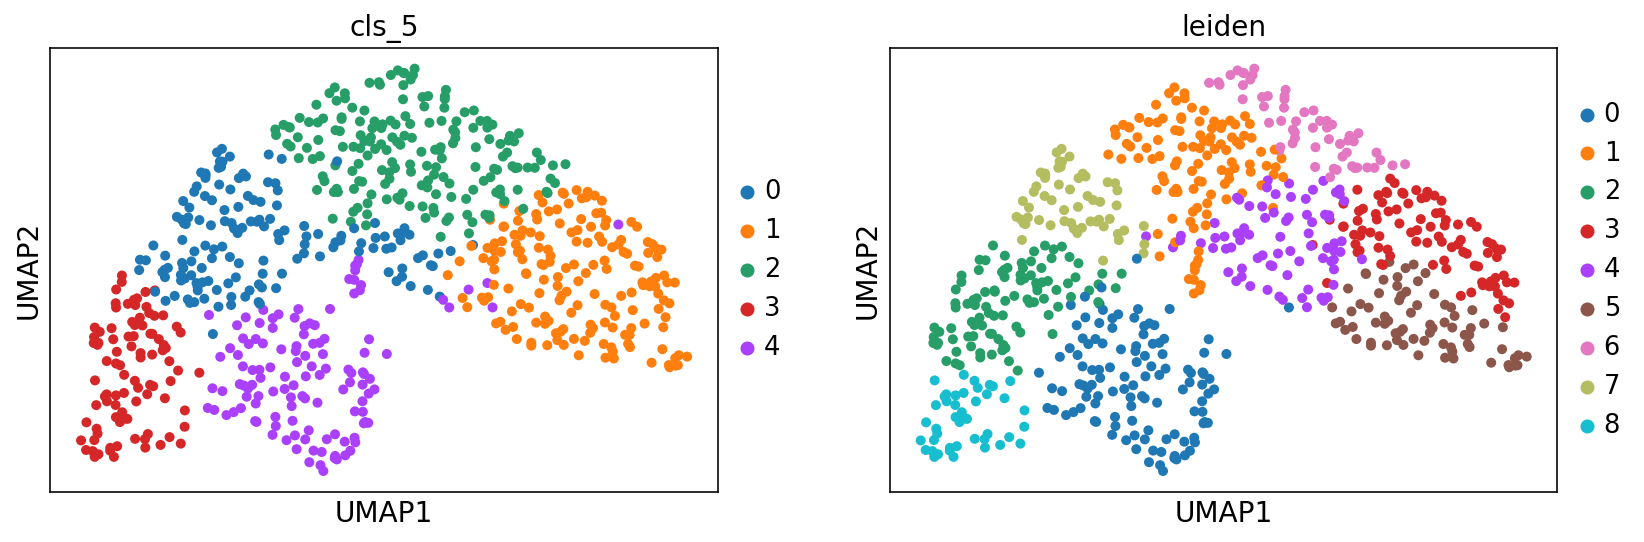

In [47]:
sc.pp.neighbors(a,use_rep=cur_exp_name+'_rep',metric='cosine',n_neighbors=30)
sc.tl.leiden(a)
sc.tl.umap(a)
sc.pl.umap(a,color=[cur_exp_name,'leiden'],s=100)

NameError: name 'a' is not defined

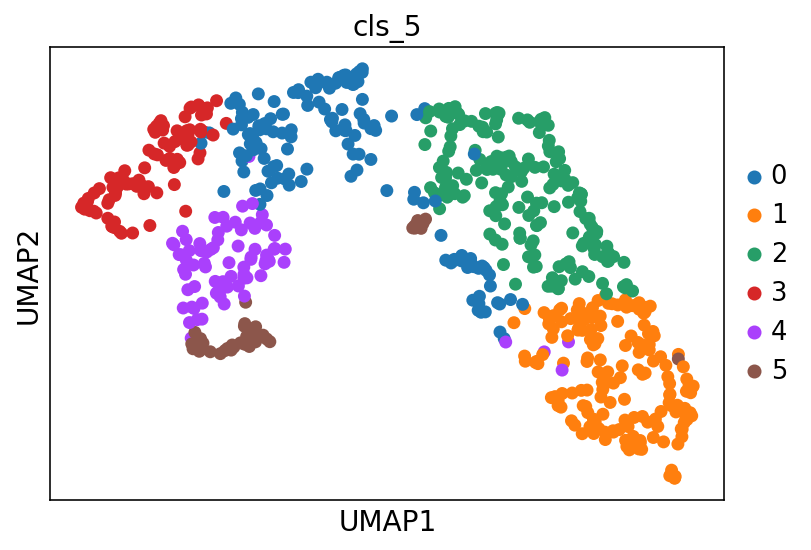

In [67]:
sc.pl.umap(a,color=[cur_exp_name,])

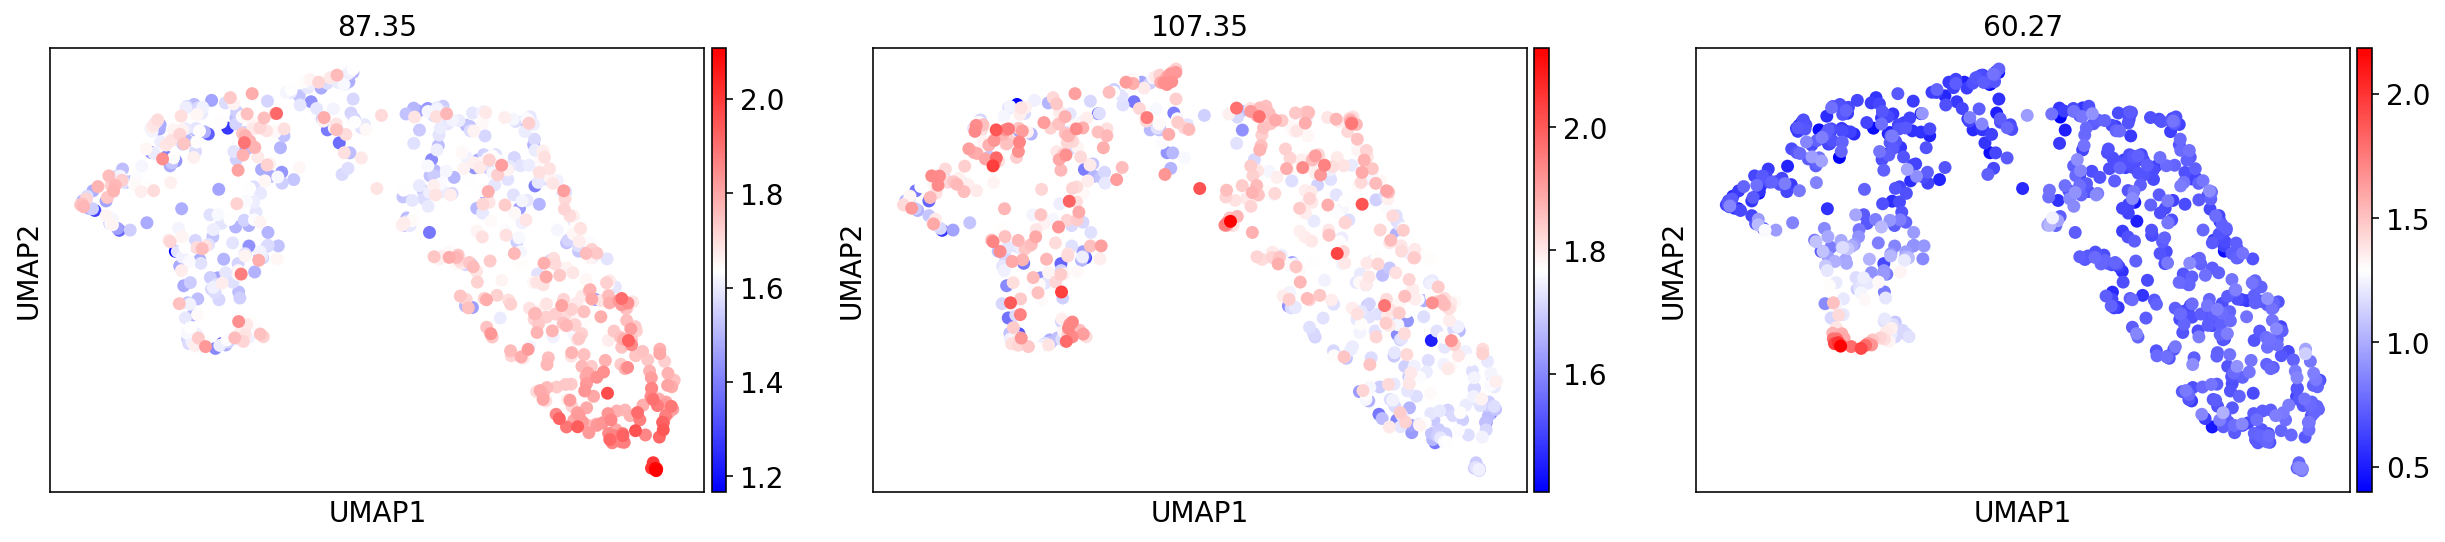

In [43]:
sc.pl.umap(a,color=['87.35','107.35','60.27'],cmap='bwr')


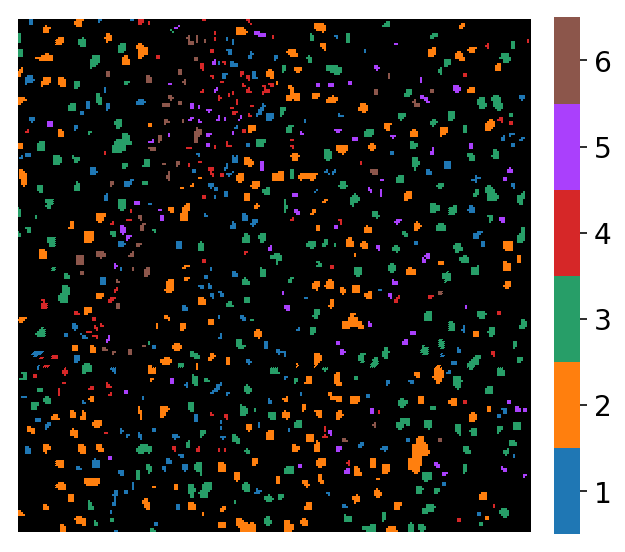

In [68]:
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=None)


In [81]:
np.unique(a.obs[cur_exp_name+'_reorder'])

array(['0', '2', '3', '4', '5', '6'], dtype=object)

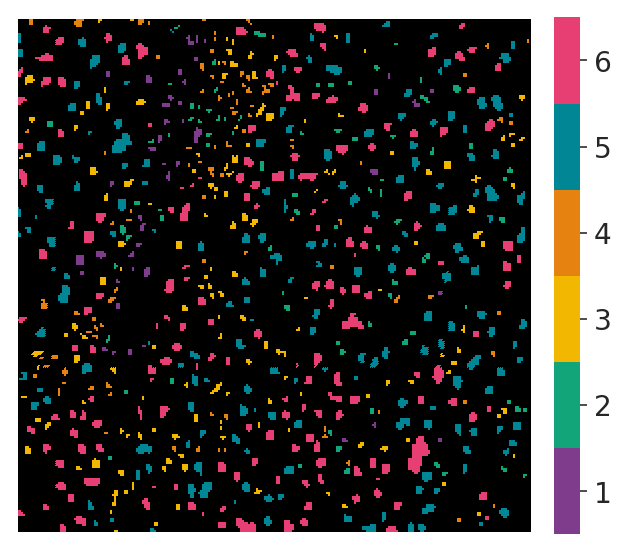

In [127]:
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=None)


In [128]:
palettable.colorbrewer.diverging.RdGy_11.mpl_colors

[(0.403921568627451, 0.0, 0.12156862745098039),
 (0.6980392156862745, 0.09411764705882353, 0.16862745098039217),
 (0.8392156862745098, 0.3764705882352941, 0.30196078431372547),
 (0.9568627450980393, 0.6470588235294118, 0.5098039215686274),
 (0.9921568627450981, 0.8588235294117647, 0.7803921568627451),
 (1.0, 1.0, 1.0),
 (0.8784313725490196, 0.8784313725490196, 0.8784313725490196),
 (0.7294117647058823, 0.7294117647058823, 0.7294117647058823),
 (0.5294117647058824, 0.5294117647058824, 0.5294117647058824),
 (0.30196078431372547, 0.30196078431372547, 0.30196078431372547),
 (0.10196078431372549, 0.10196078431372549, 0.10196078431372549)]

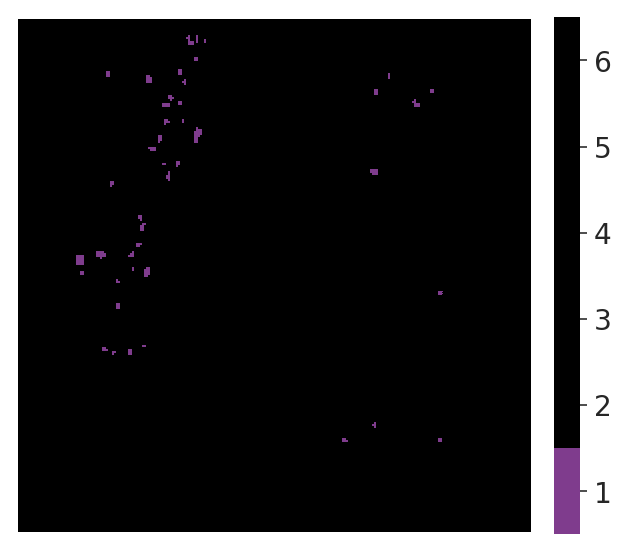

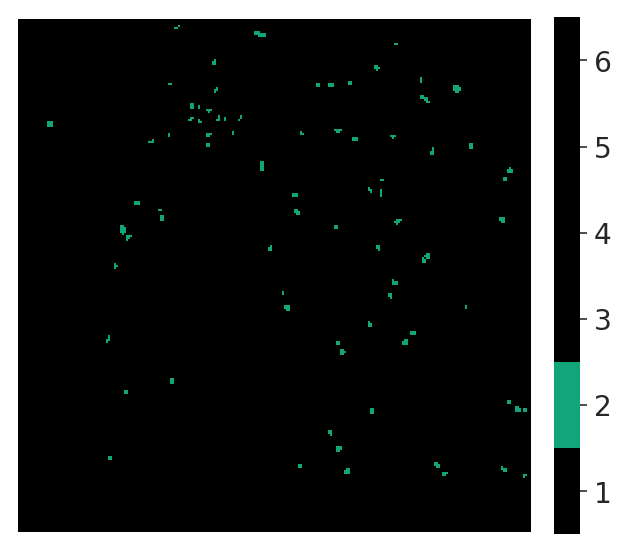

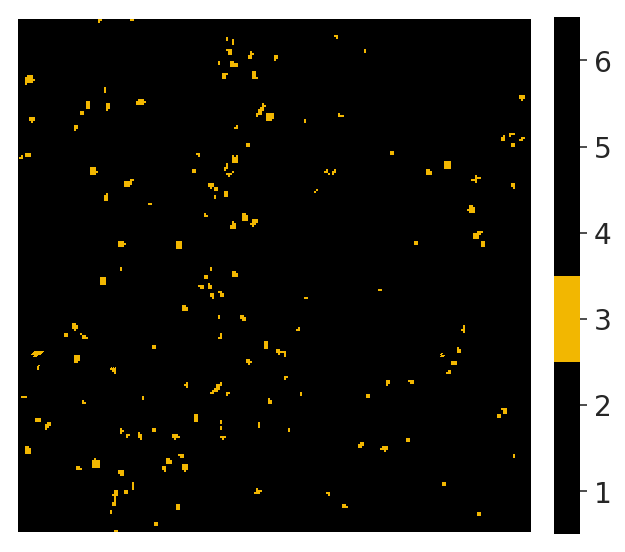

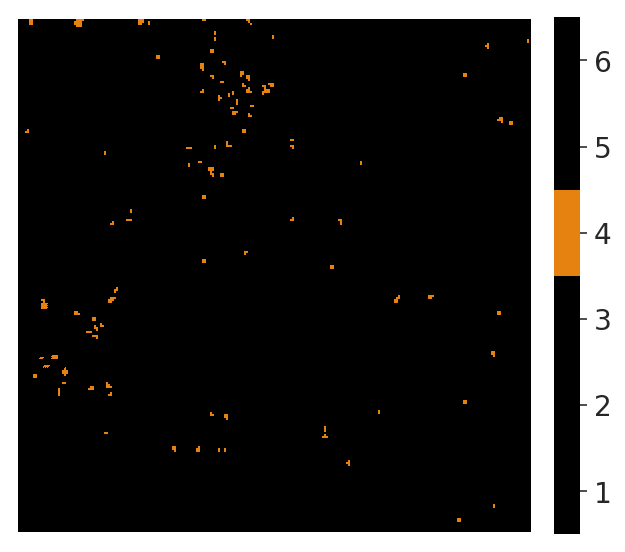

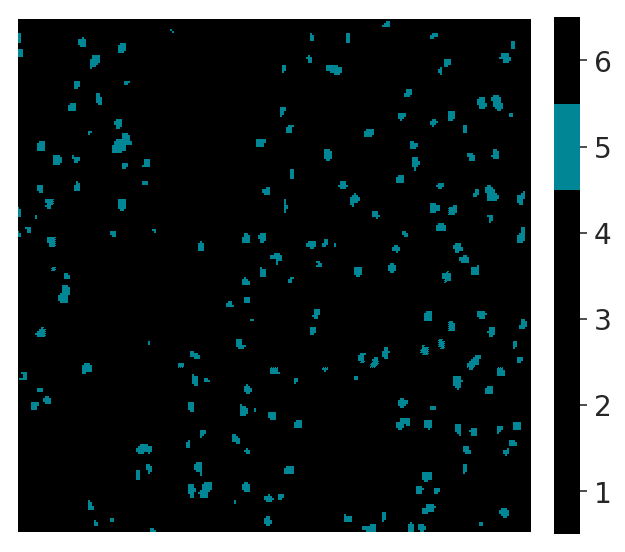

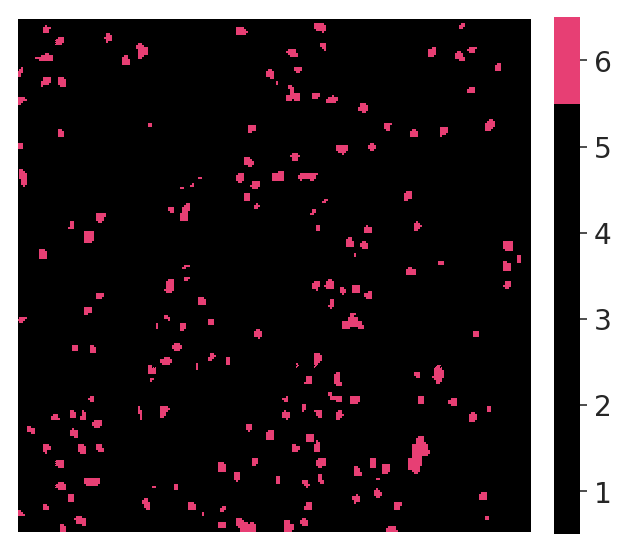

In [140]:
# cur_exp_name = 'cls_5'
for i in range(6):
    plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=[i],save=None)
    


In [52]:
a_sub = a[a.obs[cur_exp_name]=='4']

In [63]:
sc.pp.neighbors(a_sub,use_rep=cur_exp_name+'_rep')
sc.tl.leiden(a_sub,resolution=0.2)

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


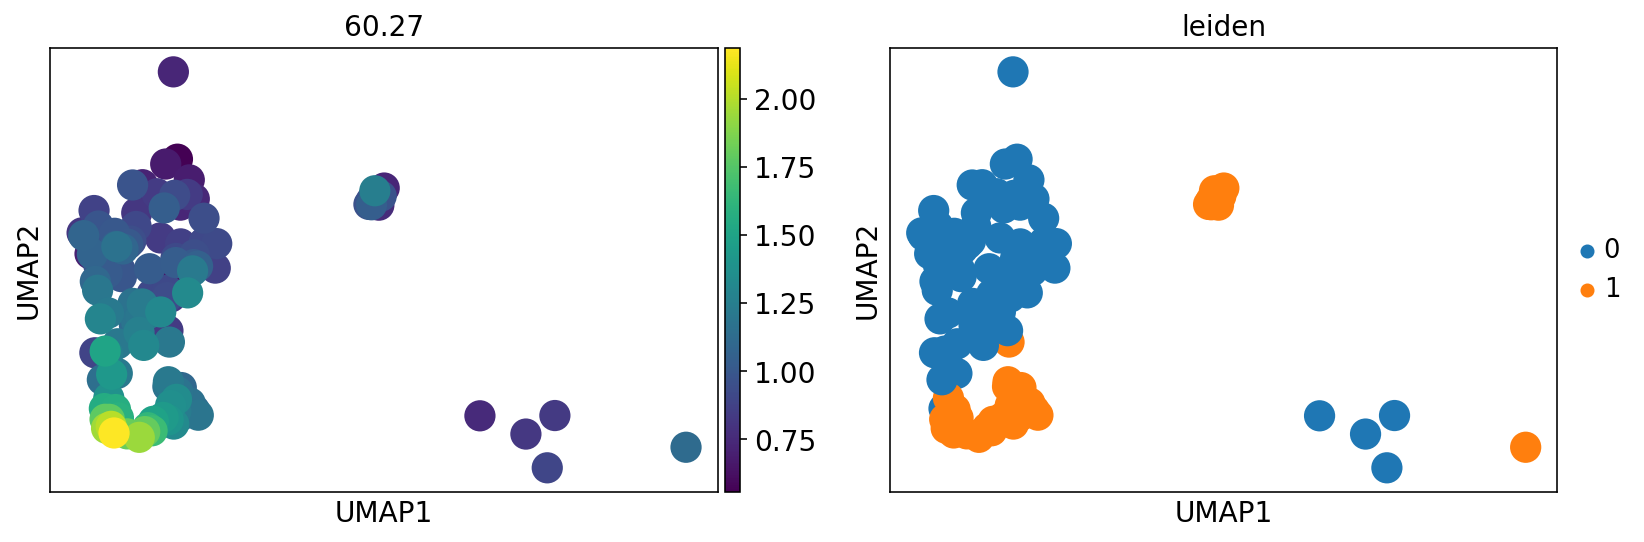

In [64]:
sc.pl.umap(a_sub,color=['60.27','leiden'])

In [66]:
a_cls_sub = np.array(a.obs[cur_exp_name])
ec_cls = np.array(a_sub.obs['leiden'])
to_replace_cls = '4'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)
a.obs[cur_exp_name] = a_cls_sub_modified
a.obs[cur_exp_name] = a.obs[cur_exp_name].astype('category')


In [82]:
np.unique(a_cls)

array(['0', '1', '2', '3', '4', '5'], dtype=object)

In [83]:
a_cls = (a.obs[cur_exp_name].copy()).astype('str')
a_cls_reorder = a_cls.copy()
a_cls_reorder[a_cls=='5']='1'
a_cls_reorder[a_cls=='4']='2'
a_cls_reorder[a_cls=='0']='3'
a_cls_reorder[a_cls=='3']='4'
a_cls_reorder[a_cls=='2']='5'
a_cls_reorder[a_cls=='1']='6'



In [84]:
a.obs[cur_exp_name+'_reorder'] = a_cls_reorder
a.obs[cur_exp_name+'_reorder'] = a.obs[cur_exp_name+'_reorder'].astype('category')

In [71]:
key_markers = [
#     Fib
    50.27,80.29,80.29,94.37,96.36,107.35,
#     nuclei
    90.35,128.4,132.43,134.45,144.37,149.43,159.39,165.4,181.44,
#     Endo:
    60.28,61.28,62.29,76.31,77.31,203.49,233.5,295.47,497.45,
#     Kupf:
    187.45,211.52,
#     IM:
    120.39,188.47,214.44,219.5,227.53,229.47,357.45,395.44,
#     Hepa
    122.4,154.45,180.43,206.49,213.49,
#     Hepa69+
    58.29,99.39,71.33,59.3,113.43,85.37,73.33,83.35,57.28,59.3,69.31,86.35,87.36,101.4,
]

In [72]:
key_markers_rep0 = get_adj_matters(key_markers,a.var_names)
key_markers_rep0 = np.array(key_markers_rep0).astype('str')

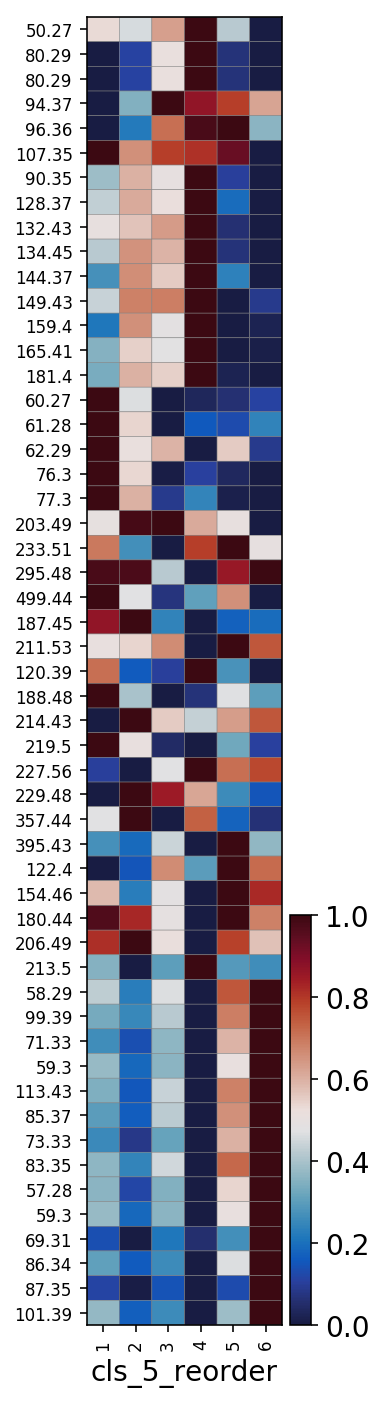

GridSpec(2, 3, height_ratios=[0, 10.600000000000001], width_ratios=[1.7999999999999998, 0, 0.2])

In [85]:
sc.pl.matrixplot(a,key_markers_rep0,groupby=cur_exp_name+'_reorder',standard_scale='var',cmap=heatmap_cmp,dendrogram=False,save=None,swap_axes=True)


In [33]:
sc.tl.rank_genes_groups(a,groupby='cls_5',method='t-test')

ranking genes
    finished (0:00:00)


In [73]:
fib_matters = [100.34,107.35]
fib_matters = np.array(fib_matters).astype('str')

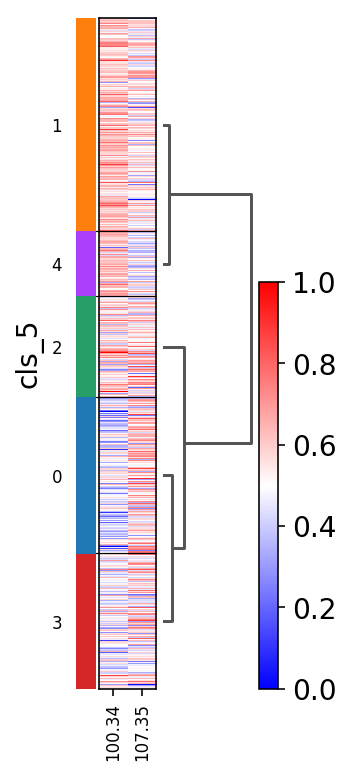

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 0.6, 1, 0.2])

In [74]:
sc.pl.heatmap(a,fib_matters,groupby='cls_5',standard_scale='var', cmap='bwr',dendrogram=True,save=None)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_cls_5']`


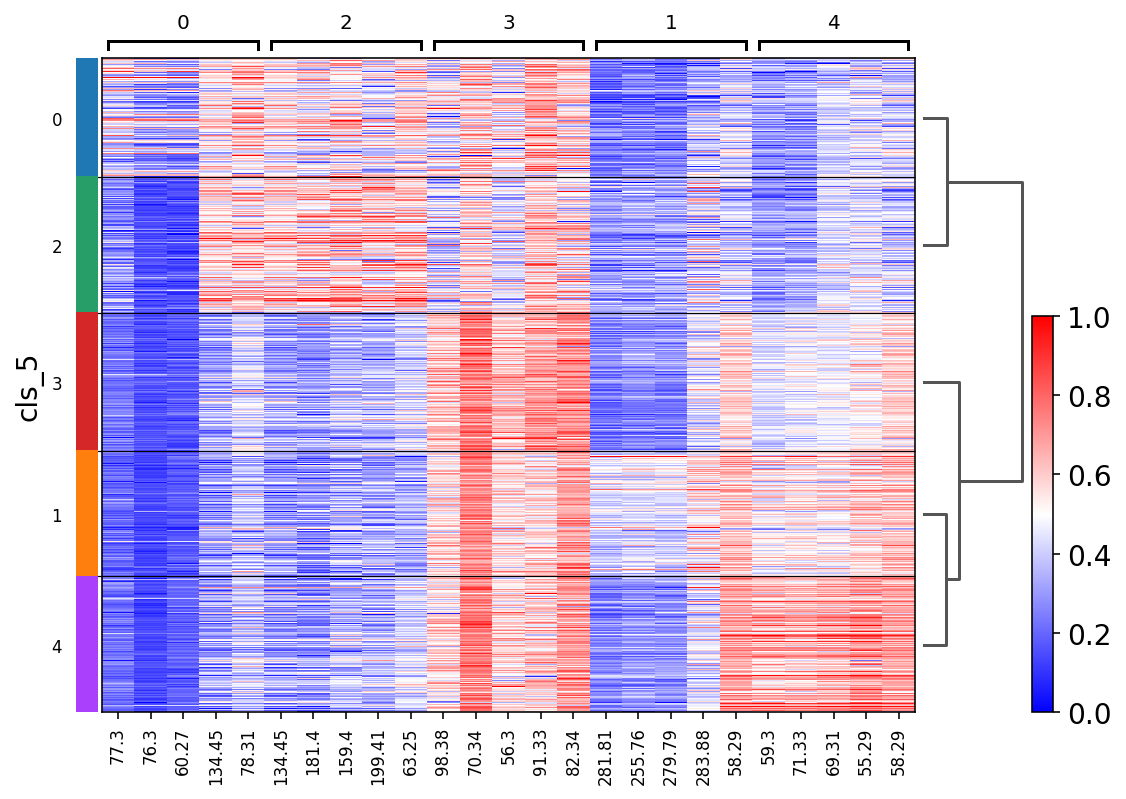

In [34]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_5',n_genes=5,standard_scale='var', cmap='bwr',dendrogram=True,save=None)


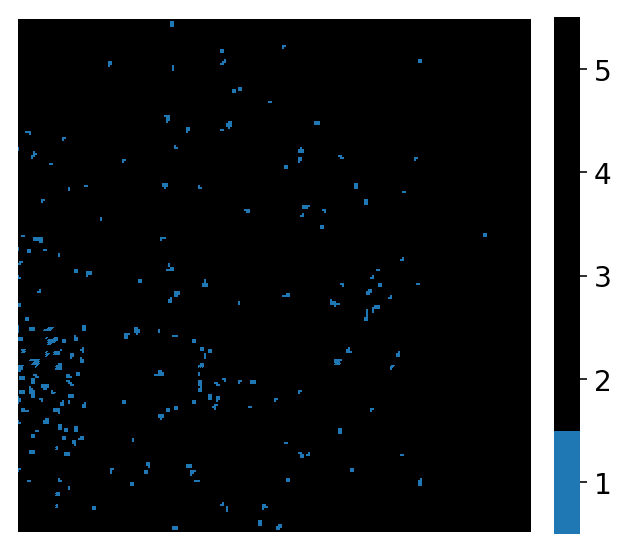

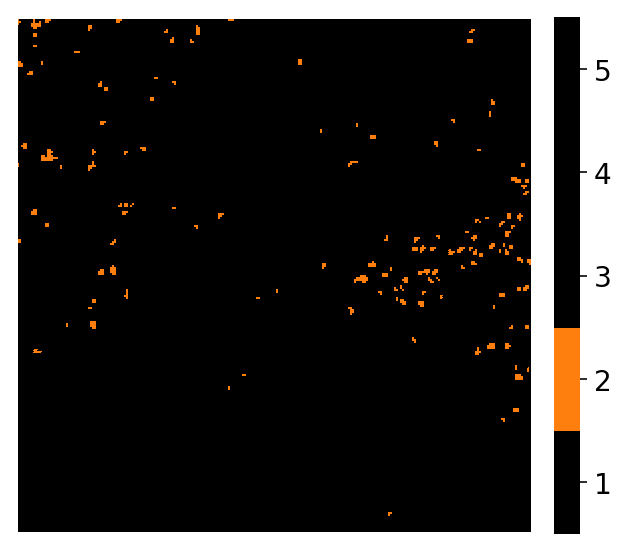

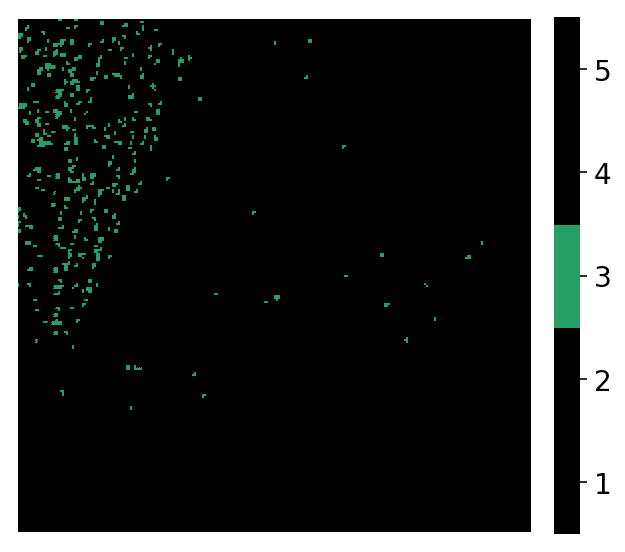

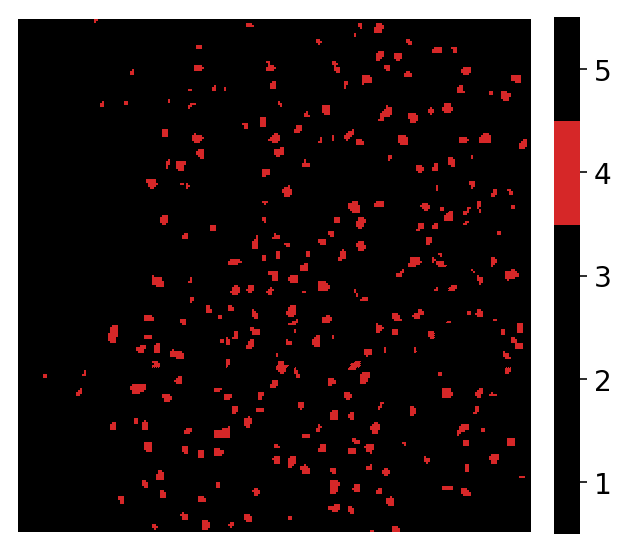

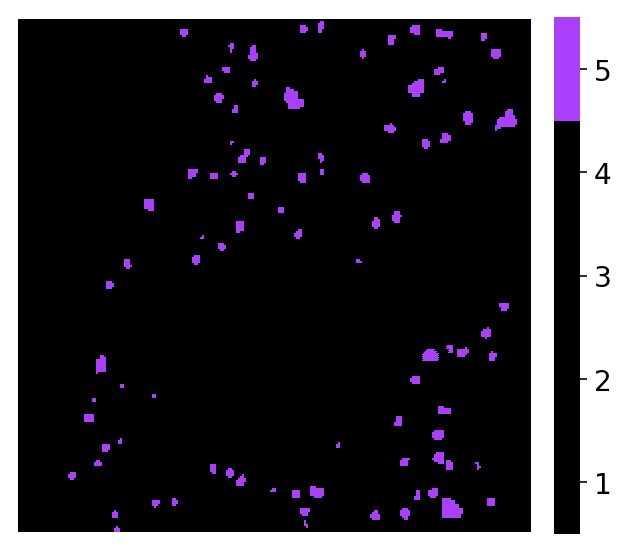

In [30]:
for i in range(5):
    plot_label_image(a.obs['cls_5_pca'],a.uns['cls_5_pca_colors'],mask=[i],save=None)
    


## data loading

In [6]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'


# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'
data = 'P6_neg1_low0_None_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'



matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']

In [10]:
a = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_rep0_cls6_reorder_full.h5ad')
# f = open('figures/Fig4_dump_data/fig4_cluster4_add.pkl', 'rb') 
# a = pickle.load(f)

In [10]:
cls_4 = np.array(a.obs['pred'])
cls_4[cls_4=='4']='2'
cls_4[cls_4=='5']='4'
a.obs['cls_4'] = cls_4

## color setting

In [ ]:
bold_cmp = palettable.cartocolors.qualitative.Bold_10.mpl_colors
safe_cmp = palettable.cartocolors.qualitative.Safe_10.mpl_colors
pastel_cmp = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
test_colors =  [
#     pastel_cmp[0],
    (0, 111/255, 255/255),
    bold_cmp[1],
    bold_cmp[3],
    bold_cmp[7],
    bold_cmp[4],
#     pastel_cmp[3],
    (19/255, 244/255, 239/255)
    
    
    
]
fluo_colors = [
    (0, 111/255, 255/255),
    
    (19/255, 244/255, 239/255),
    
    (250/255, 255/255, 0),
    (104/255, 255/255, 0),
    
    (255/255, 0, 92/255),
    (255/255, 191/255, 0),
    
]
a_rep1_heatmap.uns['test_colors'] = fluo_colors

In [23]:
fluo_colors = [
    (0, 111/255, 255/255),
    (19/255, 244/255, 239/255),
    (250/255, 255/255, 0),
    (255/255, 191/255, 0),
    (104/255, 255/255, 0),
    
    
    (255/255, 0, 92/255),
    
    
    
    
]
a.uns['test_colors'] = fluo_colors

In [21]:
a.obs['test'] = a.obs['cls_5_reorder'].copy()

In [38]:
a.write('figures/Fig4_dump_data/fig4_rep0_cls6_fluo.h5ad')

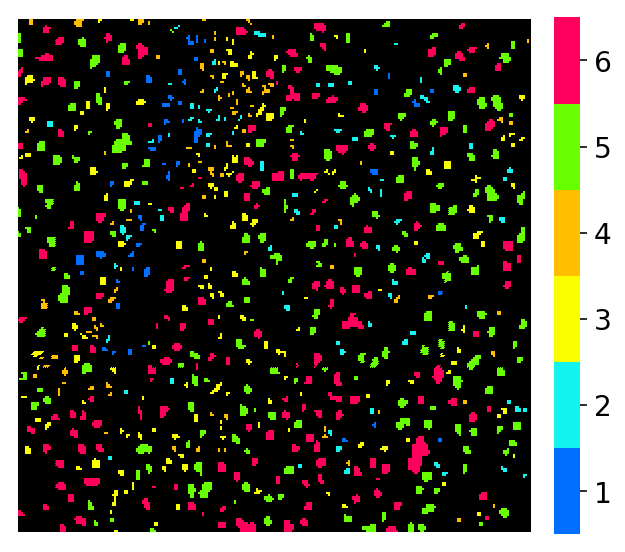

In [29]:
cur_save = '/home/yzy/ipynbs/figures/Fig4_rep0/c6/cluster_image_all.png'

plot_label_image(a.obs['test'],a.uns['test'+'_colors'],mask=None,save=cur_save)


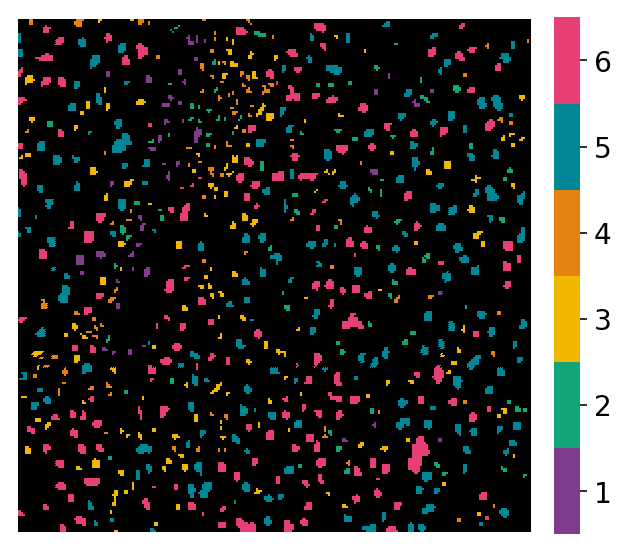

In [20]:
plot_label_image(a.obs['cls_5_reorder'],a.uns['cls_5_reorder'+'_colors'],mask=None,save=None)


## umap projection

In [111]:
cmp_5 = palettable.colorbrewer.qualitative.Set1_5.mpl_colors
# 0:红
# 1:蓝
# 2:绿
# 3:紫
# 4:黄

In [28]:
cur_cmp = [cmp_5[3],cmp_5[1],cmp_5[2],cmp_5[0]]

In [141]:
cur_cmp

[(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

In [29]:
a.uns['cls_4_colors'] = cur_cmp

In [13]:
a

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'SIMS-Cluster', 'fibro_dist', 'fibro_zonation'
    uns: 'SIMS-Cluster_colors', 'dendrogram_SIMS-Cluster', 'fibro_zonation_colors', 'rank_genes_groups', 'rep_list'
    obsm: 'X_umap', 'X_pca', 'spatial'

... storing 'cls_sub' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have 

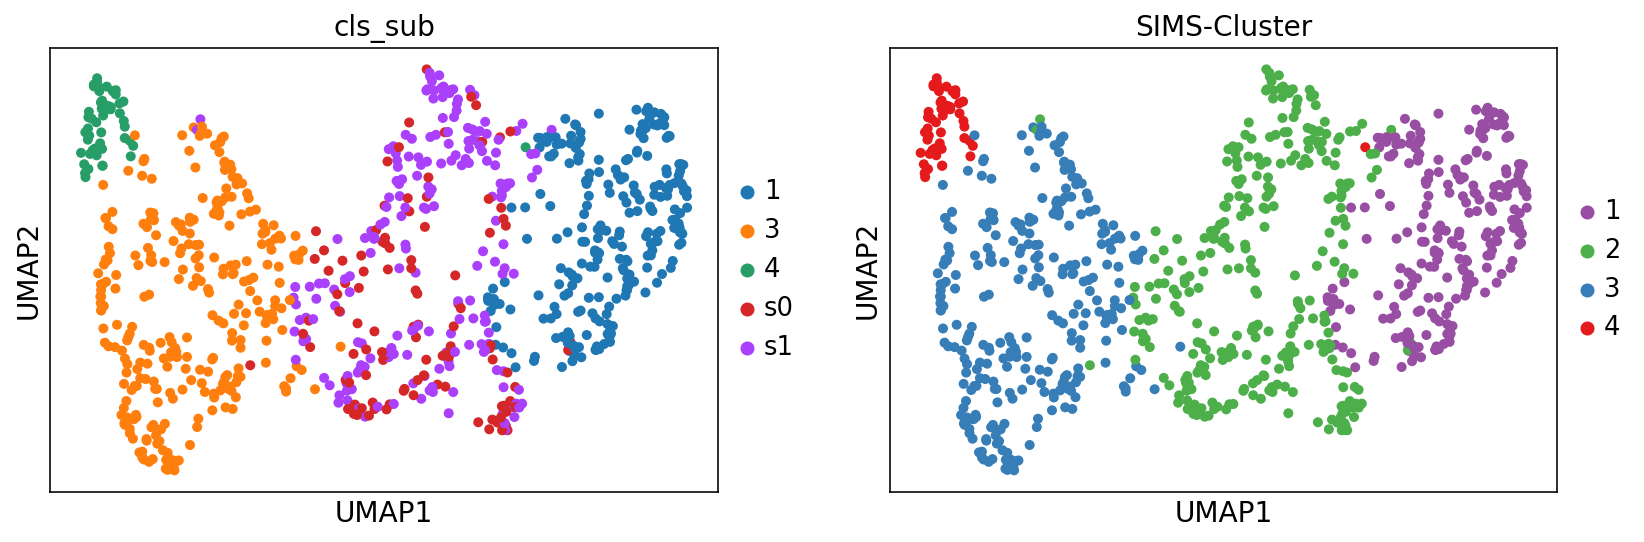

In [100]:
sc.pl.umap(a,color=['cls_sub','SIMS-Cluster'],save=None,s=100)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

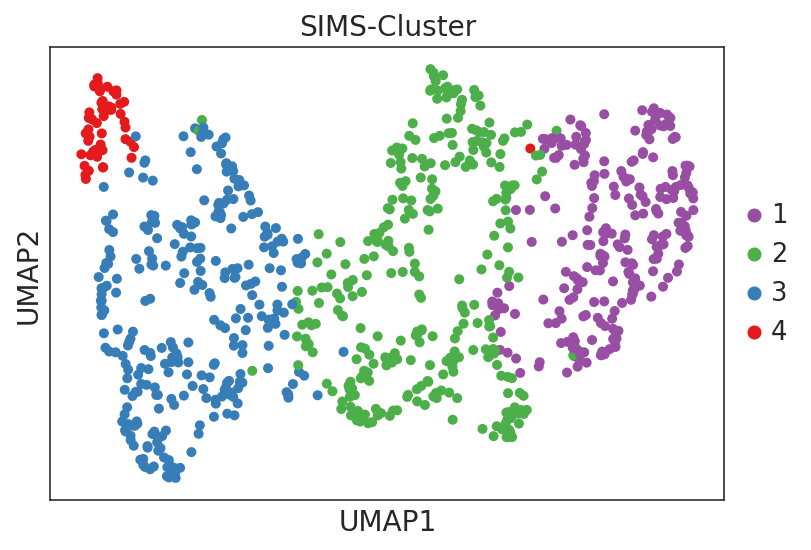

In [317]:
sc.pl.umap(a,color=['SIMS-Cluster'],save=None,s=100)

In [74]:
a_cls2 = a[a.obs['SIMS-Cluster']=='2']

In [75]:
a_cls2 = a_cls2[:,['91.33','77.31']]

In [152]:
sc.pp.neighbors(a_cls2,use_rep='spatial')
sc.tl.louvain(a_cls2,resolution=5)

computing neighbors
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [153]:
np.unique(a_cls2.obs['louvain'])

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

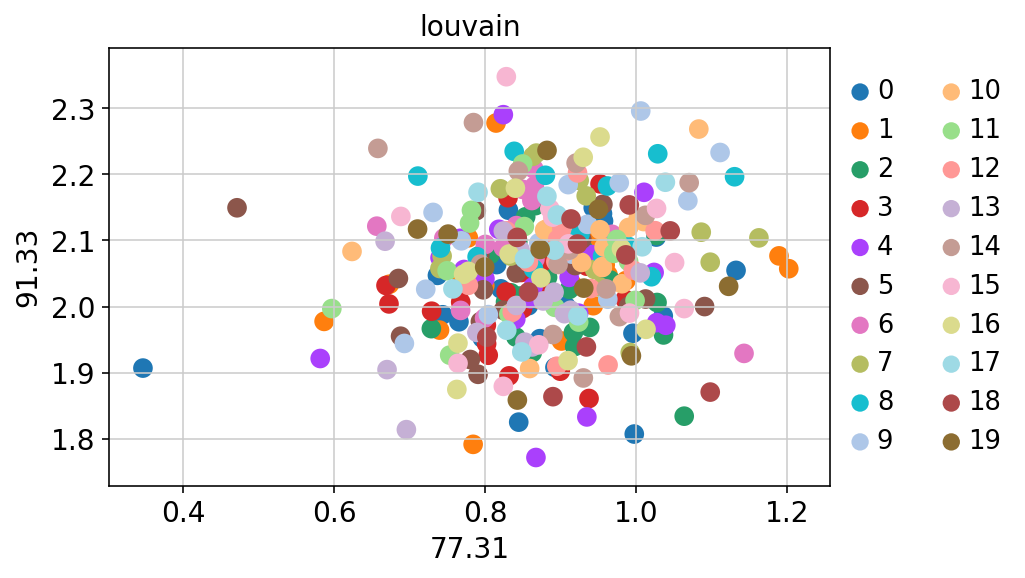

In [154]:
sc.pl.scatter(a_cls2,x='77.31',y='91.33',color='louvain',palette=sc.pl.palettes.vega_20_scanpy)

In [155]:
sc.tl.rank_genes_groups(a_cls2,groupby='louvain')

ranking genes
    finished (0:00:00)


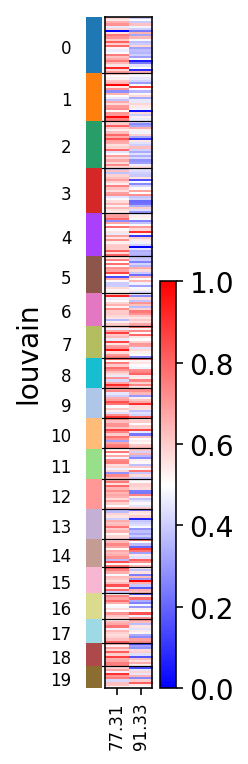

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 0.6, 0, 0.2])

In [156]:
# sc.pl.rank_genes_groups_heatmap(a_cls2)
sc.pl.heatmap(a_cls2, ['77.31','91.33'],groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False)


In [54]:
a.obs['cls_sub'] = np.array(a.obs['SIMS-Cluster'])

In [81]:
a_cls2.obs['spatial_x'] = a_cls2.obsm['spatial'][:,0]
a_cls2.obs['spatial_y'] = a_cls2.obsm['spatial'][:,1]

In [93]:
sub_cls2 = np.array(a_cls2.obs['louvain'])
sub_cls2[sub_cls2=='3']='s0'
sub_cls2[sub_cls2=='4']='s0'
sub_cls2[sub_cls2=='5']='s0'

sub_cls2[sub_cls2=='0']='s1'
sub_cls2[sub_cls2=='1']='s1'
sub_cls2[sub_cls2=='2']='s1'
sub_cls2[sub_cls2=='6']='s1'

a_cls2.obs['cls2'] = sub_cls2

In [195]:
# FB（左）：
s0_list = [3,8,10,12,13,16,17]
# EC（中）：
s1_list = [0,2,4,11,]
# IC（右）：
s2_list = [1,5,6,7,15,18,19]
# 不确定：
s3_list = [9,14]

In [196]:
sub_cls2 = np.array(a_cls2.obs['louvain'])
# s0:
for c in s0_list:
    sub_cls2[sub_cls2==str(c)]='s0'
for c in s1_list:
    sub_cls2[sub_cls2==str(c)]='s1'
for c in s2_list:
    sub_cls2[sub_cls2==str(c)]='s2'
for c in s3_list:
    sub_cls2[sub_cls2==str(c)]='s0'
a_cls2.obs['cls2'] = sub_cls2

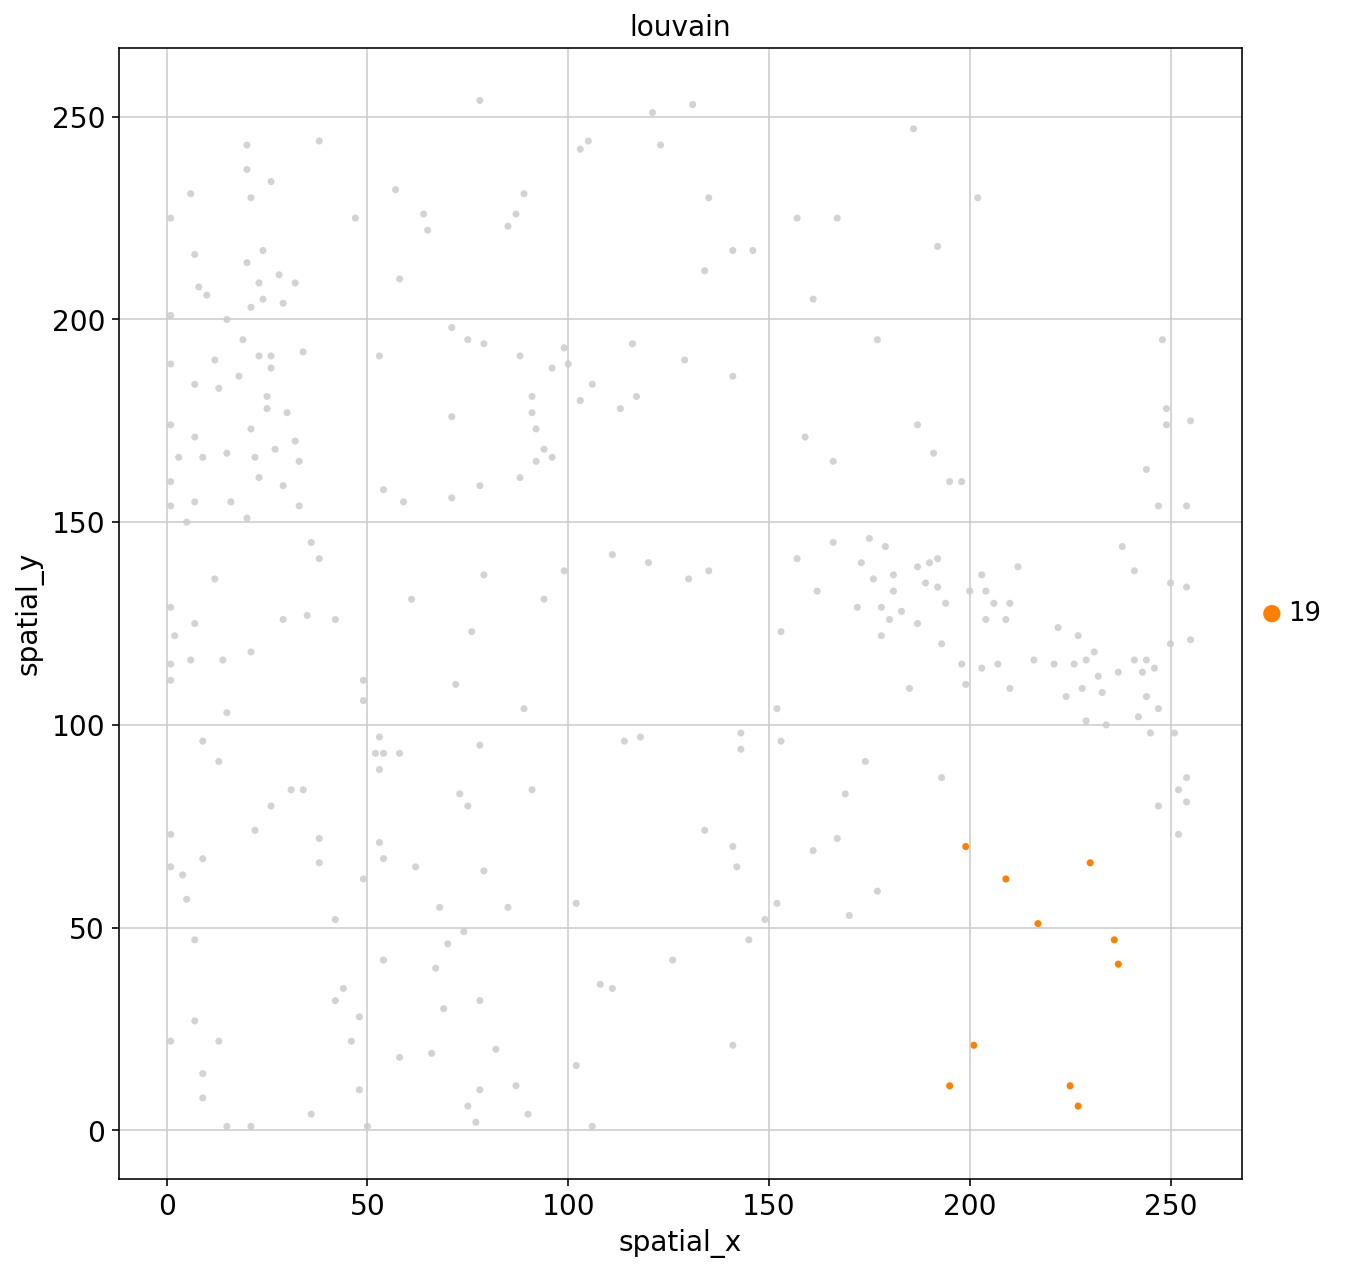

In [194]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.scatter(a_cls2,x='spatial_x',y='spatial_y',size=50,color='louvain',palette=cmp_5,ax=ax,groups='19')

... storing 'cls2' as categorical


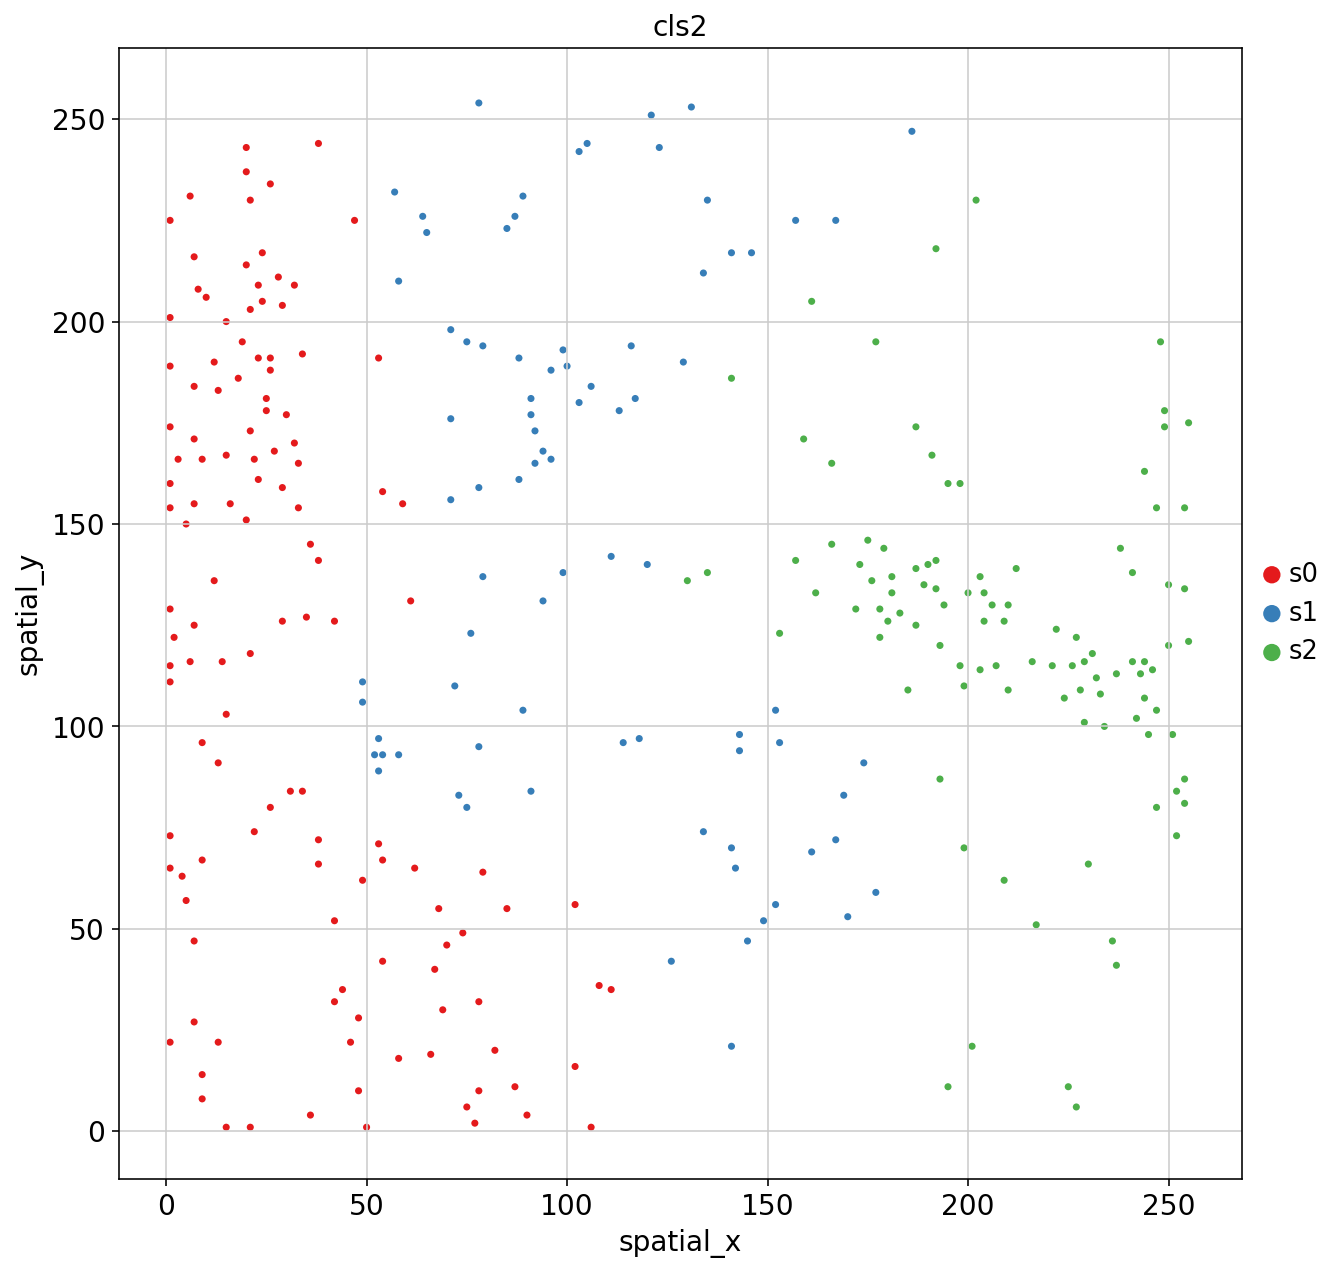

In [197]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.scatter(a_cls2,x='spatial_x',y='spatial_y',size=50,color='cls2',palette=cmp_5,ax=ax)

In [97]:
a_tmp = a.copy()

In [200]:
original_cls = np.array(a_tmp.obs['SIMS-Cluster'])
# a_tmp.obs['SIMS-Cluster']
original_cls[original_cls=='2'] = a_cls2.obs['cls2']
original_cls[original_cls=='s0'] = '1'
original_cls[original_cls=='s1'] = '5'
original_cls[original_cls=='s2'] = '2'



In [201]:
np.unique(original_cls)

array(['1', '2', '3', '4', '5'], dtype=object)

In [202]:
a.obs['cls_sub'] = original_cls

In [199]:
np.unique(a.obs['SIMS-Cluster'])

array(['1', '2', '3', '4'], dtype=object)

In [214]:
a.obs['cls_sub'] = cur_cls

In [216]:
# '1','2','5','3','4'
# a.obs.cls_sub.cat.reorder_categories(['1','2','5','3','4'], inplace=True) 
# cur_cls = np.array(a.obs['cls_sub'])
a.obs['cls_sub'][cur_cls=='3']='4'
a.obs['cls_sub'][cur_cls=='4']='5'
a.obs['cls_sub'][cur_cls=='5']='3'
# a.obs['cls_sub'][cur_cls=='4']='3'



# '1':
# '2':

/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [219]:
a.obs['cls_sub'] = np.array(a.obs['cls_sub']).astype('str')
a.obs['cls_sub'] = a.obs['cls_sub'].astype('category')

In [215]:
cmp_5 = palettable.colorbrewer.qualitative.Set1_5.mpl_colors
# 0:红
# 1:蓝
# 2:绿
# 3:紫
# 4:黄

array(['1', '2', '3', '4', '5'], dtype=object)

In [221]:
cur_cmp = [cmp_5[4],cmp_5[2],cmp_5[3],cmp_5[1],cmp_5[0]]

In [222]:
a.uns['cls_sub_colors'] = cur_cmp

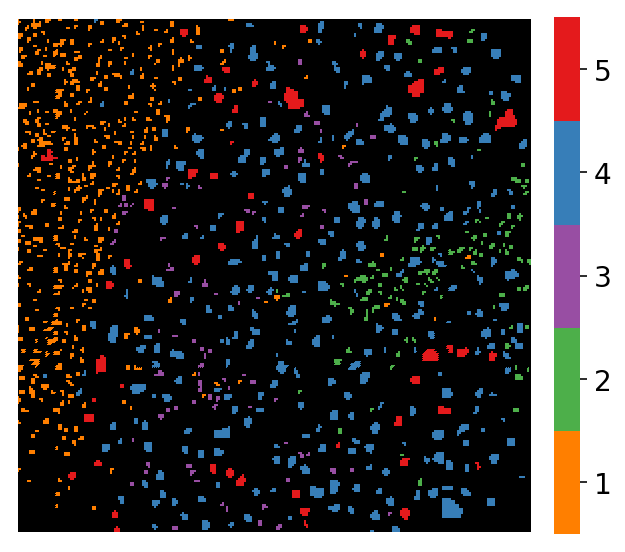

In [223]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[0,1,2,3,4])


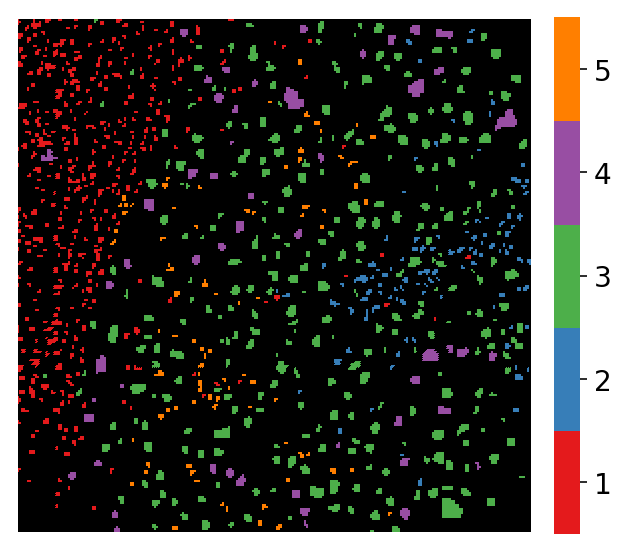

In [203]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[0,1,2,3,4])


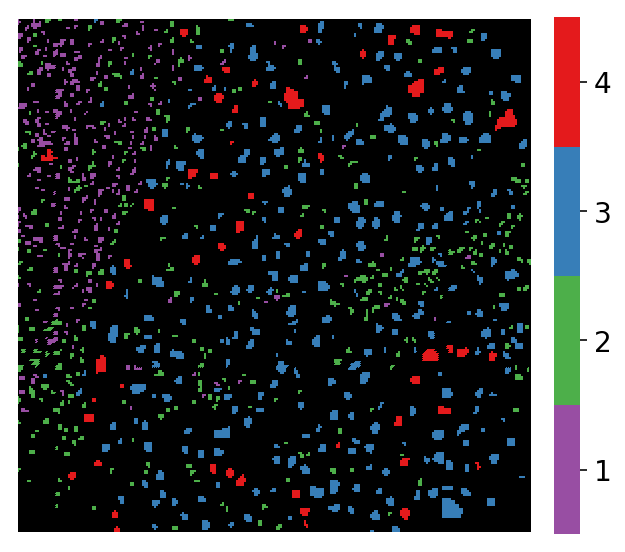

In [198]:
plot_label_image(a.obs['SIMS-Cluster'],a.uns['SIMS-Cluster_colors'],mask=[0,1,2,3,4])


In [112]:
a.uns['cls_sub_colors'] = cmp_5

... storing 'cls2' as categorical


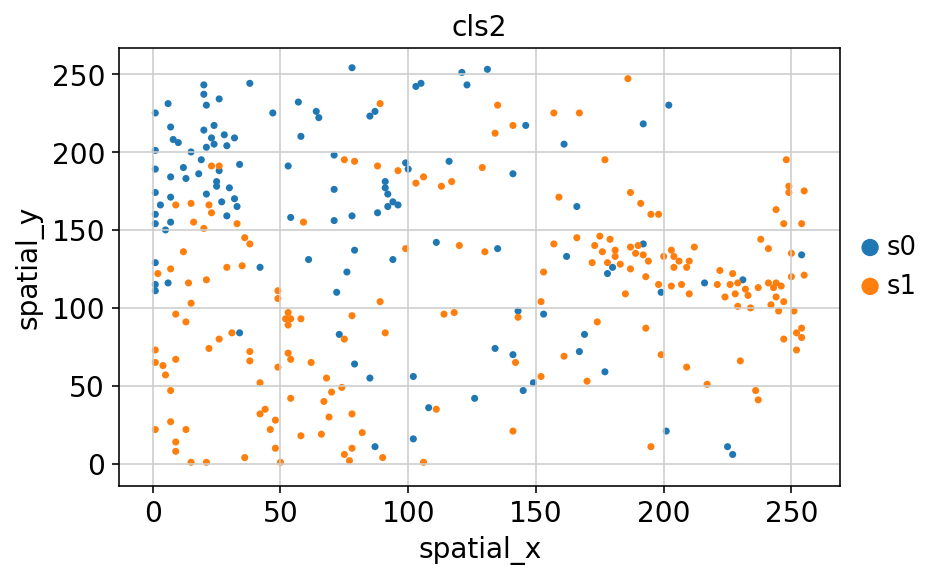

In [70]:
sc.pl.scatter(a_cls2,x='spatial_x',y='spatial_y',size=50,color='cls2')

In [26]:
import sklearn
cls2_sub = sklearn.cluster.KMeans(2).fit_predict(a_cls2.X)

AttributeError: module 'sklearn' has no attribute 'cluster'

In [20]:
a_cls2.obs['77.31'] = a_cls2

View of AnnData object with n_obs × n_vars = 311 × 228 
    obs: 'SIMS-Cluster', 'fibro_dist', 'fibro_zonation'
    uns: 'SIMS-Cluster_colors', 'dendrogram_SIMS-Cluster', 'fibro_zonation_colors', 'rank_genes_groups', 'rep_list'
    obsm: 'X_umap', 'X_pca', 'spatial'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

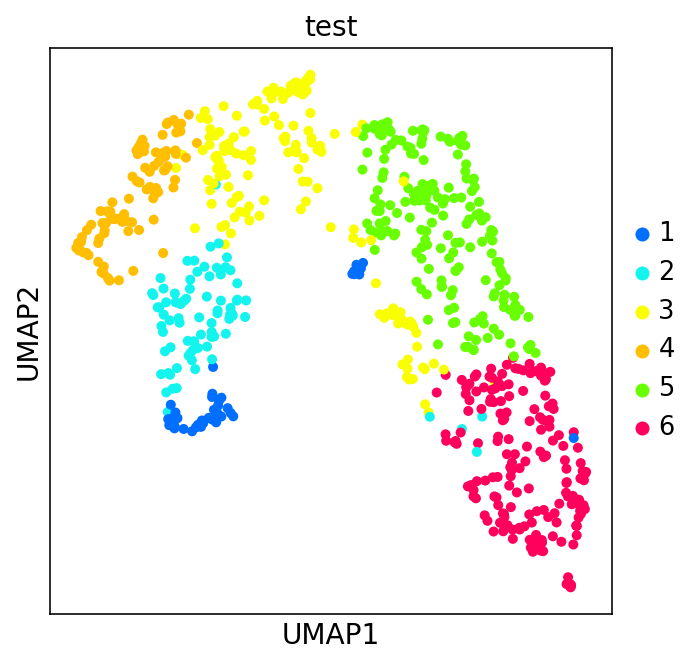

In [35]:
sc.settings.figdir = 'figures/Fig4_rep0/c6/'
save_umap = '_c6.png'
fig,ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(a,color=['test'],ax=ax,save=save_umap,s=100)
# sc.pl.umap(a,color=['cls_5_reorder'],ax=ax,save=None,s=100)


## visual cell typing

In [321]:
sc.pp.neighbors(a)
sc.tl.louvain(a)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

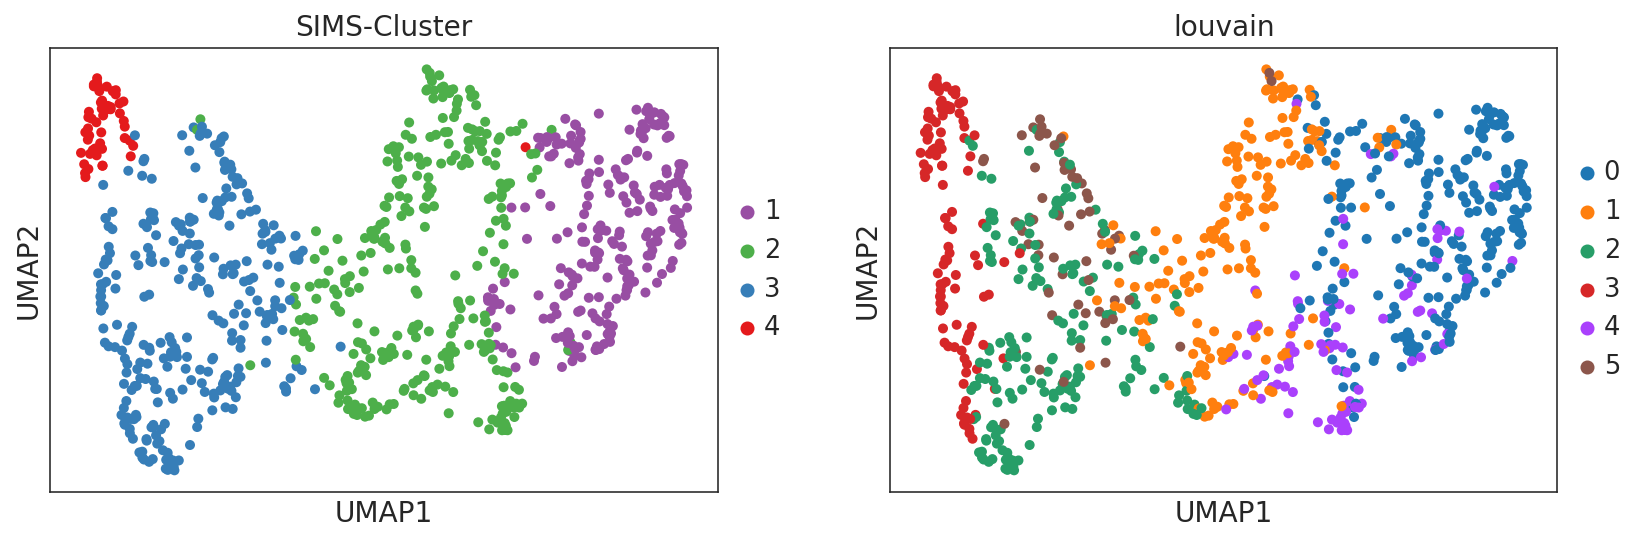

In [322]:
sc.pl.umap(a,color=['SIMS-Cluster','louvain'],save=None,s=100)

In [325]:
1+1

2

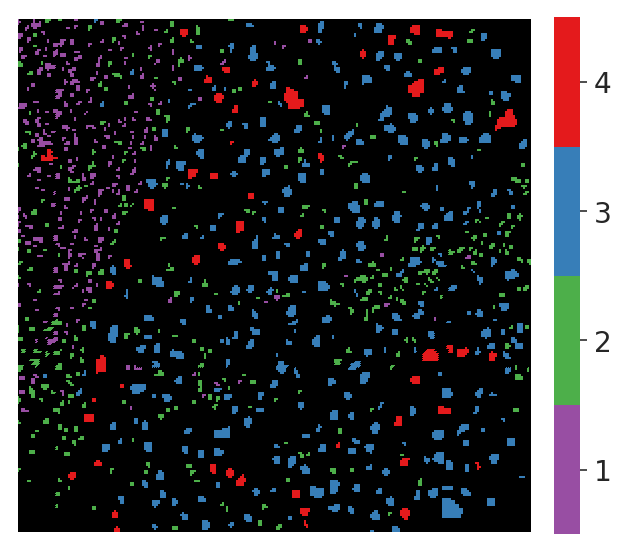

In [318]:
plot_label_image(a.obs['SIMS-Cluster'],a.uns['SIMS-Cluster_colors'],mask=[0,1,2,3,4],save=None)


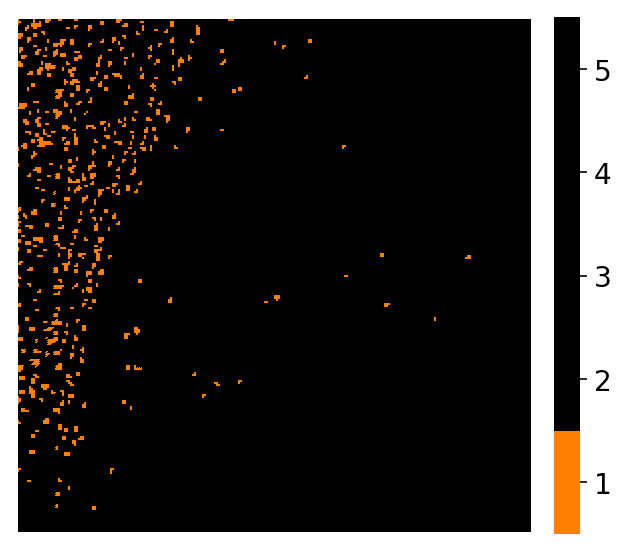

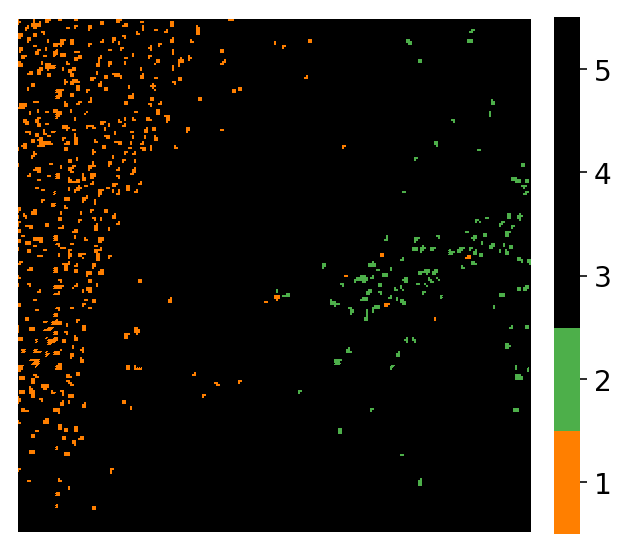

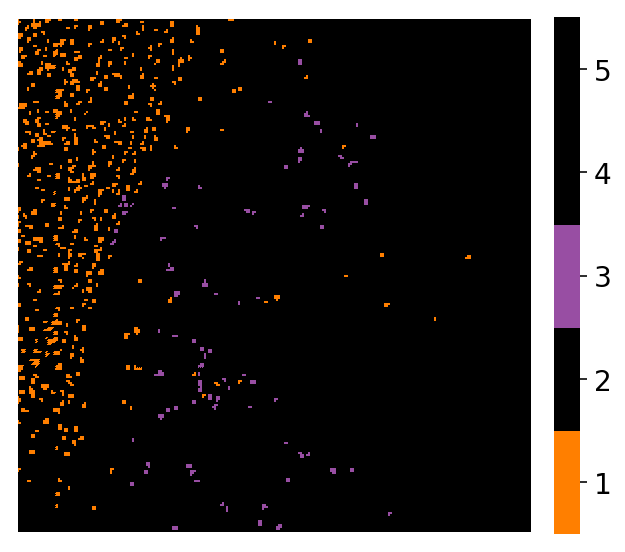

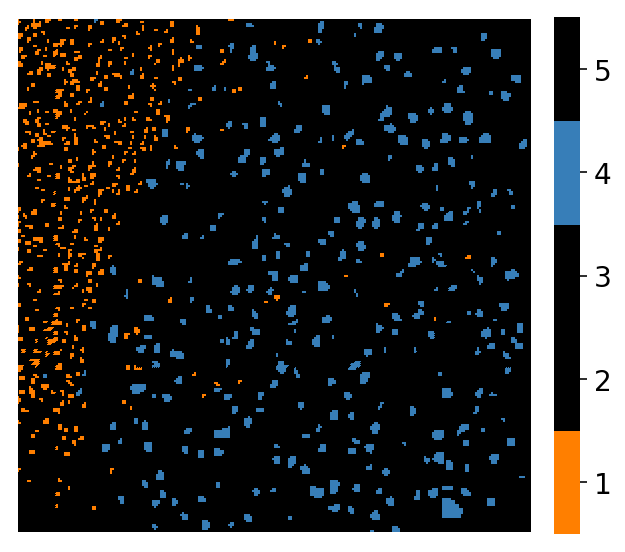

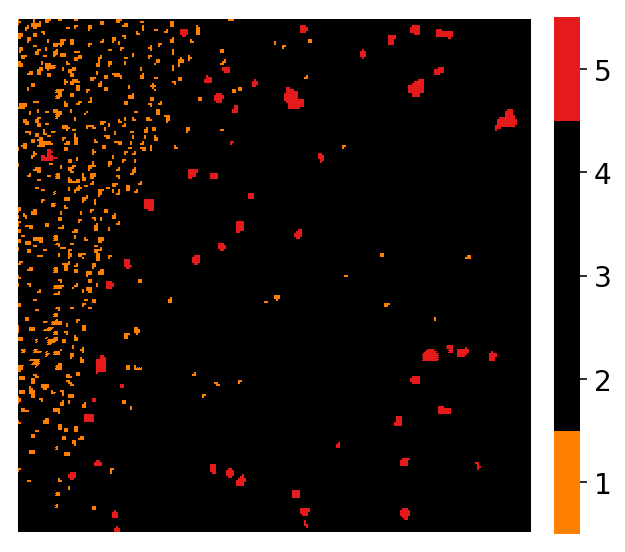

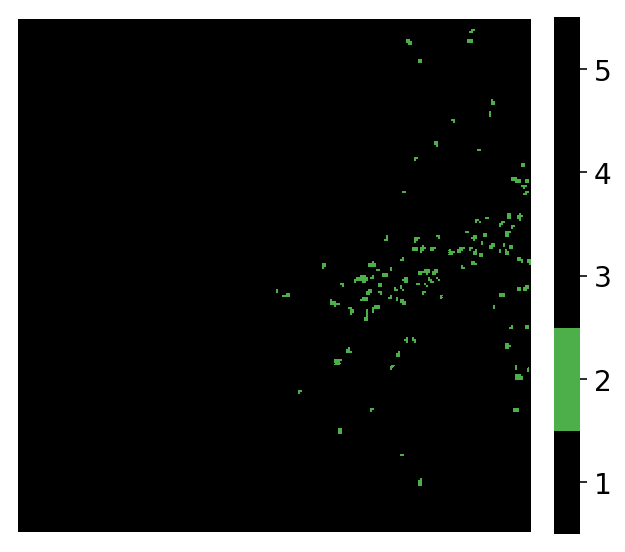

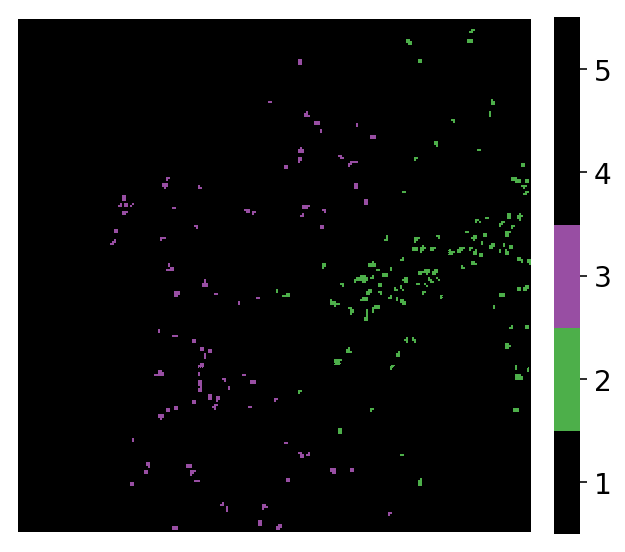

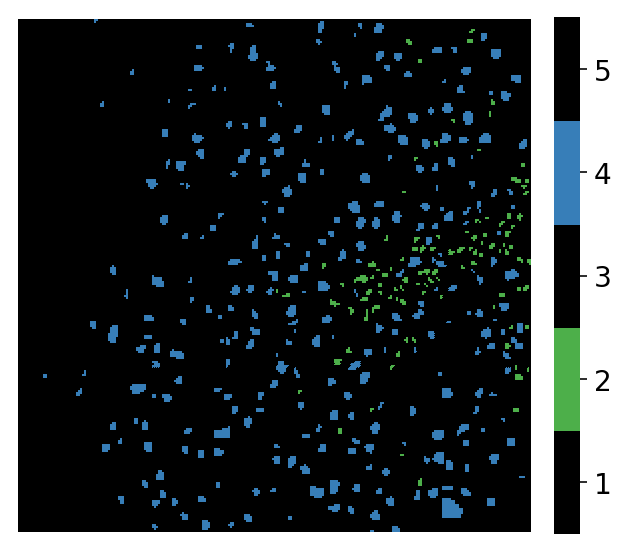

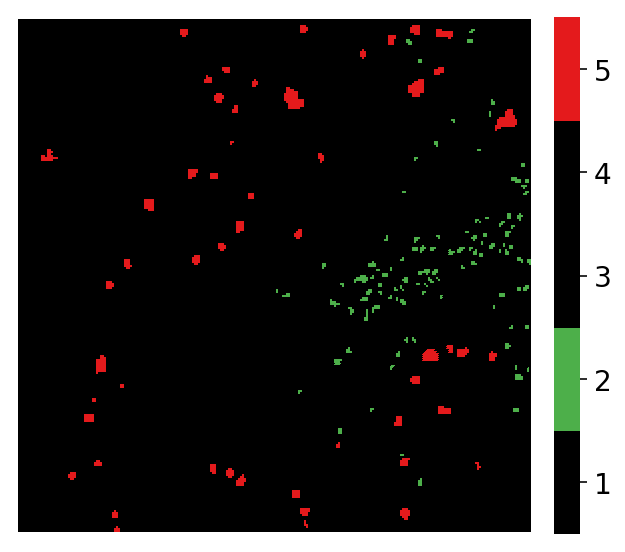

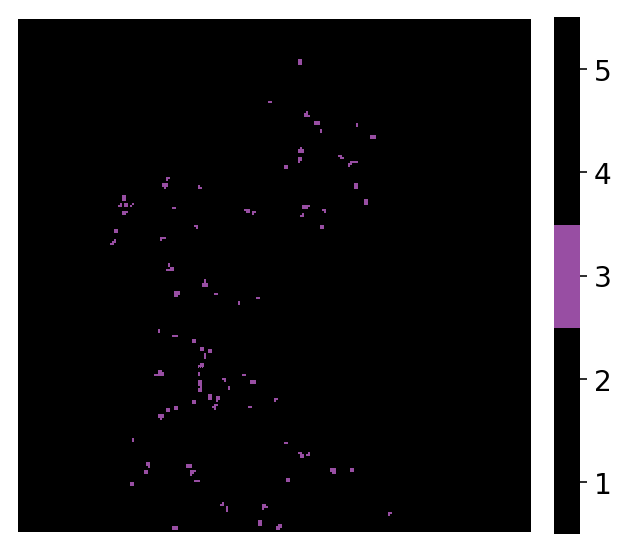

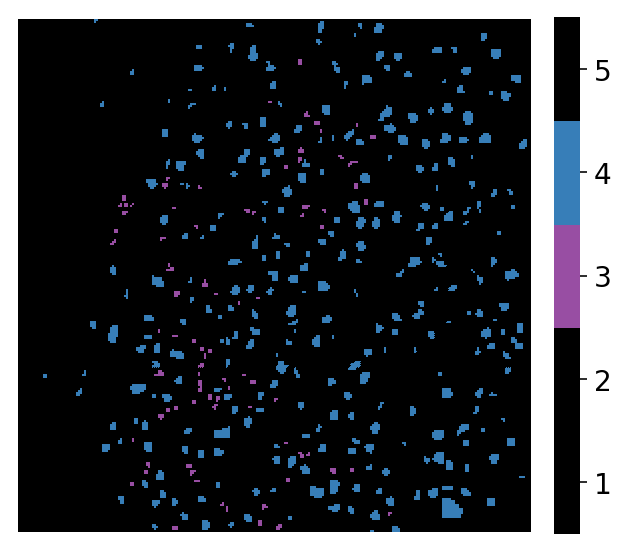

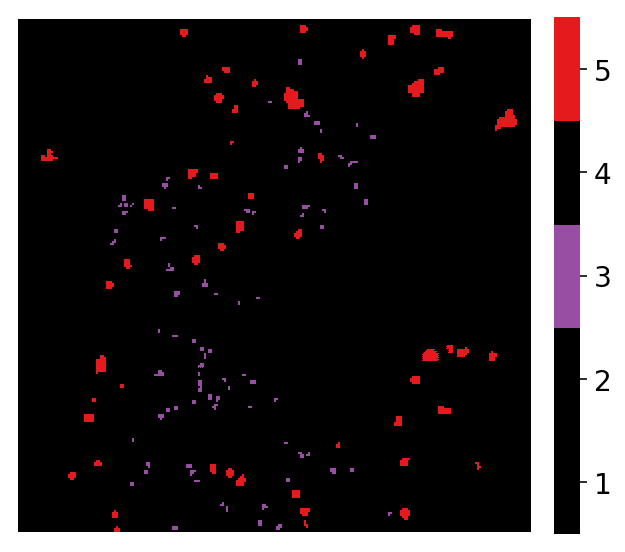

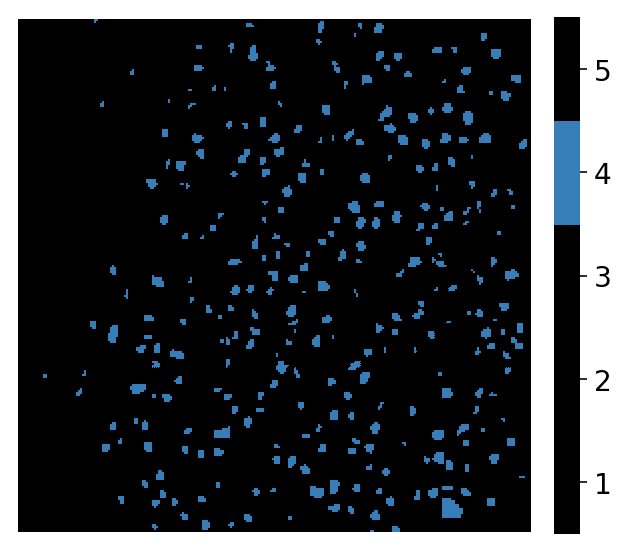

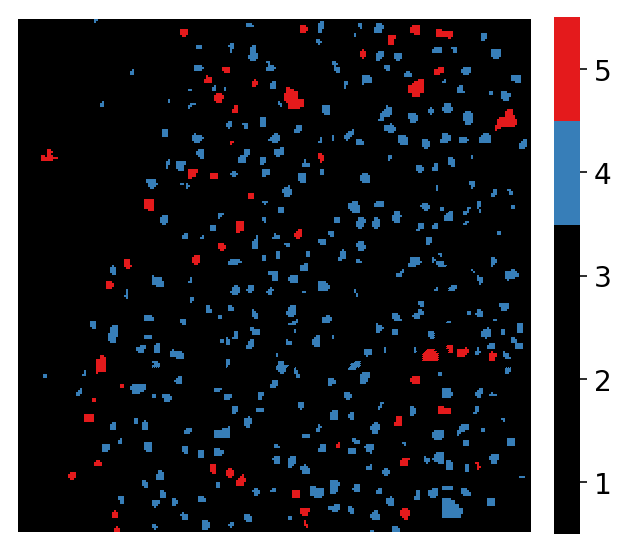

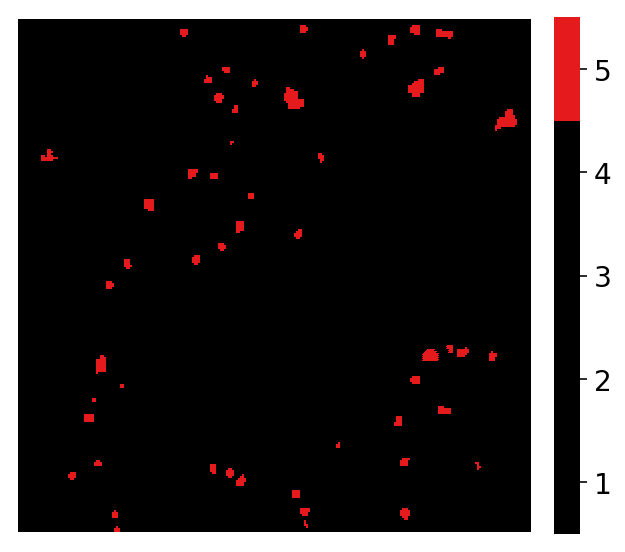

In [231]:
# 需要1～4；分别；4红其他白
save_cluster_image = '/home/yzy/ipynbs/figures/Fig4/c5/cluster_image/cluster_image_{0}_c5.pdf'

for i in range(5):
    for j in range(i,5):
        cur_save = save_cluster_image.format(str(i)+str(j))
        plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[i,j],save=cur_save)
    


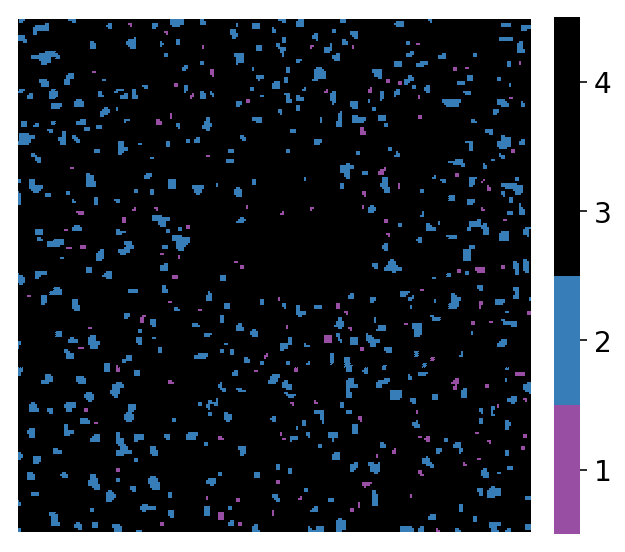

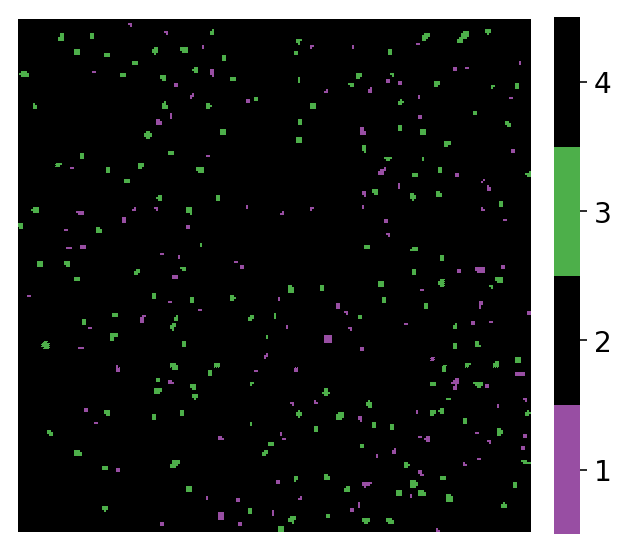

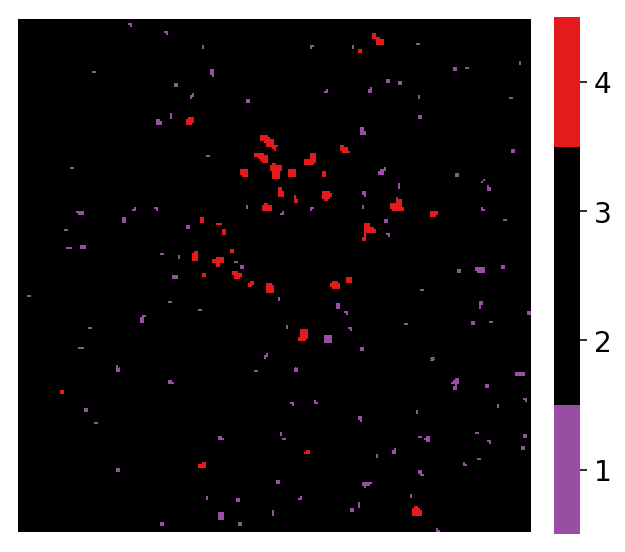

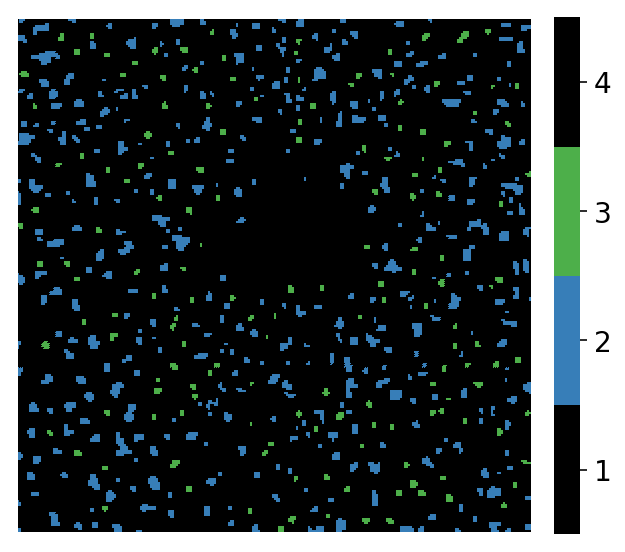

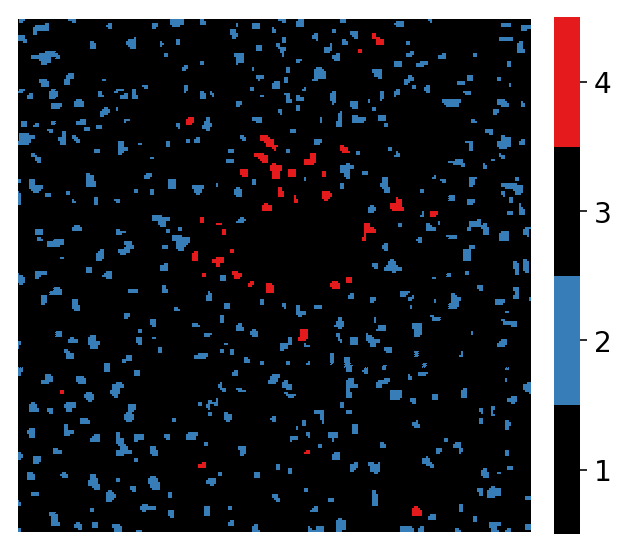

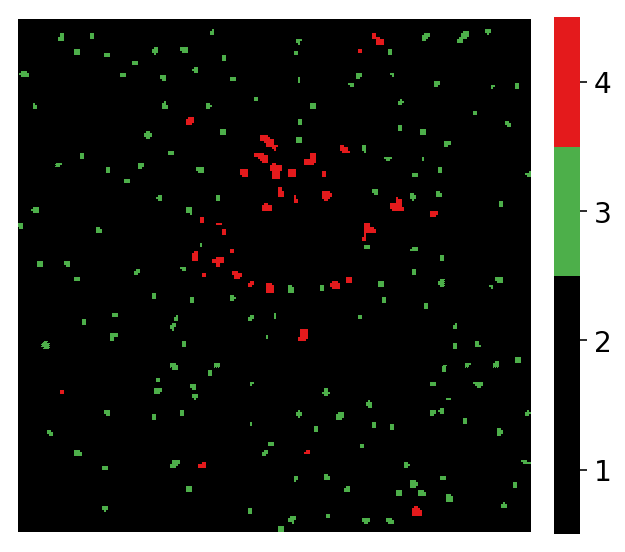

In [65]:
for i in range(4):
    for j in range(i+1,4):
        cur_save = save_cluster_image.format(str(i)+'-'+str(j))
        plot_label_image(a.obs['cls_4'],a.uns['cls_4_colors'],mask=[i,j],save=cur_save)
        
        

In [36]:
a

AnnData object with n_obs × n_vars = 716 × 231 
    obs: 'cls_5', 'cls_5_pca', 'cls_8_pca', 'cls_4', 'leiden', 'cls_5_reorder', 'fibro_dist', 'fibro_dist_mum', 'test'
    uns: 'cls_4_colors', 'cls_5_colors', 'cls_5_pca_colors', 'cls_5_reorder_colors', 'cls_8_pca_colors', 'leiden', 'leiden_colors', 'neighbors', 'rep_list', 'umap', 'test_colors'
    obsm: 'X_umap', 'cls_4_rep', 'cls_5_pca_rep', 'cls_5_rep', 'cls_8_pca_rep', 'spatial'

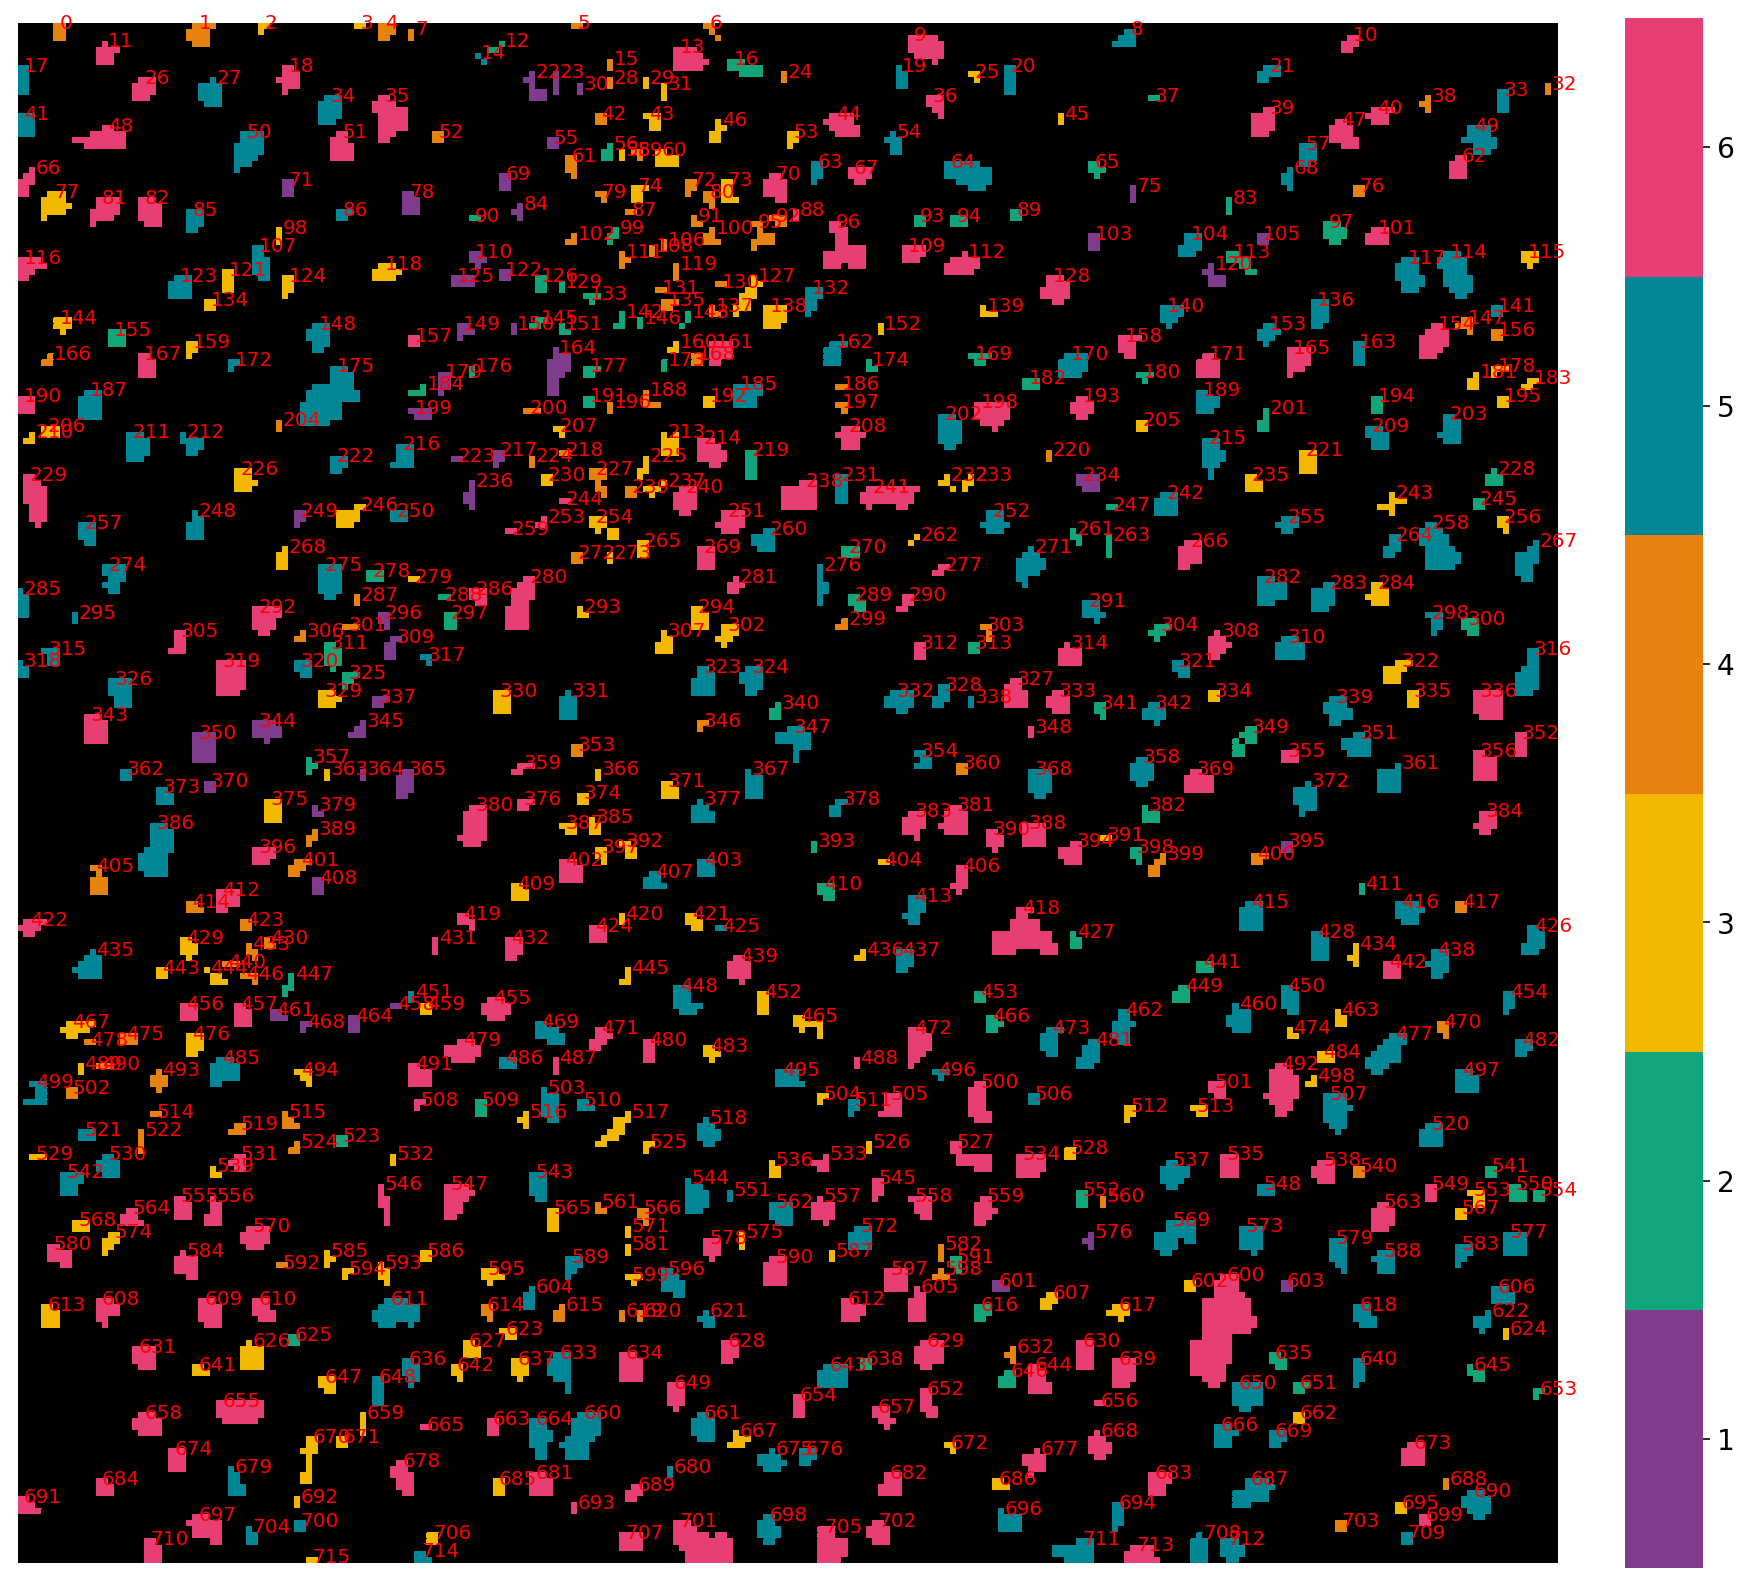

In [37]:
plot_label_image(a.obs['cls_5_reorder'],a.uns['cls_5_reorder_colors'],mask=range(6),save=None,anno=True,figsize=(15,15))


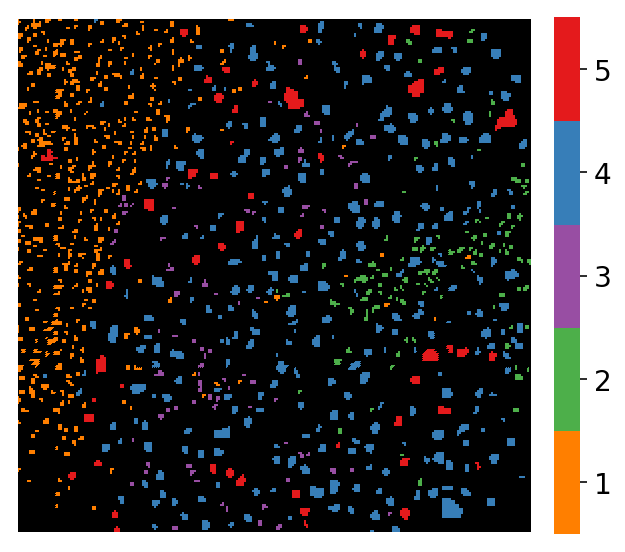

In [233]:
# 所有四色
# tmp_cmp = ['w']*3
# tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig4/c5/cluster_image/cluster_image_all.pdf'
# plot_label_image(a.obs['cls_4'],a.uns['cls_4_colors'],mask=[0,1,2,3],save=cur_save)
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[0,1,2,3,4],save=cur_save)


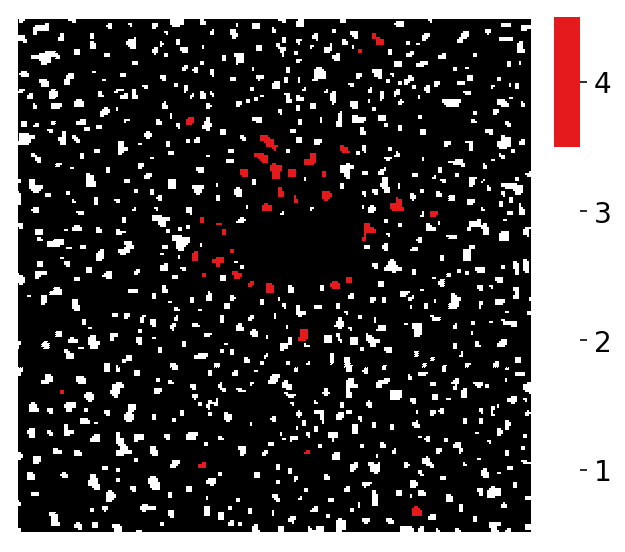

In [68]:
# 4红其他白
tmp_cmp = ['w']*3
tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig2/c4/cluster_image/cluster_image_nearfar.pdf'
plot_label_image(a.obs['cls_4'],tmp_cmp,mask=[0,1,2,3],save=cur_save)


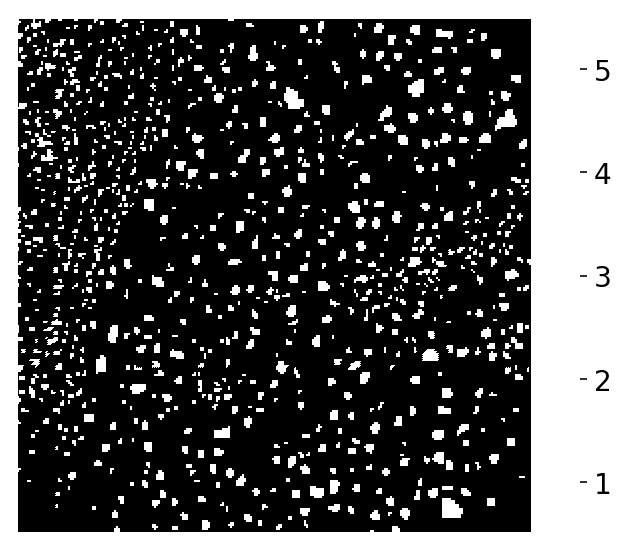

In [234]:
# 全白
tmp_cmp = ['w']*5
# tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig4/c5/cluster_image/cluster_image_cut.pdf'
plot_label_image(a.obs['cls_sub'],tmp_cmp,mask=[0,1,2,3,4],save=cur_save)


## differential expression heatmap

In [235]:
sc.tl.rank_genes_groups(a,groupby='cls_sub',method='t-test')

ranking genes
    finished (0:00:00)


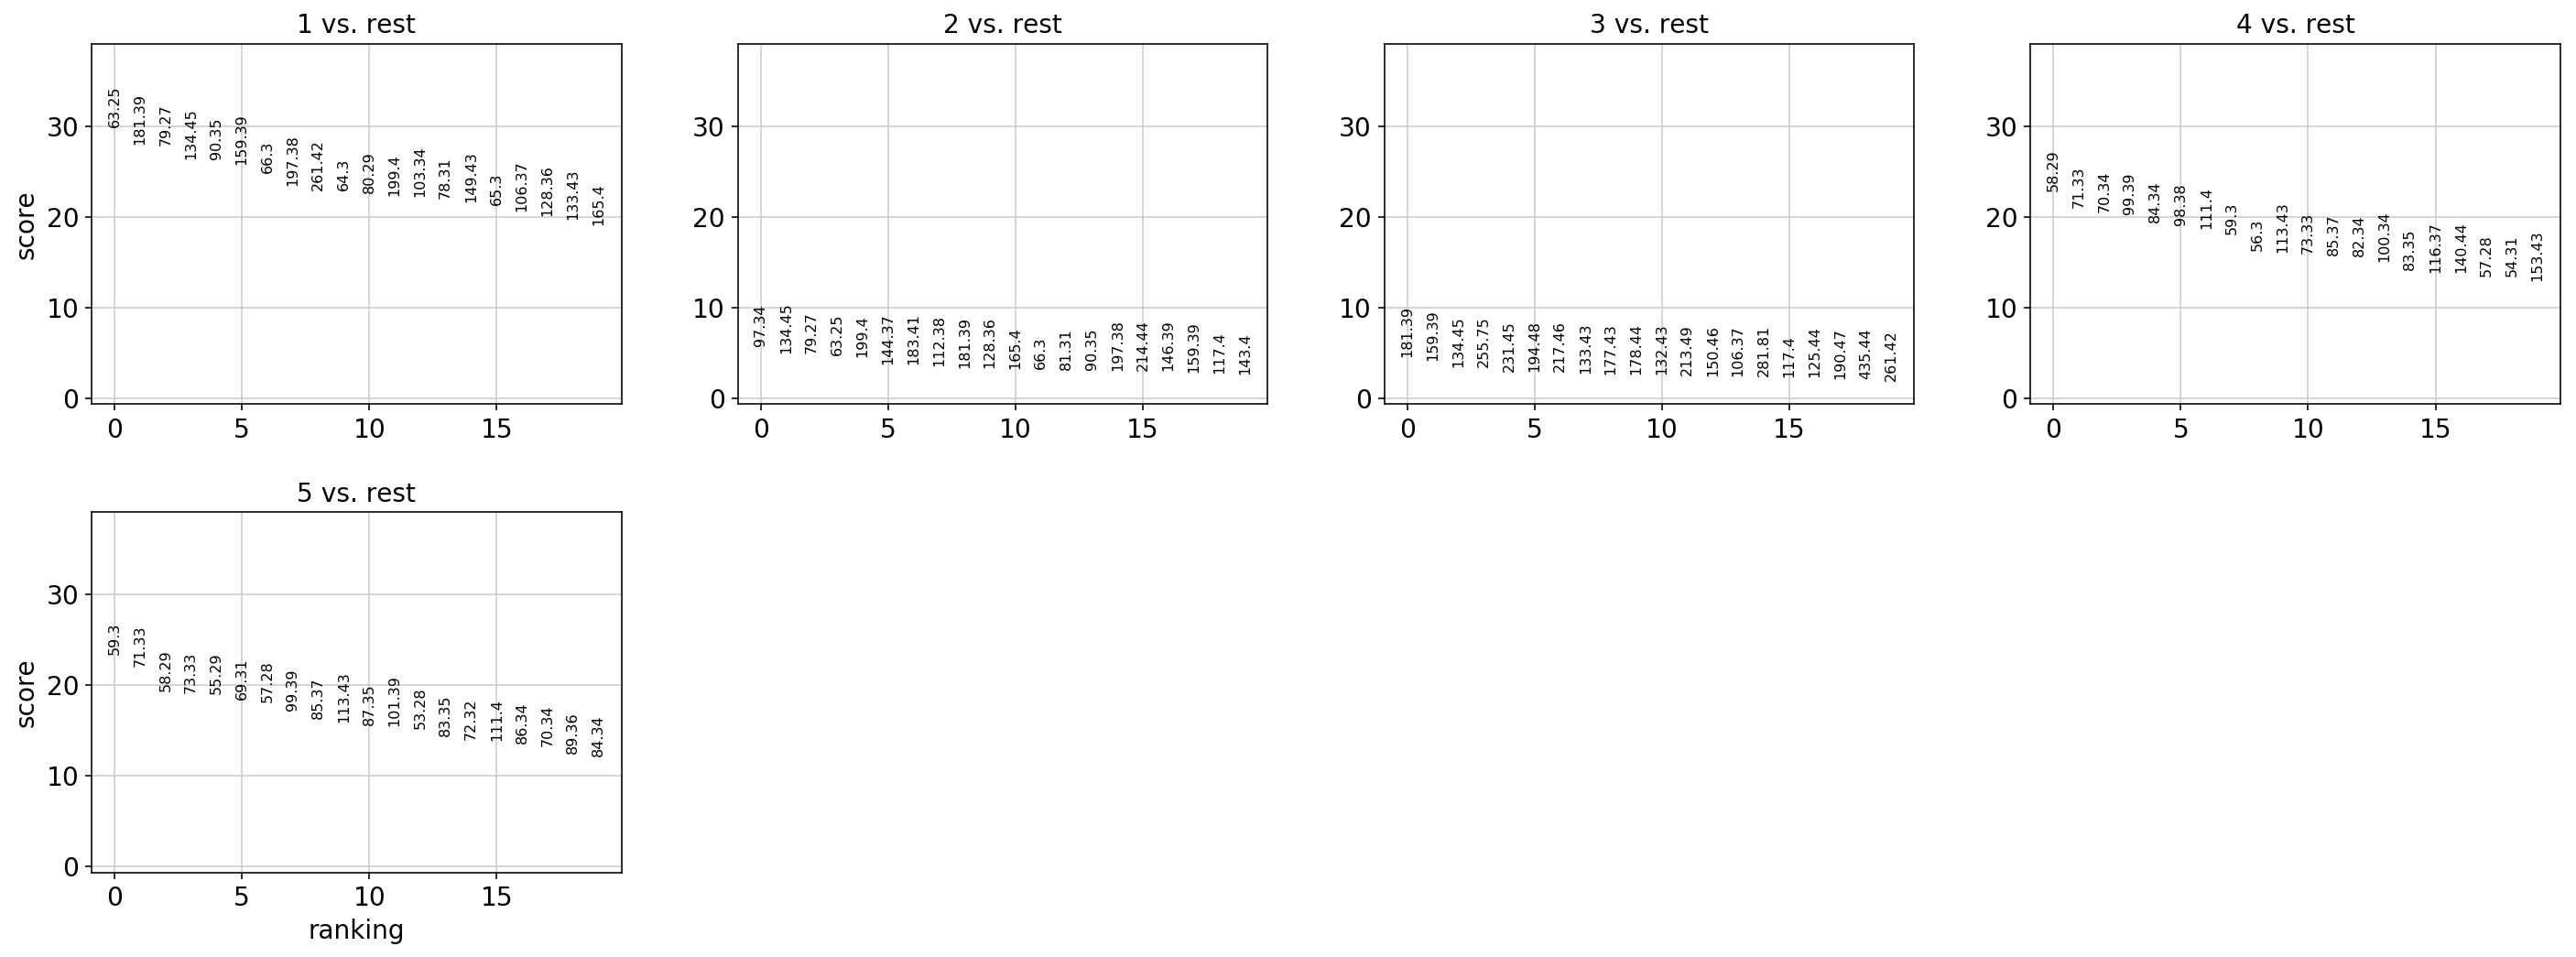

In [236]:
sc.pl.rank_genes_groups(a)

In [273]:
# 3 vs 1:91.36,75.32,66.32,65.31
# 1 vs 3:60.26,77.31,137.43,76.29

marker_list =[
#     Fib
    107.35,91.33,63.25,
    #     IC
#     181.42,144.41,128.39,91.36,
    181.39,97.34,79.27,112.38,
    #     EC:
#     60.26,77.31,137.43,
    77.31,76.31,
    
    
#     Hepa
    255.75,279.79,281.81,
    #     Hepa87+
#     221.56,87.36,101.41,59.31,71.34,
#     58.30,69.32,59.31,71.34,101.41,87.36
    55.29,57.28,69.31

]
marker_list = np.array(marker_list).astype('str')

In [263]:
a_tmp = a.copy()

In [269]:
EC_matter = ['77.31','76.31','60.28']
a_tmp[a_tmp.obs['cls_sub']=='3',EC_matter].X = a_tmp[a_tmp.obs['cls_sub']=='3',EC_matter].X*1.05

In [267]:
FA_matter = ['255.75','279.79','281.81']
a_tmp[a_tmp.obs['cls_sub']=='3',FA_matter].X = a_tmp[a_tmp.obs['cls_sub']=='3',FA_matter].X/1.2

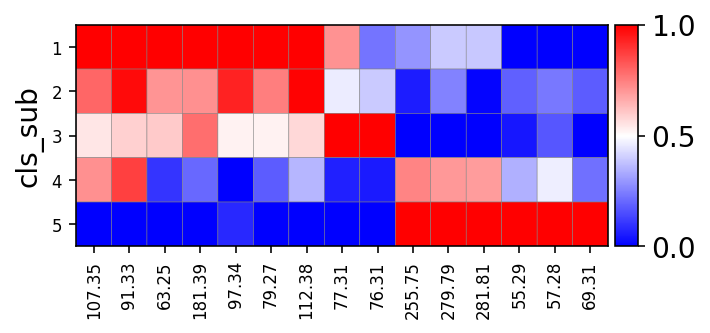

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[4.8, 0, 0.2])

In [276]:
sc.settings.figdir = 'figures/Fig4/c5/diff/'
save_heatmap = '_c5.pdf'
sc.pl.matrixplot(a_tmp,marker_list,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=save_heatmap)


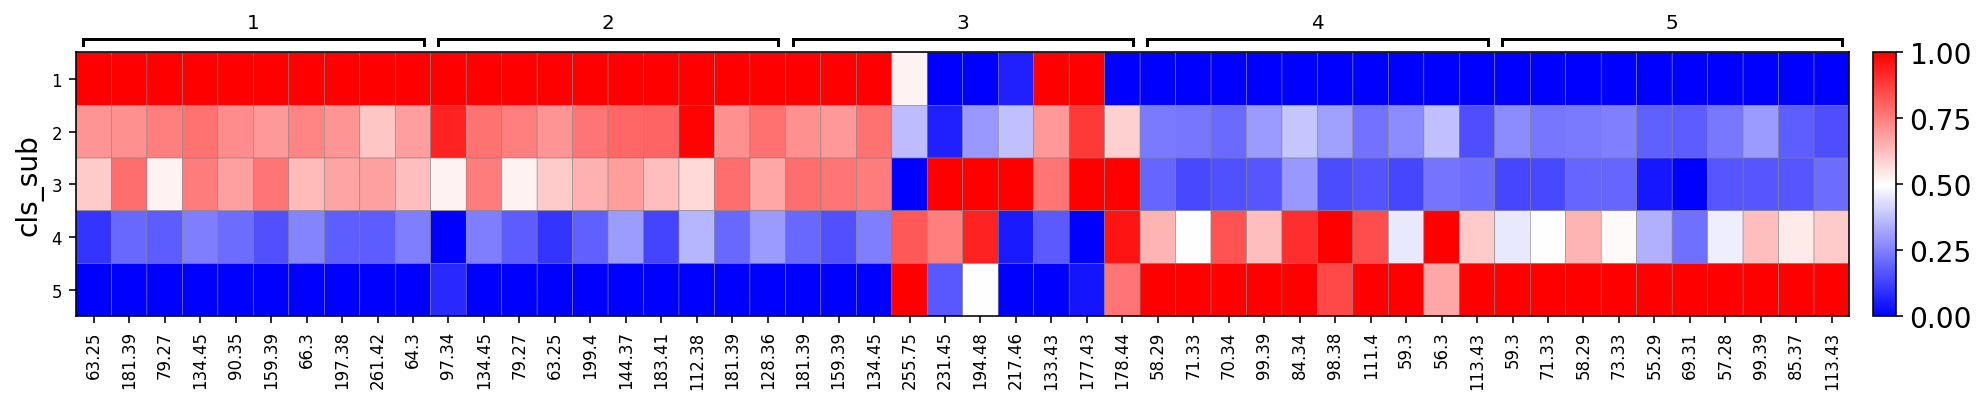

In [244]:
sc.pl.rank_genes_groups_matrixplot(a_tmp,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


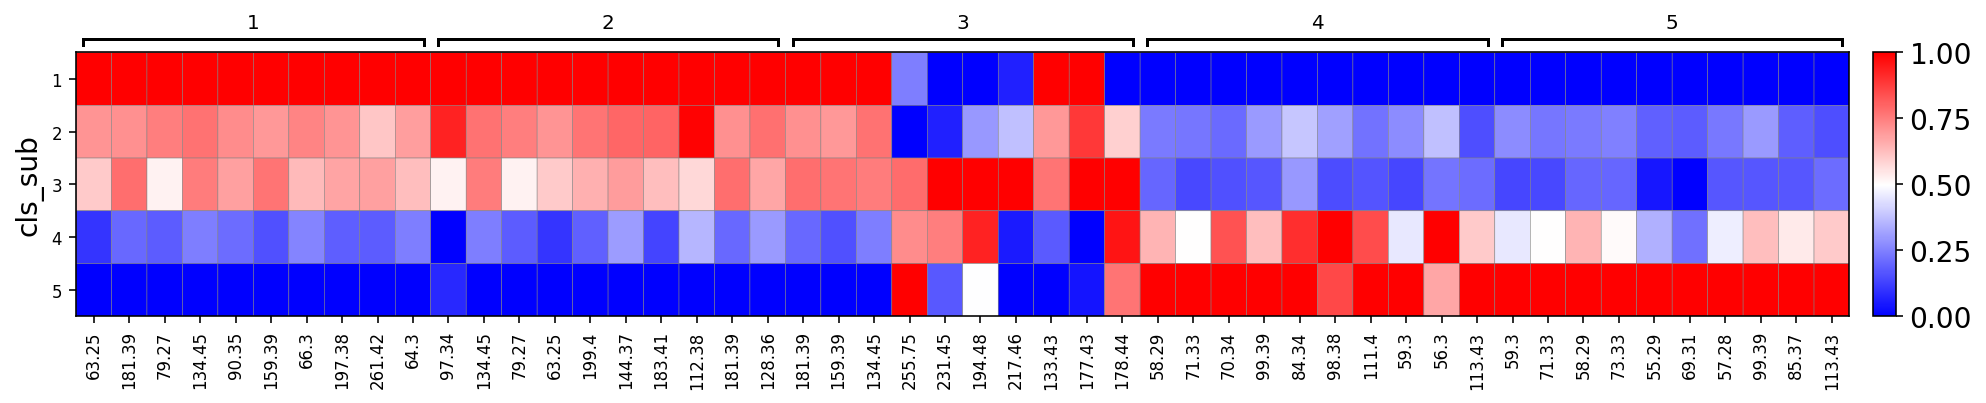

In [239]:
sc.pl.rank_genes_groups_matrixplot(a,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


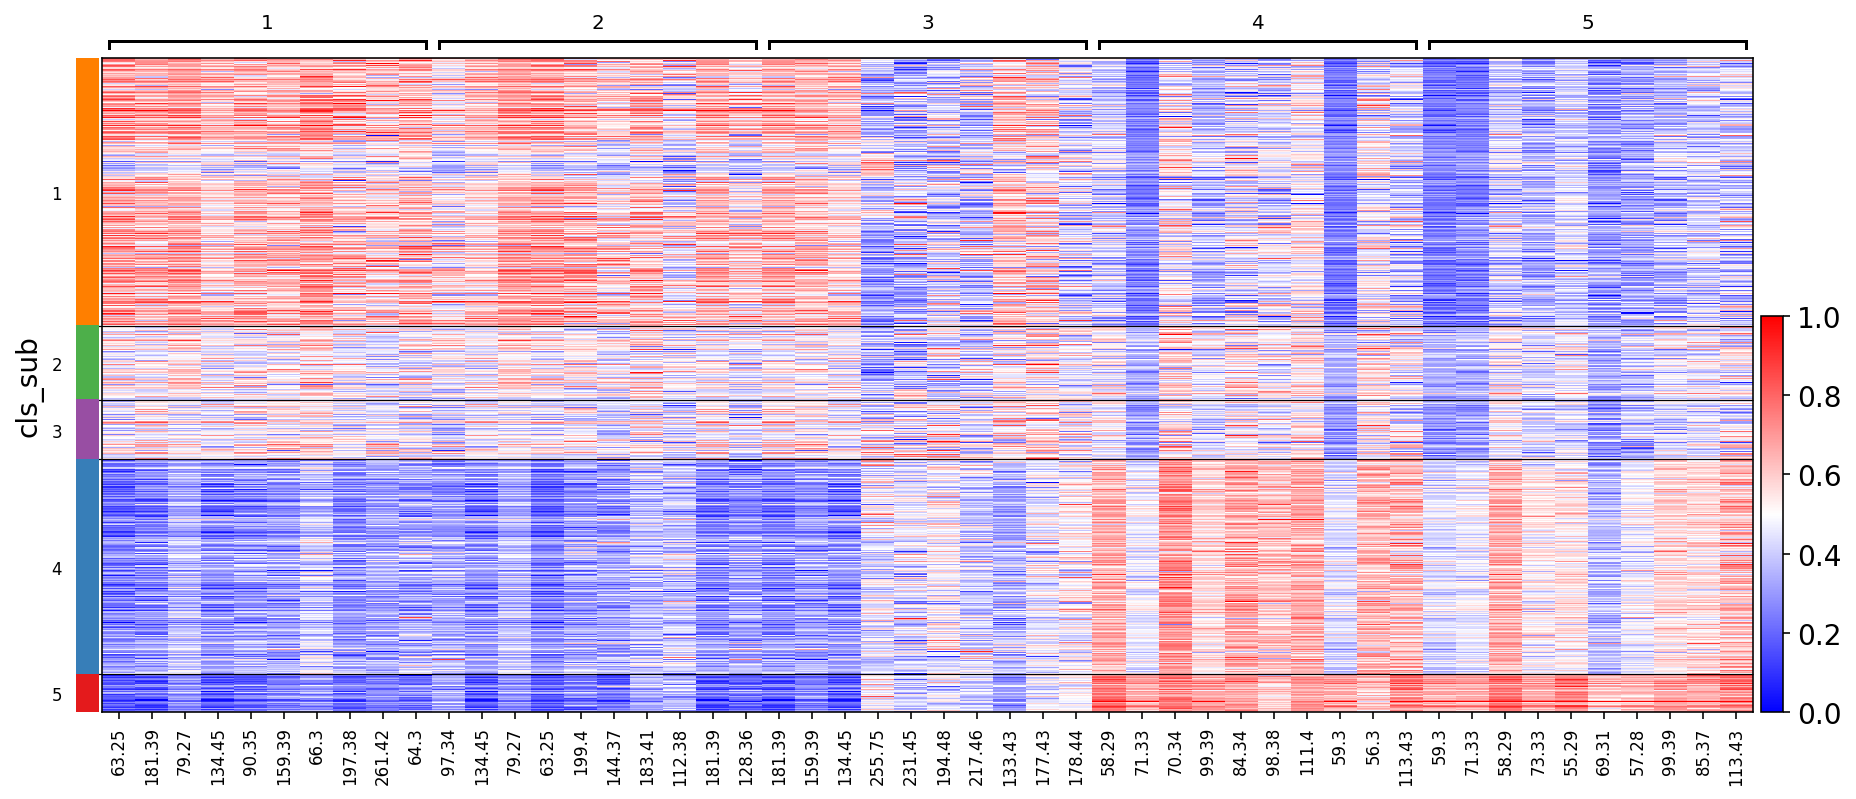

In [238]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [1]:
1+1

2

In [154]:
# 3 vs 1:91.36,75.32,66.32,65.31
# 1 vs 3:60.26,77.31,137.43,76.29

marker_list =[
    #     IC
    181.42,144.41,128.39,91.36,
    #     EC:
    60.26,77.31,137.43,

#     Hepa
    253.79,255.83,281.87,
    #     Hepa87+
#     221.56,87.36,101.41,59.31,71.34,
    58.30,69.32,59.31,71.34,101.41,87.36


]
marker_list = np.array(marker_list).astype('str')

Index(['50.27', '50.83', '51.29', '52.29', '53.29', '54.32', '55.3', '56.31',
       '57.29', '58.3',
       ...
       '409.57', '419.54', '425.58', '439.56', '441.52', '443.57', '447.59',
       '457.52', '466.02', '487.6'],
      dtype='object', name='index', length=244)

In [103]:
a_tmp = a.copy()

In [149]:
# a_tmp.obs.cls_4.cat.reorder_categories(['3','1','2','4'], inplace=True) 
a_tmp.uns['cls_4_colors'] = [cur_cmp[2],cur_cmp[0],cur_cmp[1],cur_cmp[3]]

In [105]:
a_tmp.obs.cls_4.cat.categories
['3','1','2','4']

Index(['1', '2', '3', '4'], dtype='object')

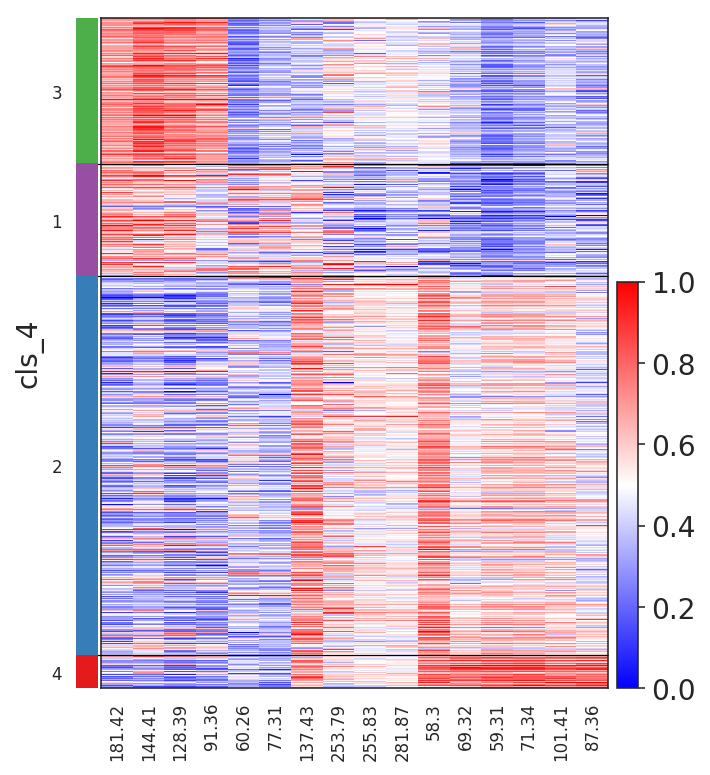

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 4.8, 0, 0.2])

In [155]:
sc.settings.figdir = 'figures/Fig2/c4/diff/'
save_heatmap = '_c4.pdf'
sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=save_heatmap)
# sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


## Hepa Fib dist

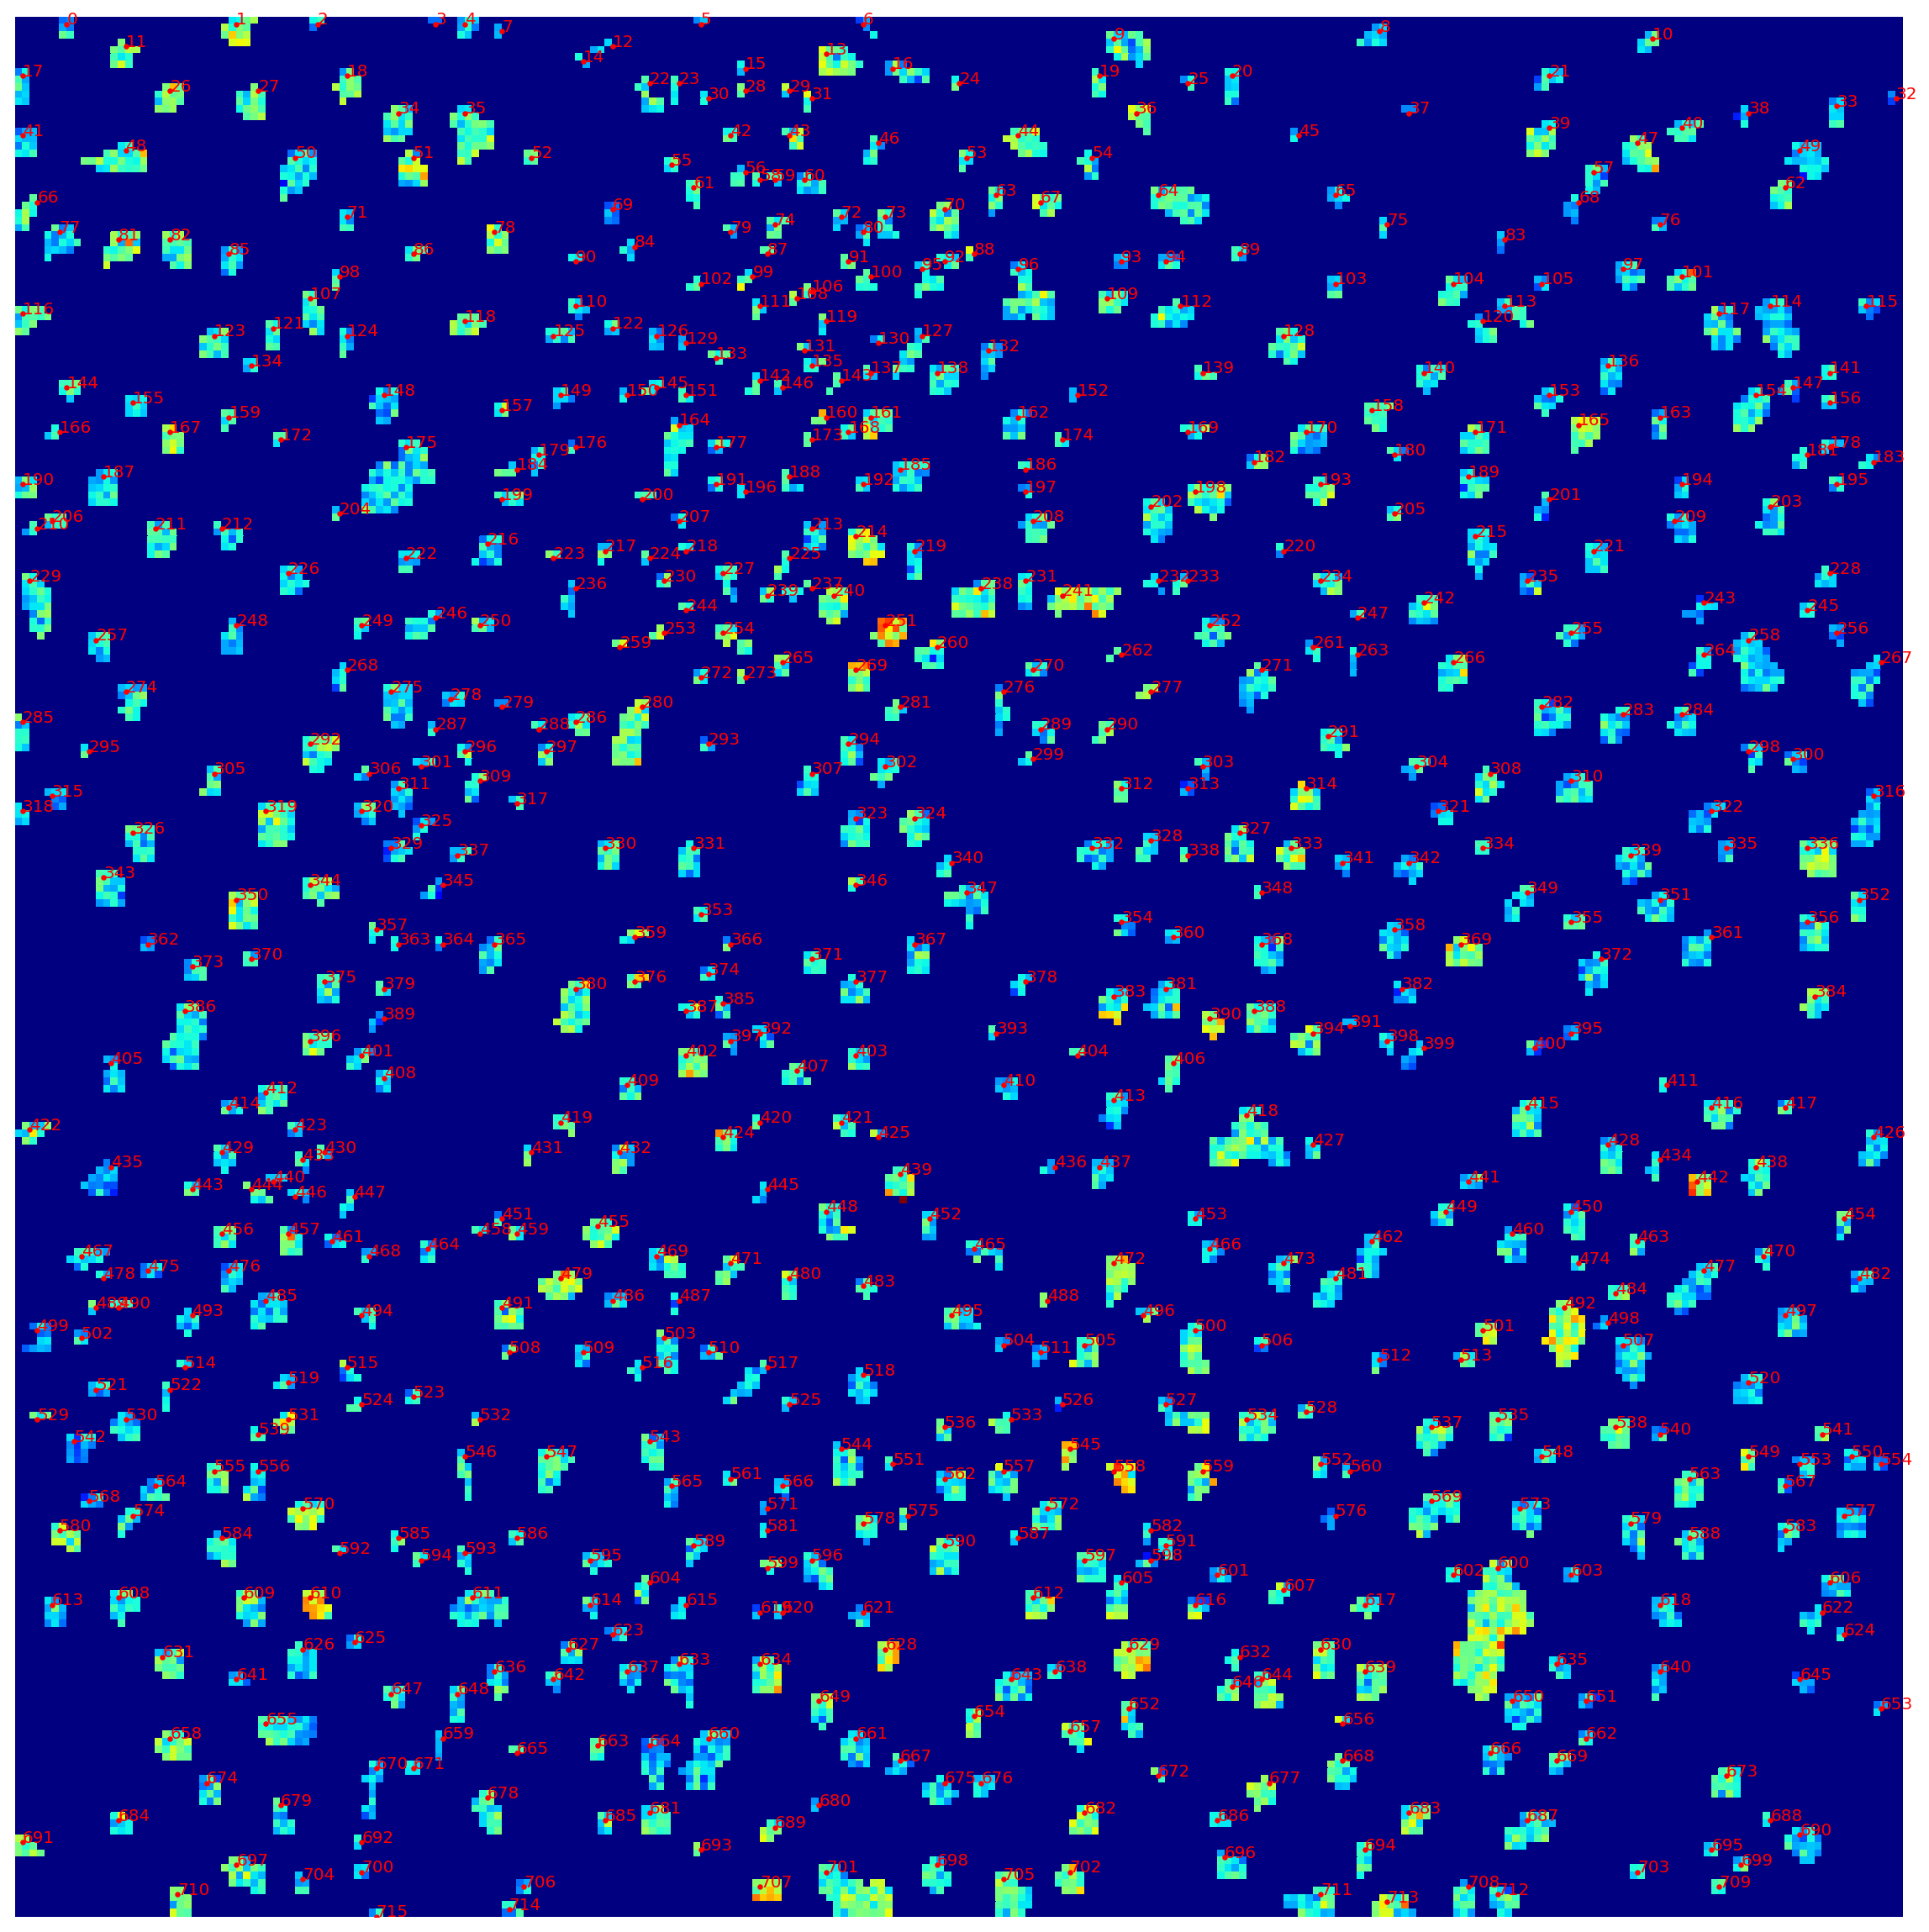

In [88]:
# to_show_x = train_x[:,np.where(matter_list==115.35)]
# to_show_x = train_x[:,matter_list==255.21][:,0]
# to_show_x = train_x[:,matter_list==87.36][:,0]
# to_show_x = train_x_HEG[:,9]
# train_x_preprocess = (train_x)/np.sum(train_x,axis=1,keepdims=True)
cell_pos_list = []
to_show_x = train_x[:,matter_list==87.35][:,0]

# to_show_x = train_x_preprocess[:,0]
# to_show_x = order_mat[391,:]

plt.figure(figsize=(20,20))
to_show_img = np.zeros(shape=65536,)
to_show_img[cell_pos-1] = to_show_x
to_show_img=to_show_img.reshape(256,256)
# plt.imshow(to_show_img,cmap='jet')
sns.heatmap(to_show_img,cmap='jet',cbar=False)
for i in range(num_cells):
    cur_idx = i + 1
    cur_ind = cell_pos[cell_idx==cur_idx][0]
    cur_ind_list = cell_pos[cell_idx==cur_idx]
    cur_x_list = []
    cur_y_list = []
    for j in cur_ind_list:
        cur_x = ind2ij(cur_ind,256,1)
        cur_y = ind2ij(cur_ind,256,0)
        cur_x_list.append(cur_x)
        cur_y_list.append(cur_y)
    cur_x_mean = np.mean(cur_x_list)
    cur_y_mean = np.mean(cur_y_list)
#     print(ind2ij(cur_ind,256,0))
#     print(ind2ij(cur_ind,256,1))
    cell_pos_list.append(np.array([cur_x_mean,cur_y_mean]))
    plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')
    plt.scatter(cur_x_mean, cur_y_mean, s=5, c='red', marker='o')
# plt.colorbar()
# plt.scatter(CV_pos[0],CV_pos[1],s=10,c='blue',marker='o')
# plt.plot([cell_pos_mat[fibro_p1,0],cell_pos_mat[fibro_p2,0]],[cell_pos_mat[fibro_p1,1],cell_pos_mat[fibro_p2,1]])
plt.xticks([])
plt.yticks([])
plt.show()
cell_pos_mat = np.array(cell_pos_list)

In [89]:
def cal_cell_line_dist(p1,p2,cell):
#     p1（x，y）,p2是线上的两点坐标，cell是cell中心坐标
    d = p1[0]
    f = p1[1]
    g = p2[0]
    h = p2[1]
    A = h-f
    B = d-g
    C = (f-h)*d+(g-d)*f
#     dist = np.abs(A*cell[0]+B*cell[1]+C)/np.sqrt(np.square(A)+np.square(B))
    dist = (A*cell[0]+B*cell[1]+C)/np.sqrt(np.square(A)+np.square(B))
    return dist
    

In [157]:
p1_idx = 679
p2_idx = 14
c_idx = 0


cal_cell_line_dist(cell_pos_mat[p1_idx],cell_pos_mat[p2_idx],cell_pos_mat[c_idx])

69.81771117006842

In [99]:
cur_exp_name = cur_exp_name+'_reorder'

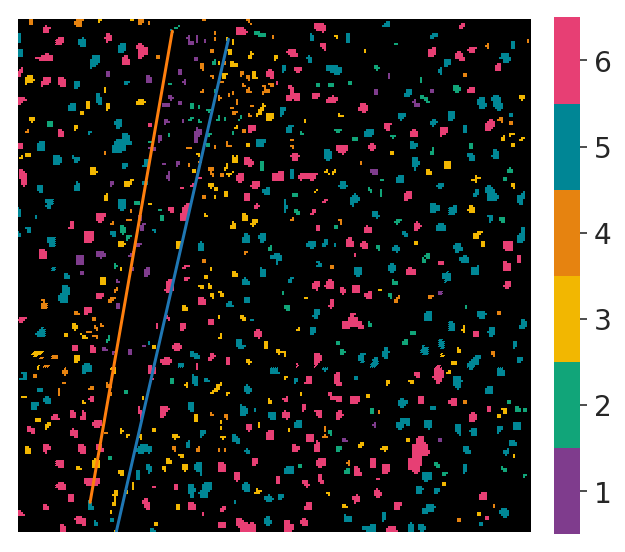

In [141]:
# fibro_p1 = 184
# fibro_p2 = 10

# fibro_p1 = 29
# fibro_p2 = 715

fibro_p3 = 679
fibro_p4 = 14

plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,ifshow=False)
plt.plot([cell_pos_mat[fibro_p1,0],cell_pos_mat[fibro_p2,0]],[cell_pos_mat[fibro_p1,1],cell_pos_mat[fibro_p2,1]])
plt.plot([cell_pos_mat[fibro_p3,0],cell_pos_mat[fibro_p4,0]],[cell_pos_mat[fibro_p3,1],cell_pos_mat[fibro_p4,1]])


In [135]:
tmp_cmp = a.uns[cur_exp_name+'_colors'].copy()
tmp_cmp = [list(c) for c in tmp_cmp]
a.uns[cur_exp_name+'_colors'] = tmp_cmp

In [134]:
tmp_cmp

[[0.49803922, 0.23529412, 0.55294118],
 [0.06666667, 0.64705882, 0.4745098],
 [0.94901961, 0.71764706, 0.00392157],
 [0.90196078, 0.51372549, 0.0627451],
 [0.0, 0.5254902, 0.58431373],
 [0.90588235, 0.24705882, 0.45490196]]

In [144]:
a_hep_87

View of AnnData object with n_obs × n_vars = 121 × 231 
    obs: 'cls_5', 'cls_5_pca', 'cls_8_pca', 'cls_4', 'leiden', 'cls_5_reorder', 'fibro_dist', 'fibro_dist_mum'
    uns: 'rep_list', 'cls_5_colors', 'cls_5_pca_colors', 'cls_8_pca_colors', 'cls_4_colors', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'cls_5_reorder_colors'
    obsm: 'X_umap', 'cls_5_rep', 'cls_5_pca_rep', 'cls_8_pca_rep', 'cls_4_rep', 'spatial'

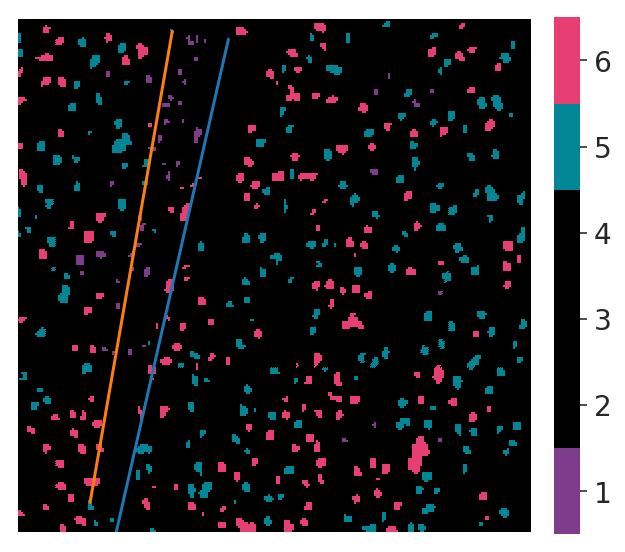

In [146]:
# fibro_p1 = 184
# fibro_p2 = 10

fibro_p1 = 29
fibro_p2 = 715

fibro_p3 = 679
fibro_p4 = 14
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=[0,4,5],ifshow=False)
plt.plot([cell_pos_mat[fibro_p1,0],cell_pos_mat[fibro_p2,0]],[cell_pos_mat[fibro_p1,1],cell_pos_mat[fibro_p2,1]])

plt.plot([cell_pos_mat[fibro_p3,0],cell_pos_mat[fibro_p4,0]],[cell_pos_mat[fibro_p3,1],cell_pos_mat[fibro_p4,1]])


In [147]:
a.obsm['spatial'] = cell_pos_mat

In [158]:
# 先计算每个细胞距离border的距离
# p1_idx = 29
# p2_idx = 715
p1_idx = 679
p2_idx = 14
fibro_dist = []
for i in range(a.shape[0]):
#     cur_pos = a.obsm['spatial'][i]
    c_idx = i

    cur_dist = cal_cell_line_dist(a.obsm['spatial'][p1_idx],a.obsm['spatial'][p2_idx],a.obsm['spatial'][c_idx])
    fibro_dist.append(cur_dist)
    
a.obs['fibro_dist'] =np.array(fibro_dist)

    

In [159]:
a.obs['fibro_dist_mum'] = a.obs['fibro_dist']*400/256

In [109]:
np.unique(a.obs[cur_exp_name])

array(['1', '2', '3', '4', '5', '6'], dtype=object)

In [161]:
a_hep_87

View of AnnData object with n_obs × n_vars = 42 × 231 
    obs: 'cls_5', 'cls_5_pca', 'cls_8_pca', 'cls_4', 'leiden', 'cls_5_reorder', 'fibro_dist', 'fibro_dist_mum'
    uns: 'rep_list', 'cls_5_colors', 'cls_5_pca_colors', 'cls_8_pca_colors', 'cls_4_colors', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'cls_5_reorder_colors'
    obsm: 'X_umap', 'cls_5_rep', 'cls_5_pca_rep', 'cls_8_pca_rep', 'cls_4_rep', 'spatial'

In [160]:
c_hep_normal='5'
c_hep_87='6'
# c_hep_87_ = '5'
# c_hep_87='3'


a_hep_normal = a[a.obs[cur_exp_name]==c_hep_normal]
a_hep_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']>0]
# a_hep_87 = a[a.obs[cur_exp_name]==c_hep_87]
a_hep_87 = a[a.obs[cur_exp_name].isin([c_hep_87])]
a_hep_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']>0]


a_hep_all = a[a.obs[cur_exp_name].isin([c_hep_87,c_hep_normal])]
a_hep_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']>0]

thre_list = []
count_normal_list = []
count_normal_standard_list = []
count_87_list = []
count_87_standard_list = []
count_ratio_list = []
count_ratio_standard_list =[]
dist_pvalue_list = []
dist_pvalue_list2 = []

thre_range = range(10,500)
for i in thre_range:
    print(i)
    cur_a_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']<i]
    cur_a_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']<i]
    cur_a_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']<i]
    
    cur_dist_87 = cur_a_87.obs['fibro_dist_mum']
    cur_dist_all = cur_a_all.obs['fibro_dist_mum']
    cur_dist_normal = cur_a_normal.obs['fibro_dist_mum']
    _,pvalue = scipy.stats.ranksums(cur_dist_87,cur_dist_all)
    _,pvalue2 = scipy.stats.ranksums(cur_dist_87,cur_dist_normal)
    
    dist_pvalue_list.append(pvalue)
    dist_pvalue_list2.append(pvalue2)
    
    count_normal = np.sum(a_hep_normal.obs['fibro_dist_mum']<i)
    count_normal_standard = count_normal/a_hep_normal.shape[0]
    count_87 = np.sum(a_hep_87.obs['fibro_dist_mum']<i)
    count_87_standard = count_87/a_hep_87.shape[0]
    
    thre_list.append(i)
    count_normal_list.append(count_normal)
    count_87_list.append(count_87)
    count_ratio_list.append(count_87/count_normal)
    
    count_normal_standard_list.append(count_normal_standard)
    count_87_standard_list.append(count_87_standard)
    count_ratio_standard_list.append(count_87_standard/count_normal_standard)


10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

In [113]:
1+1

2

In [115]:
count_ratio_standard_list = np.array(count_ratio_standard_list)


In [298]:
cur_dist_all.shape

(349,)

In [305]:
scipy.stats.ranksums(cur_dist_87,cur_dist_normal)

RanksumsResult(statistic=-2.7319627745878616, pvalue=0.006295825397926693)

In [299]:
scipy.stats.ranksums(cur_dist_87,cur_dist_all)

RanksumsResult(statistic=-2.344711527278026, pvalue=0.019041805897712642)

In [300]:
scipy.stats.ttest_ind(cur_dist_87,cur_dist_all)

Ttest_indResult(statistic=-2.3010366641106335, pvalue=0.021903063000418107)

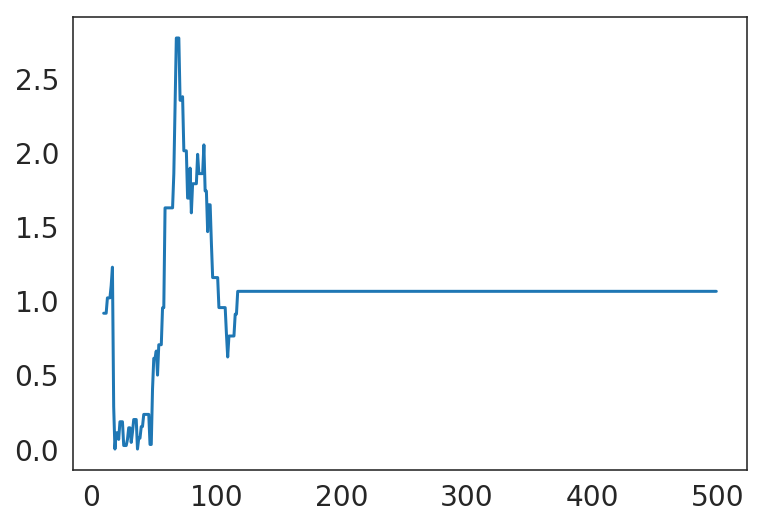

In [162]:
plt.plot(thre_list,-np.log10(dist_pvalue_list2))

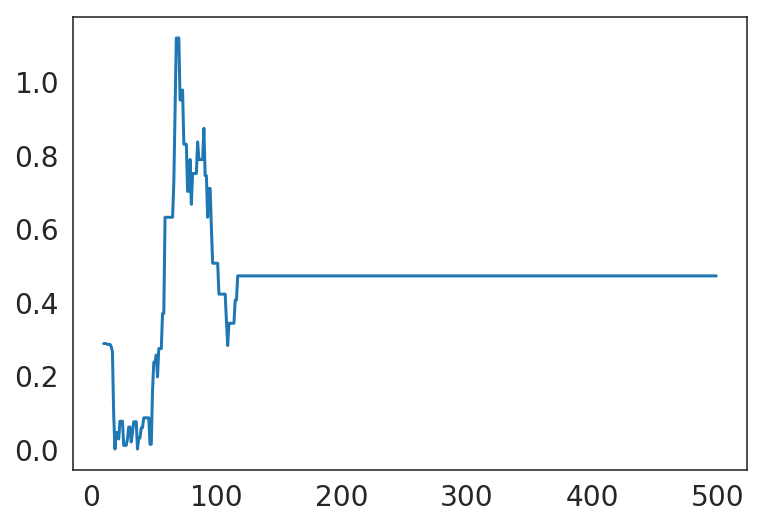

In [163]:
plt.plot(thre_list,-np.log10(dist_pvalue_list))

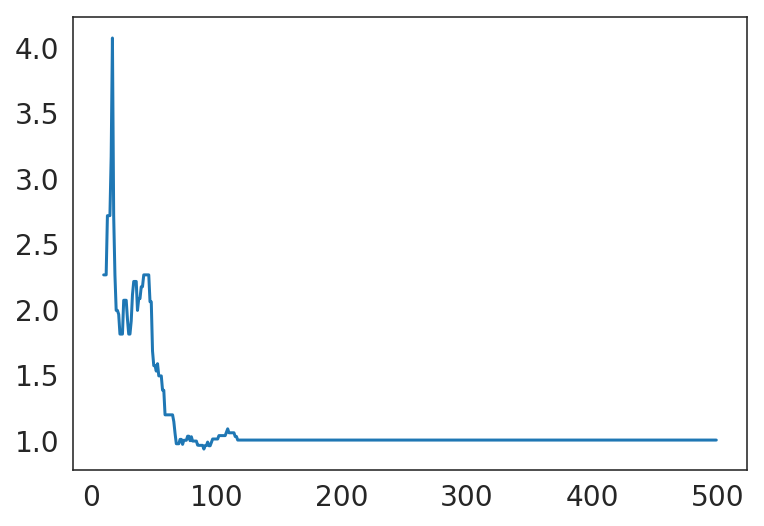

In [164]:
plt.plot(thre_list,count_ratio_standard_list)

In [312]:
import matplotlib
matplotlib.__version__

'3.0.3'

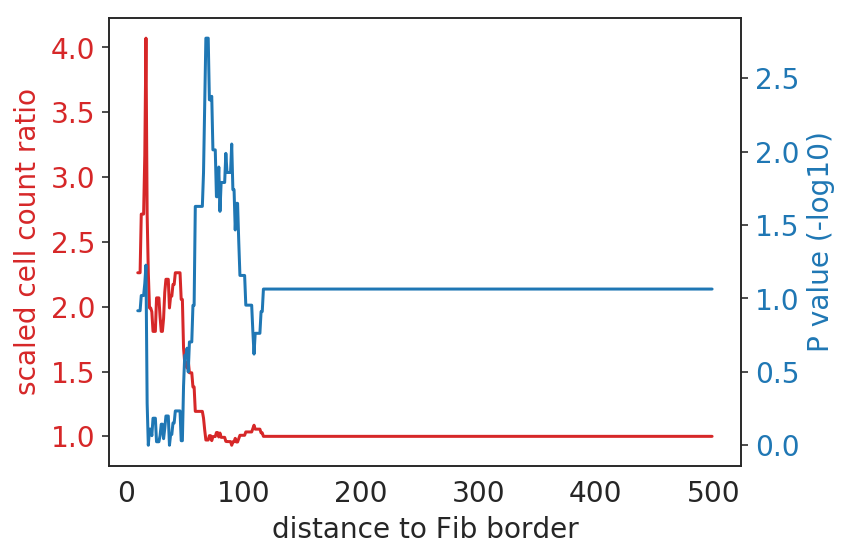

In [165]:
sns.set_style('white')
t=thre_list
data1 = count_ratio_standard_list
data2 = -np.log10(dist_pvalue_list2)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('distance to Fib border')
ax1.set_ylabel('scaled cell count ratio', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('P value (-log10)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

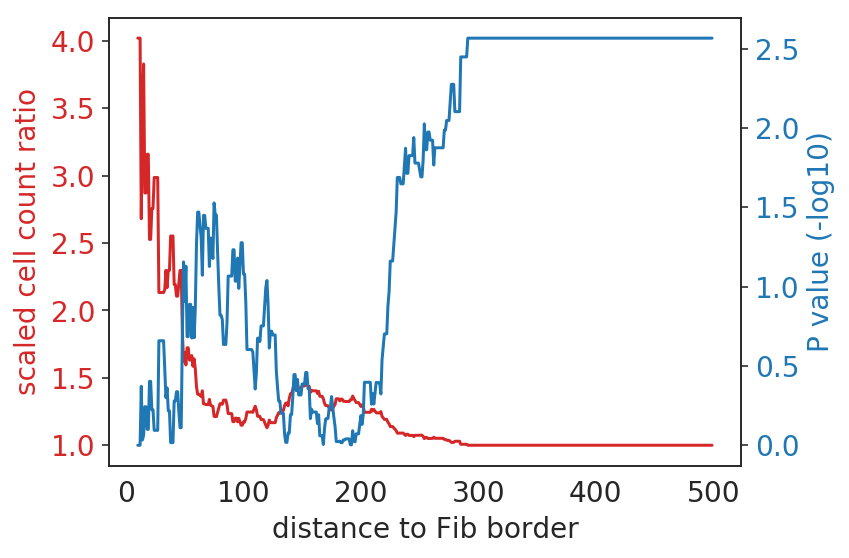

In [119]:
sns.set_style('white')
t=thre_list
data1 = count_ratio_standard_list
data2 = -np.log10(dist_pvalue_list2)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('distance to Fib border')
ax1.set_ylabel('scaled cell count ratio', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('P value (-log10)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Leu discover

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

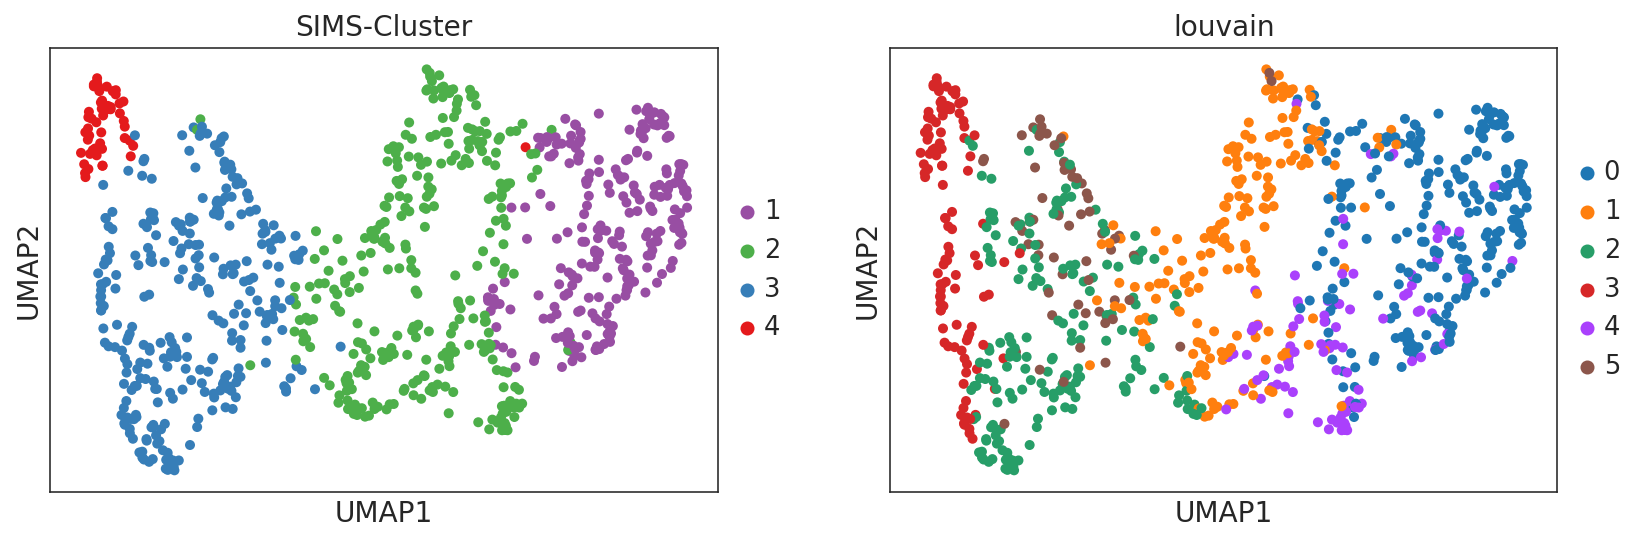

In [326]:
sc.pl.umap(a,color=['SIMS-Cluster','louvain'],save=None,s=100)

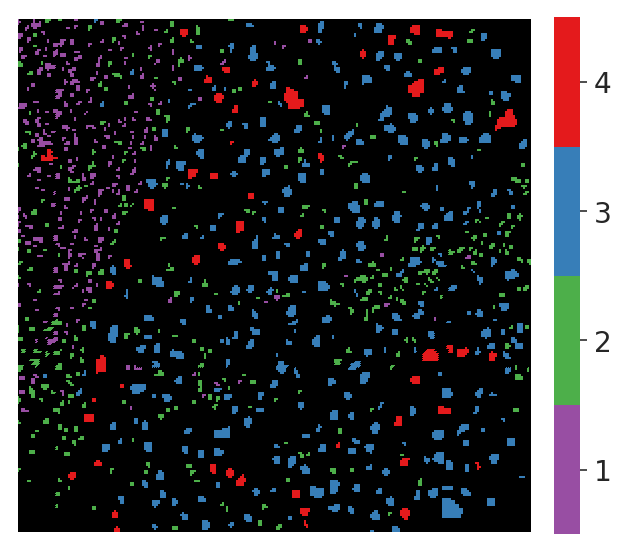

In [327]:
plot_label_image(a.obs['SIMS-Cluster'],a.uns['SIMS-Cluster_colors'],mask=[0,1,2,3,4],save=None)


In [328]:
a_ec = a[a.obs['SIMS-Cluster']=='2']

In [331]:
sc.pp.neighbors(a_ec)
sc.tl.louvain(a_ec)
sc.tl.leiden(a_ec)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


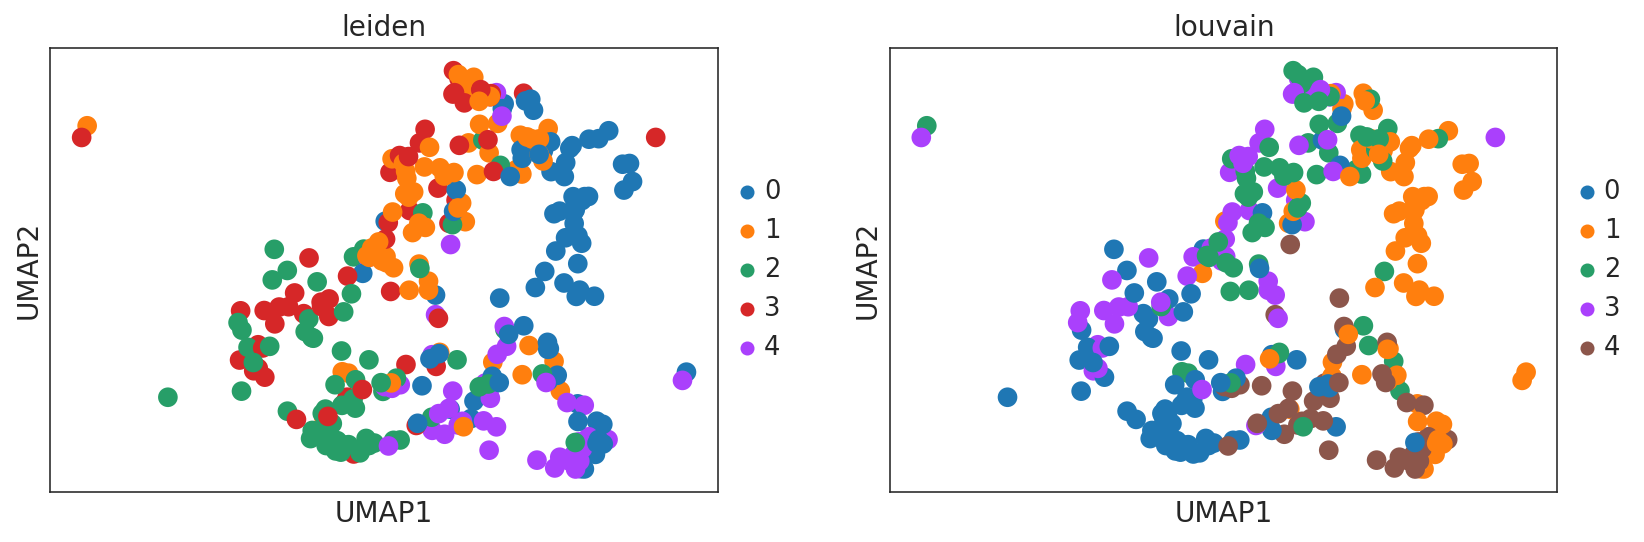

In [332]:
sc.pl.umap(a_ec,color=['leiden','louvain'])

In [333]:
sc.tl.rank_genes_groups(a_ec,groupby='louvain')

ranking genes
    finished (0:00:00)


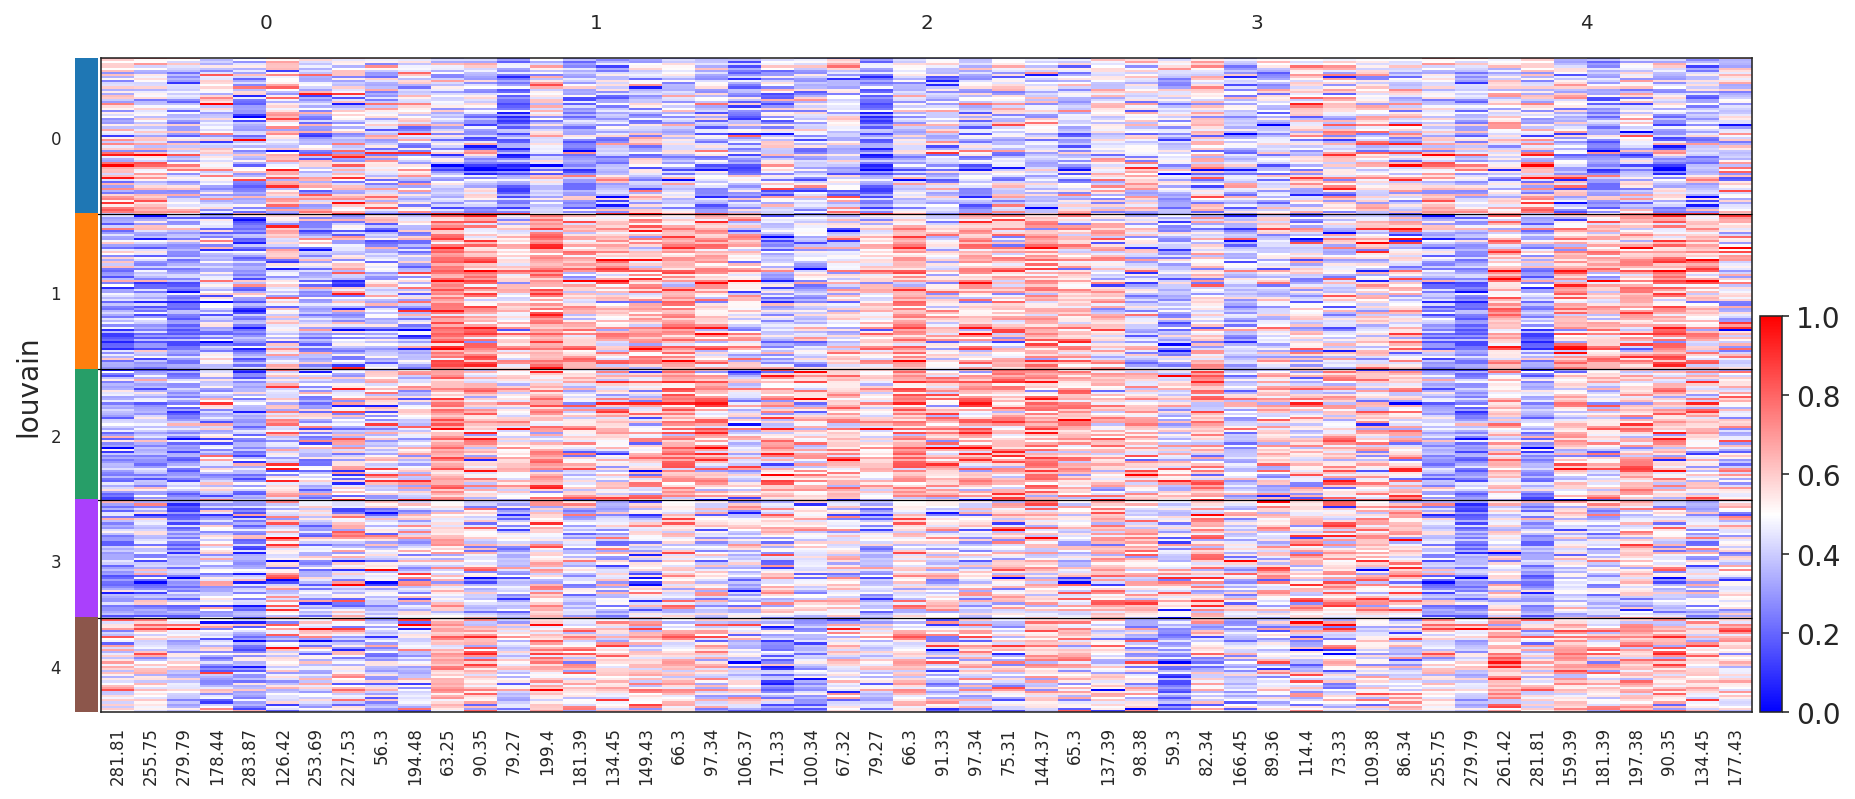

In [334]:
sc.pl.rank_genes_groups_heatmap(a_ec,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [337]:
a_cls_sub = np.array(a.obs['SIMS-Cluster'])
ec_cls = np.array(a_ec.obs['louvain'])
to_replace_cls = '2'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

In [338]:
a.obs['cls_sub_leu'] = a_cls_sub_modified
a.obs['cls_sub_leu'] = a.obs['cls_sub_leu'].astype('category')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

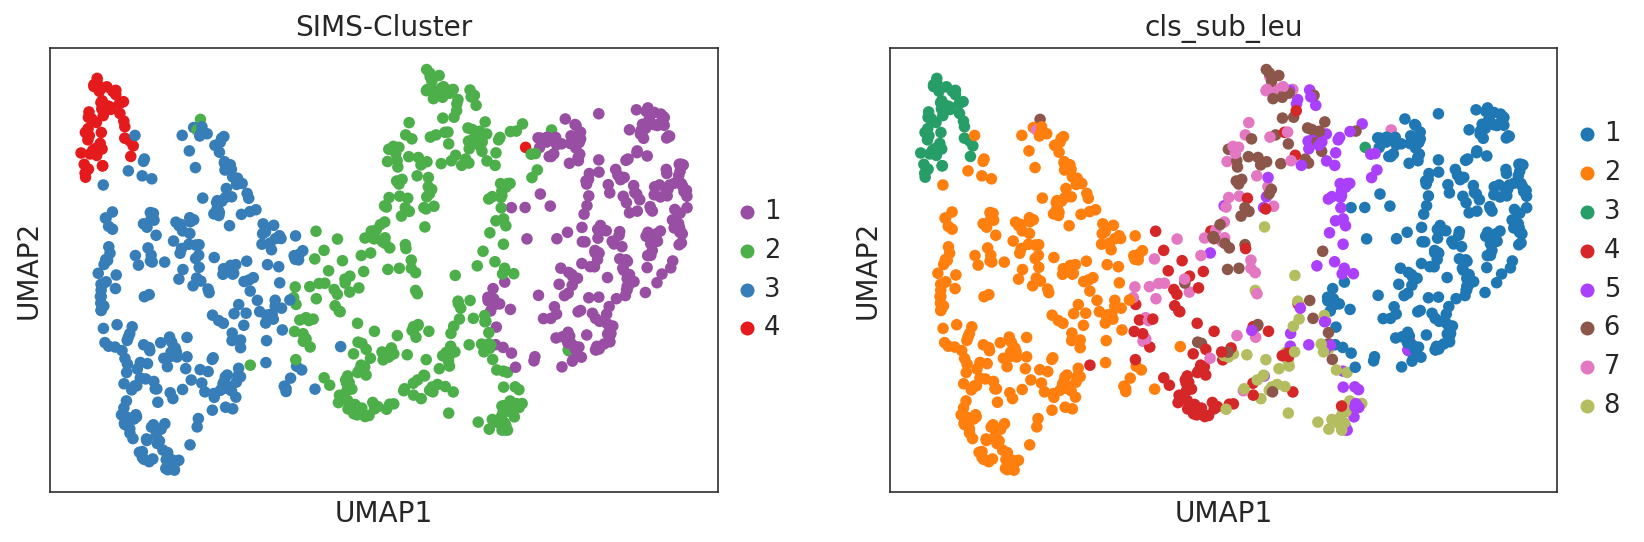

In [339]:
sc.pl.umap(a,color=['SIMS-Cluster','cls_sub_leu'])

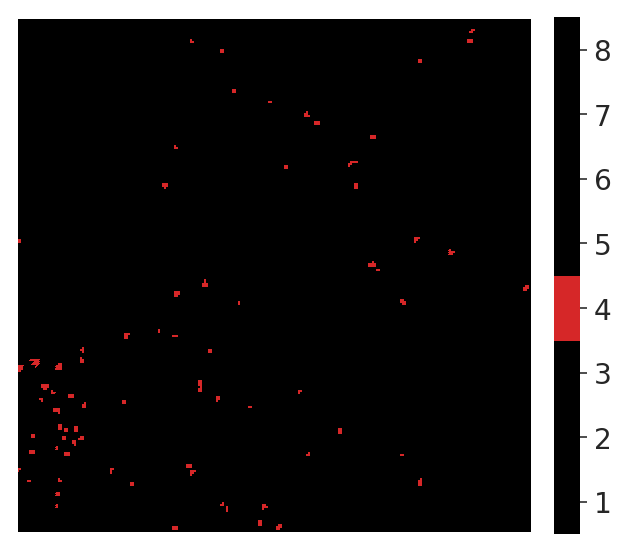

In [340]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[3],save=None)


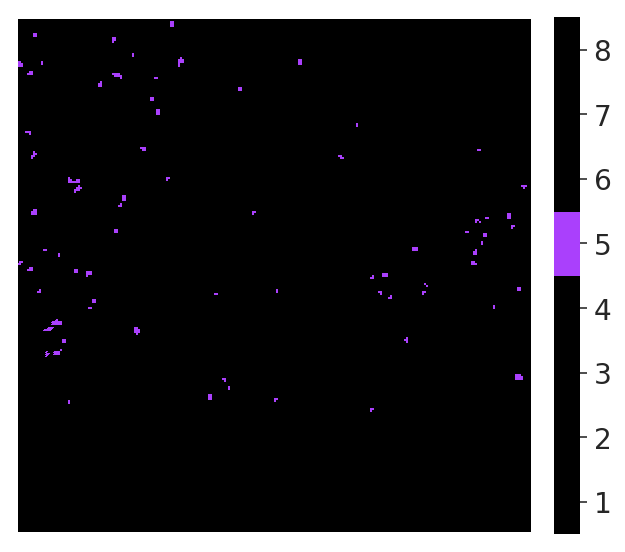

In [341]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[4],save=None)


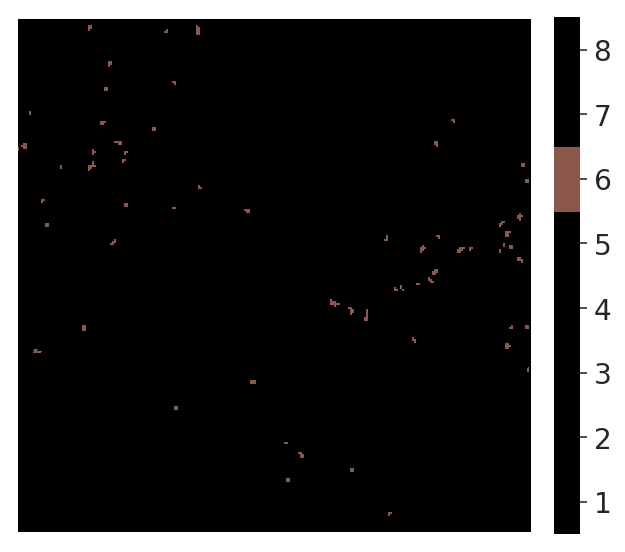

In [342]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[5],save=None)


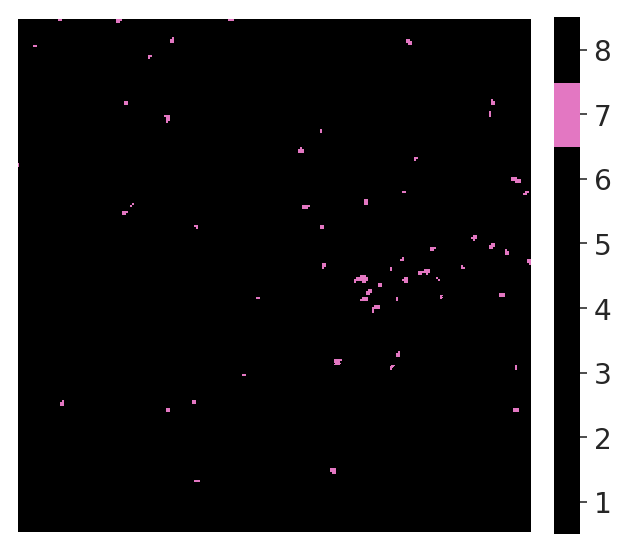

In [343]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[6],save=None)


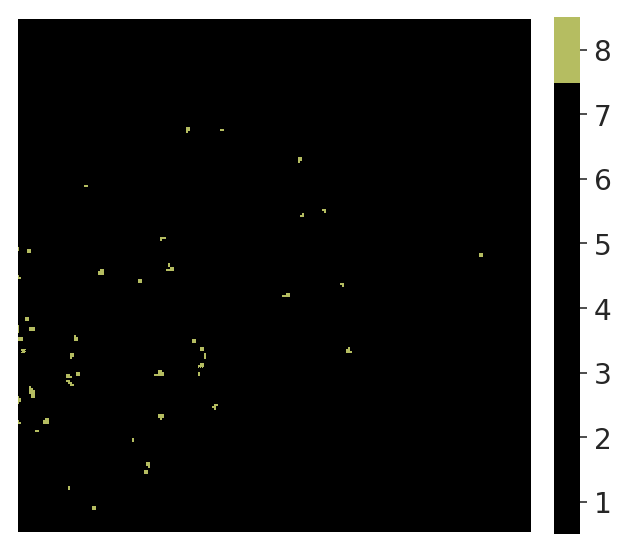

In [344]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[7],save=None)


## Different K

### k=4

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

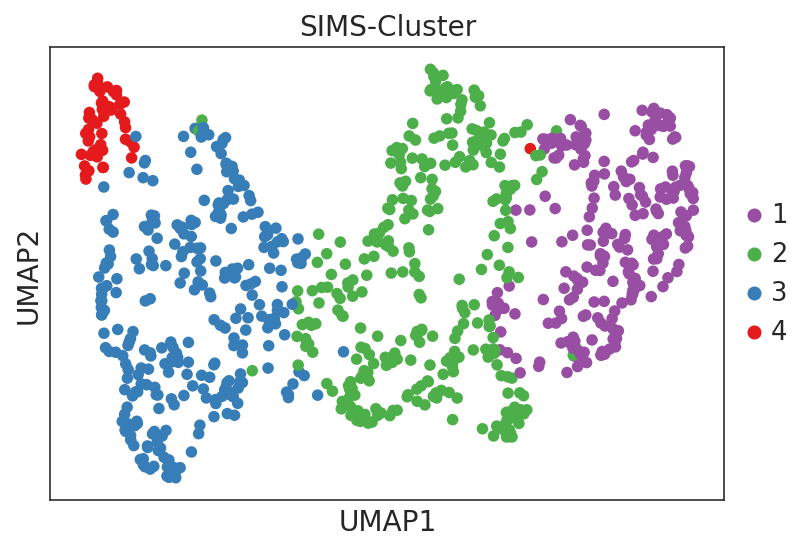

In [346]:
sc.pl.umap(a,color='SIMS-Cluster')

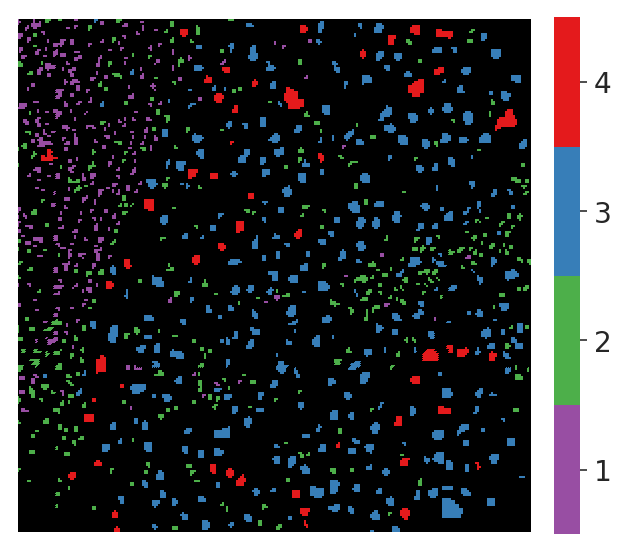

In [348]:
plot_label_image(a_test.obs['SIMS-Cluster'],a_test.uns['SIMS-Cluster_colors'],mask=None)


## k=5

In [350]:
a_ec2 = a[a.obs['SIMS-Cluster'].isin(['1','2'])]

In [428]:
sc.pp.neighbors(a_ec2,use_rep='X_umap')
sc.tl.leiden(a_ec2,resolution=0.12)

# louvain
# mean
# 0.3:2
# 0.7:3
# 1:4

# X_umap
# 0.02:2
# 0.07:3
# 0.1:4
# 0.15:5


# leiden
# 0.02:2
# 0.05:3
# 0.07:4
# 0.1:5
# 0.12:6


computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


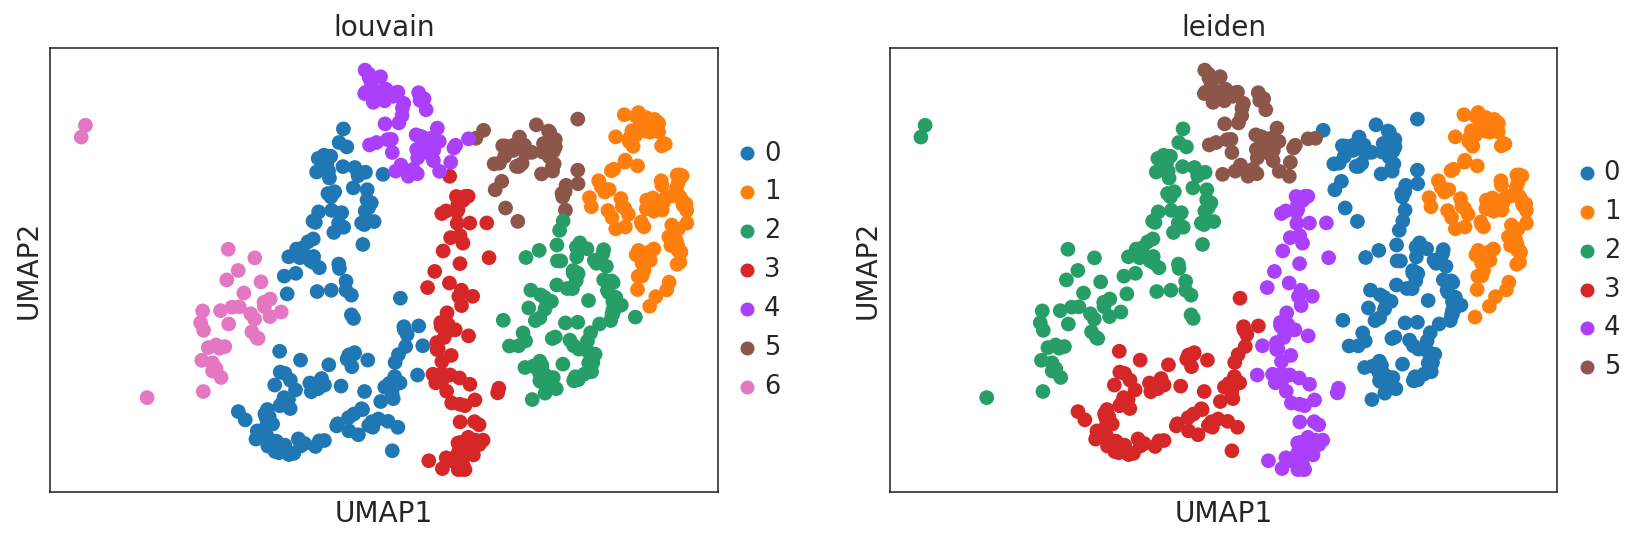

In [429]:
sc.pl.umap(a_ec2,color=['louvain','leiden'])


In [430]:
sc.tl.rank_genes_groups(a_ec2,groupby='leiden')


ranking genes
    finished (0:00:00)


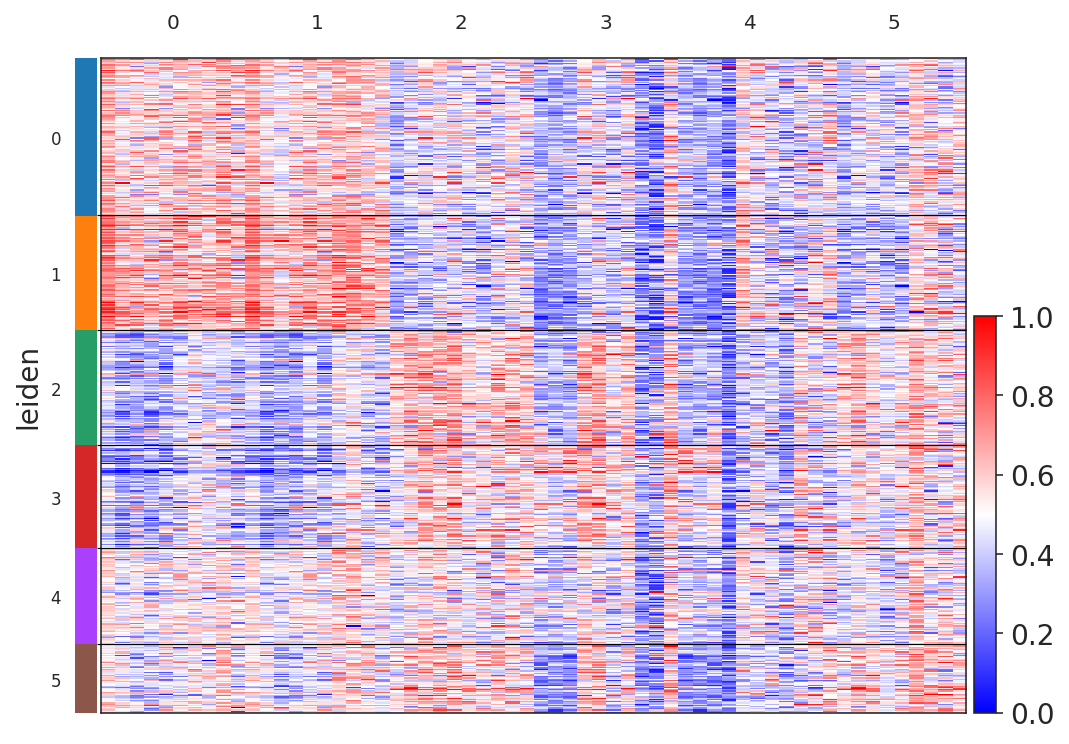

In [431]:
sc.tl.rank_genes_groups(a_ec2,groupby='leiden')

sc.pl.rank_genes_groups_heatmap(a_ec2,groupby='leiden',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [432]:
a_cls_sub = np.array(a.obs['SIMS-Cluster'])
ec_cls = np.array(a_ec2.obs['leiden'])
to_replace_cls = ['1','2']
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)
a.obs['cls_5'] = a_cls_sub_modified
a.obs['cls_5'] = a.obs['cls_5'].astype('category')


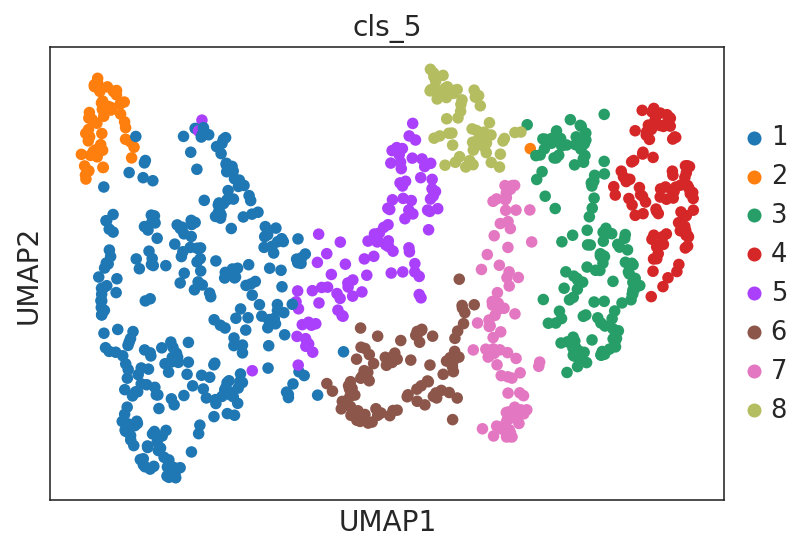

In [433]:
sc.pl.umap(a,color='cls_5')

In [1]:
1+1

2

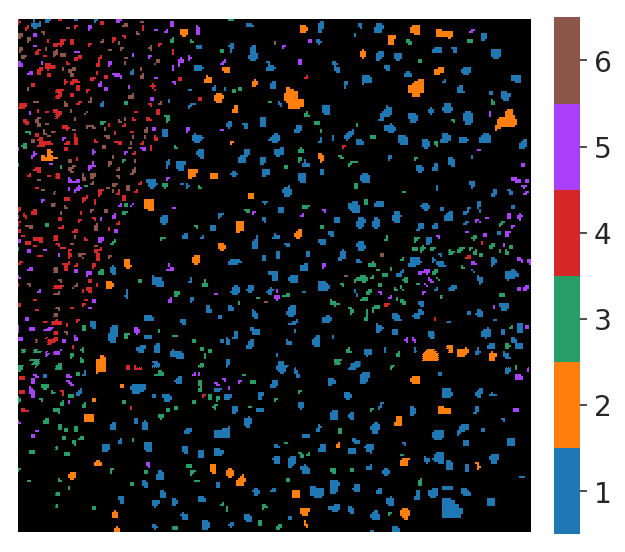

In [390]:
plot_label_image(a.obs['cls_5'],a.uns['cls_5_colors'],mask=None)


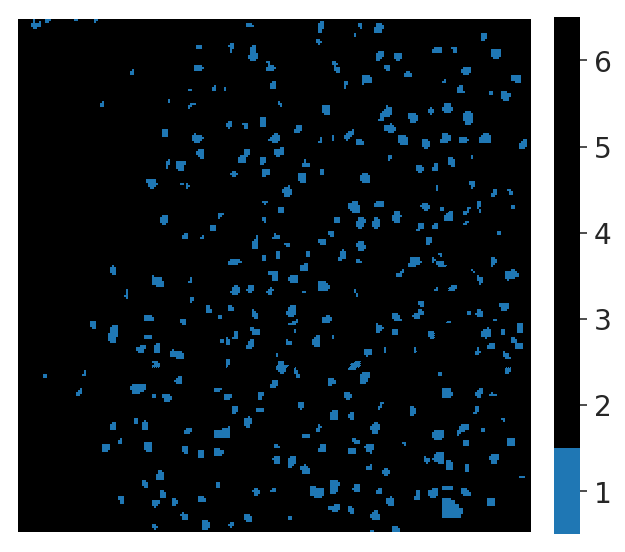

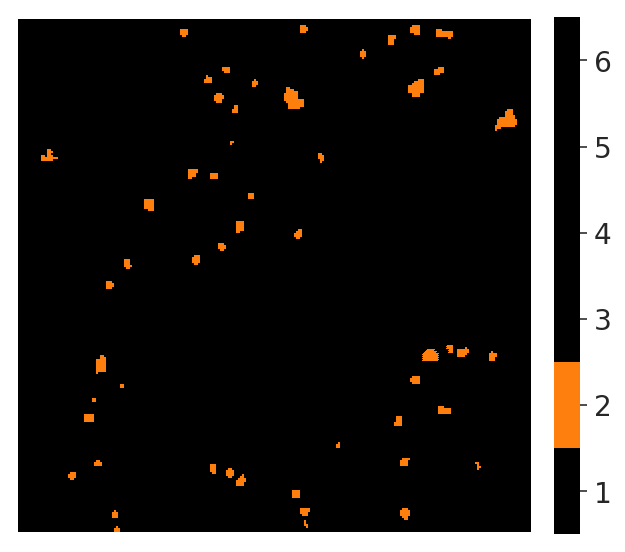

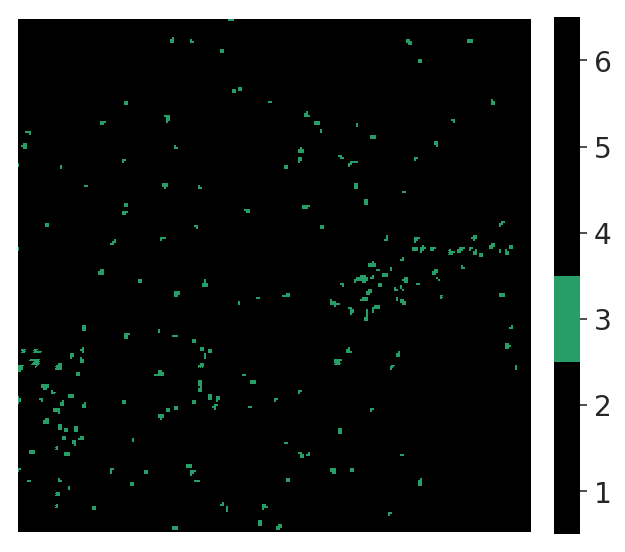

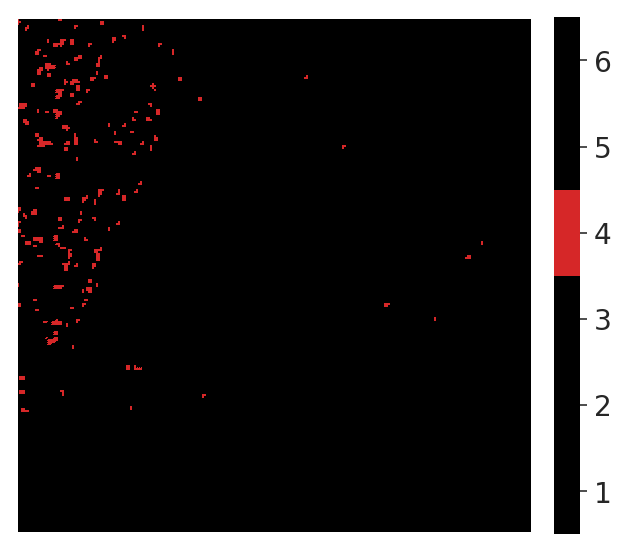

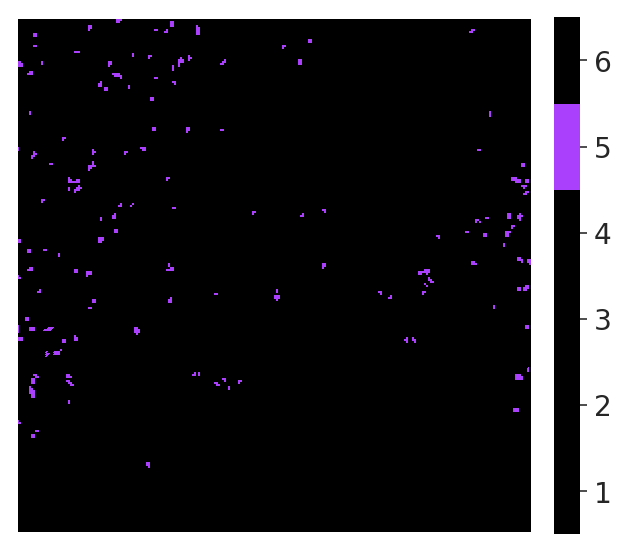

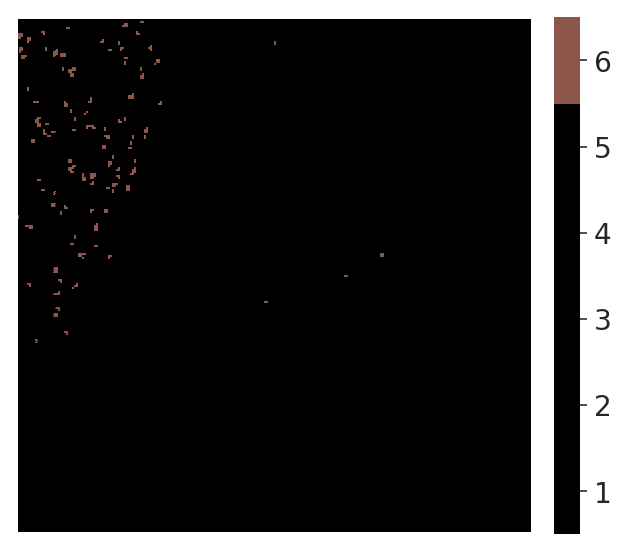

In [391]:
for i in range(6):
    plot_label_image(a.obs['cls_5'],a.uns['cls_5_colors'],mask=[i])
    

In [502]:
sc.pp.neighbors(a,use_rep='X_umap')
sc.tl.leiden(a,resolution=0.07)
# 0.07:5
# 0.1:6
# 0.105:7
# 0.11:8

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

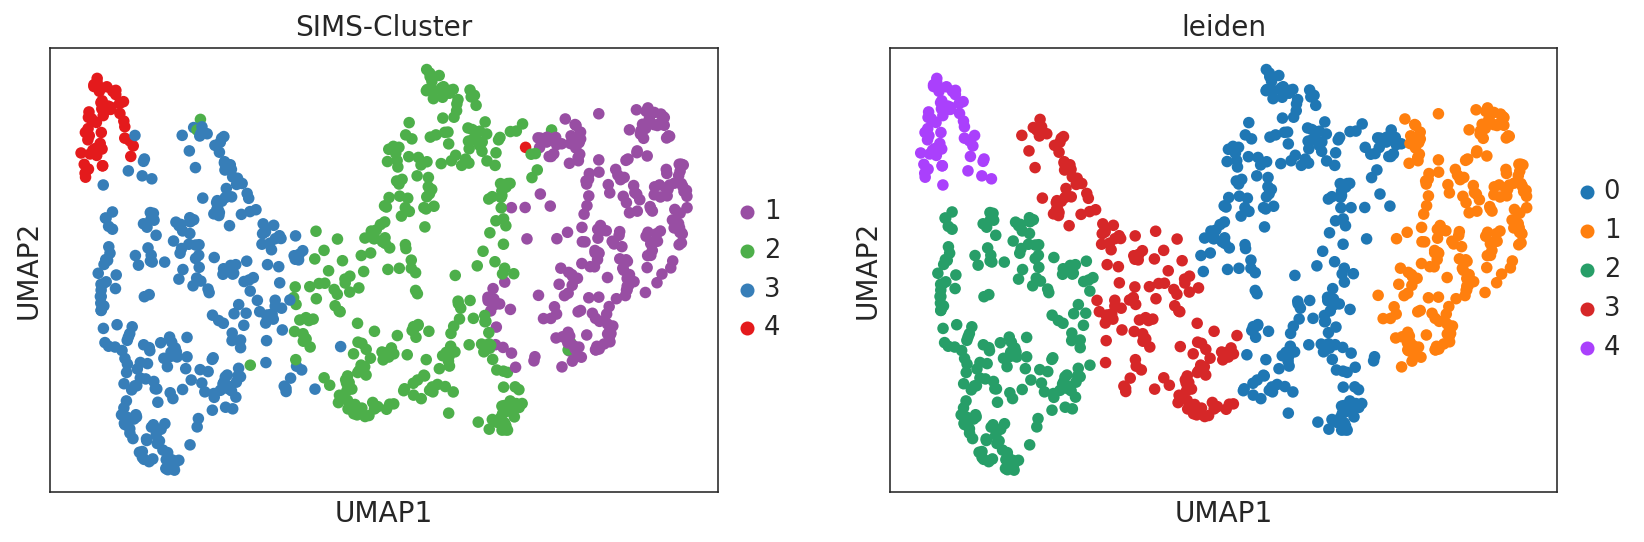

In [503]:
sc.pl.umap(a,color=['SIMS-Cluster','leiden'])

In [472]:
np.unique(a.obs['louvain'])

array(['0', '1', '2', '3', '4', '5'], dtype=object)

In [458]:
a.uns['louvain_colors']

['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b']

In [457]:
a.uns['leiden_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8']

In [479]:
tmp_cmp = palettable.colorbrewer.qualitative.Set1_6.mpl_colors

In [504]:
a.uns['leiden_colors'] = palettable.colorbrewer.qualitative.Set1_5.mpl_colors

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

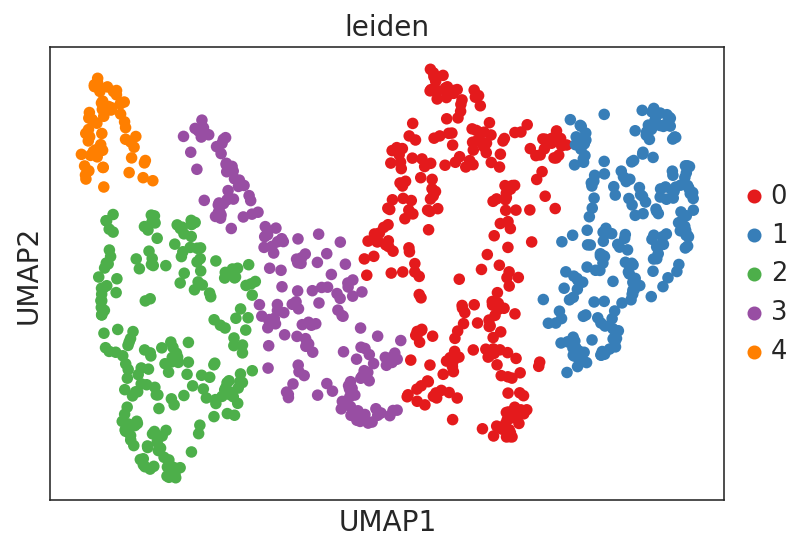

In [505]:
sc.pl.umap(a,color=['leiden'])

ranking genes
    finished (0:00:00)


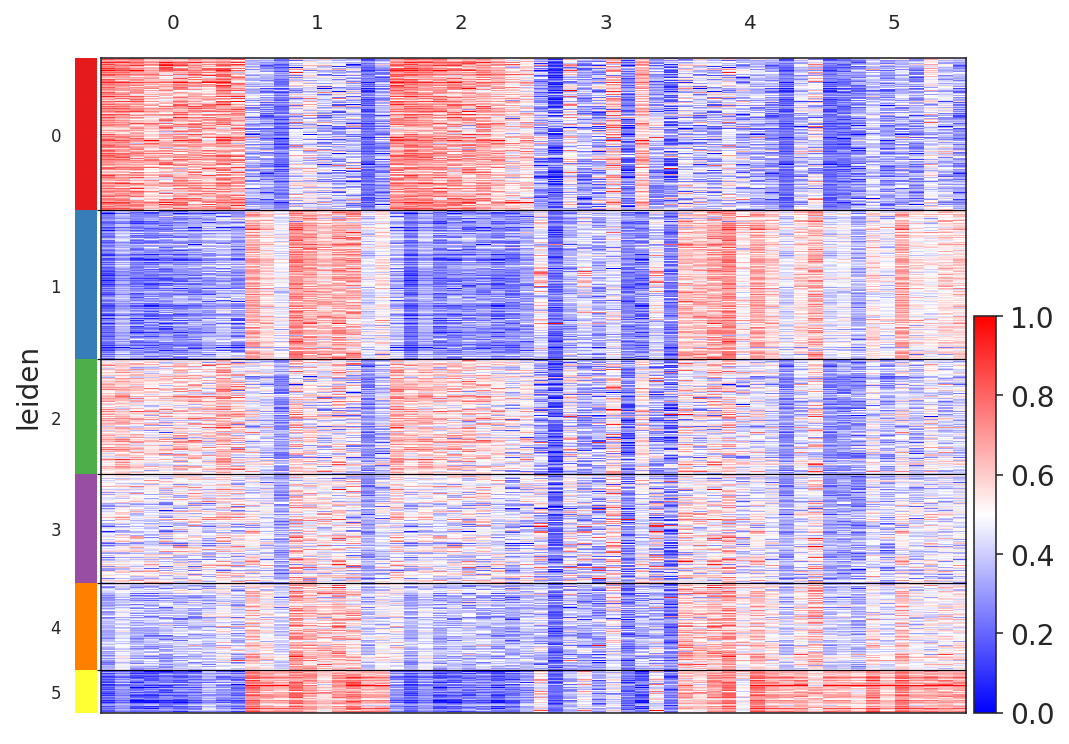

In [496]:
sc.tl.rank_genes_groups(a,groupby='leiden')
sc.pl.rank_genes_groups_heatmap(a,groupby='leiden',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


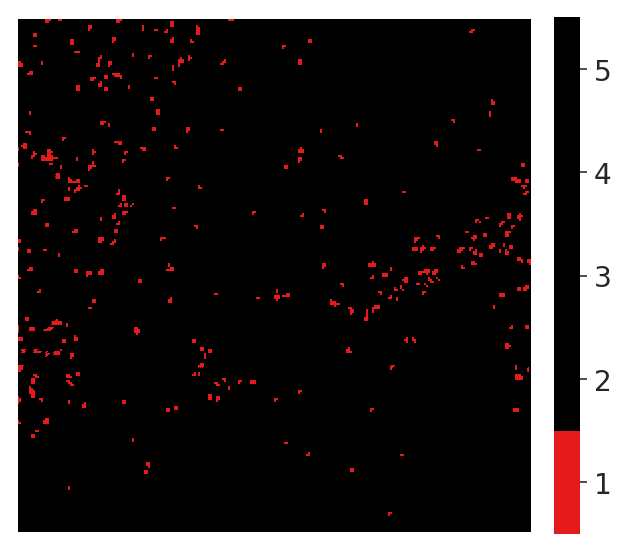

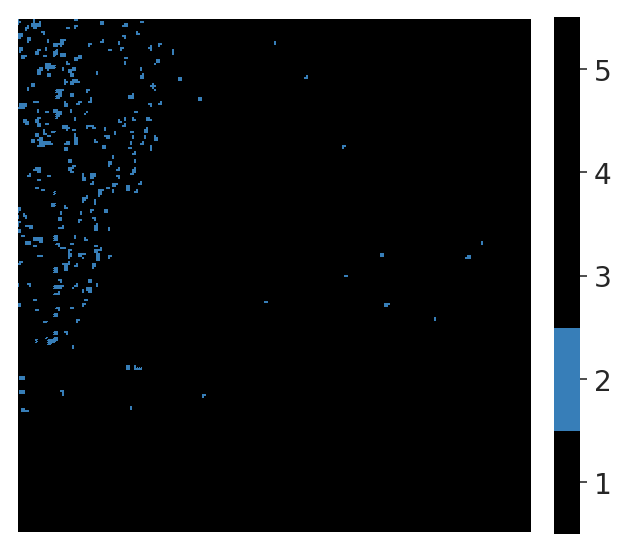

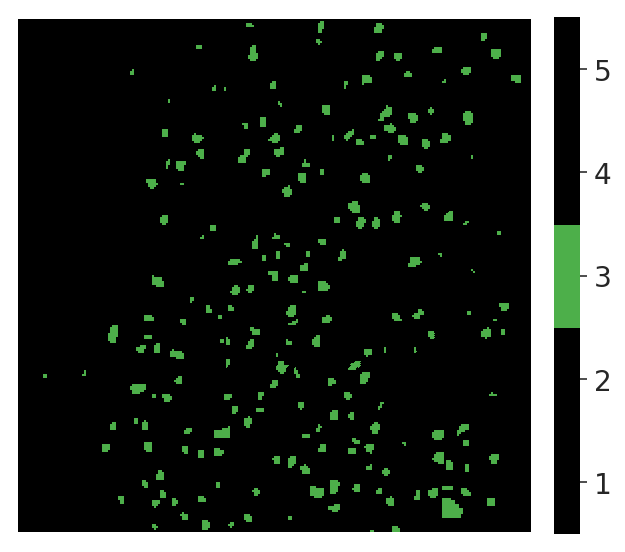

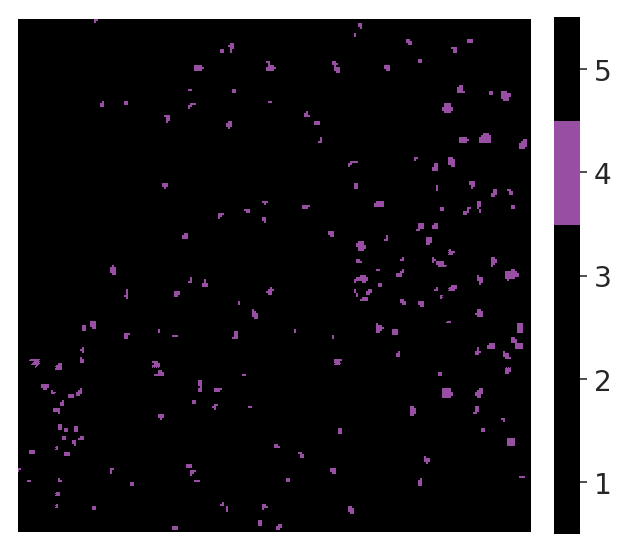

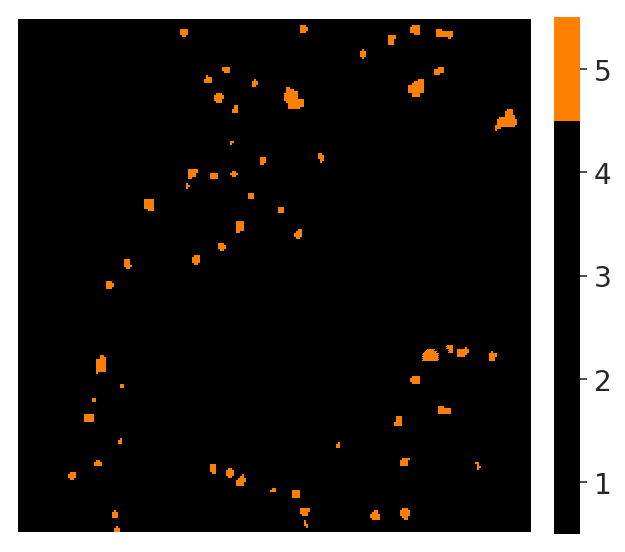

In [506]:
for i in range(5):
    plot_label_image(a.obs['leiden'],a.uns['leiden_colors'],mask=[i])
    

In [357]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    to_replace_cls = np.array(to_replace_cls).astype('int')
    for i in to_replace_cls:
        
        a_cls_sub_int[a_cls_sub_int==int(i)] = -1
        a_cls_sub_int[a_cls_sub_int>int(i)]-=1
        to_replace_cls[to_replace_cls>i]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [356]:
1+1

2

# save anndata

In [140]:
a.write('figures/Fig2/c4/fig2_c4.h5py')

In [225]:
a.write('figures/Fig4_dump_data/fig4_csub.h5ad')

In [166]:
a.write('figures/Fig4_dump_data/fig4_rep0_cls6_reorder_full_side2.h5ad')

In [226]:
a_test = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_csub.h5ad')


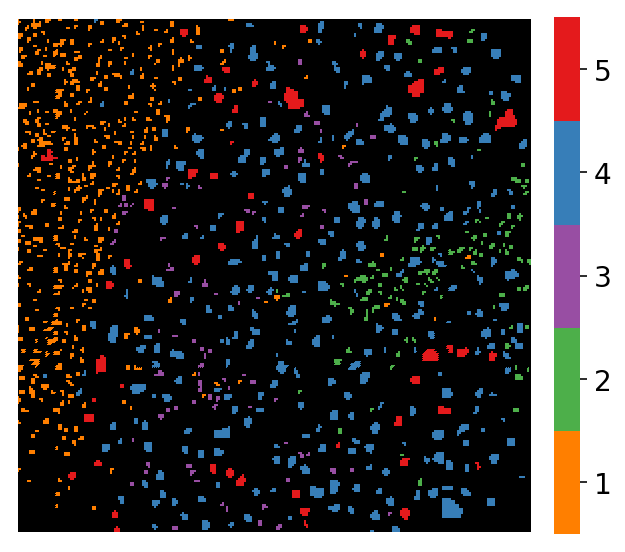

In [227]:
plot_label_image(a_test.obs['cls_sub'],a_test.uns['cls_sub_colors'],mask=[0,1,2,3,4])


In [229]:
1+1

2